In [1]:
#Imports
import logging
import os, random, time, sys
import numpy as np
import tensorflow as tf
import tensorflow.contrib.layers as layers
import ipdb
import keras
import pandas as pd

sys.path.append('../../../')
import feedforward_robust as ffr

sys.path.append('../../../utils/')
from utils.mnist_corruption import *
from utils.utils_models import *
from utils.utils_analysis import *
from utils.utils_feedforward import *

%load_ext autoreload
%autoreload 2

#Read the counter
ctr_file = "../../counter.txt"
f = open(ctr_file, 'r')
counter = f.readline()
f.close()

counter = 1 + int(counter)
f = open(ctr_file,'w')
f.write('{}'.format(counter))
f.close()
logfile = "../../logs/results_" + str(counter) + ".log"

logger = logging.getLogger("robustness")
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler(logfile)
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)
logger.addHandler(logging.StreamHandler())

Using TensorFlow backend.
W0629 18:00:50.695003 4574504384 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/cleverhans/utils_tf.py:341: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.



# Get Raw Training Data

In [2]:
n = 8
n_test = 10000
x_train = np.linspace(-1, 1-(2)/n, n).astype(np.float64)
x_test = np.linspace(-1, 1-(2)/n_test, n_test).astype(np.float64)
x_train = x_train.reshape((n, 1))
x_test = x_test.reshape((n_test, 1))

In [3]:
y_train = np.sign(x_train).astype(np.int)
y_train[y_train==0] = 1
y_train_ogi = y_train.copy()
y_train[y_train==-1] = 0

y_test = np.sign(x_test).astype(np.int)
y_test[y_test==0] = 1
y_test[y_test==-1] = 0

In [4]:
y_train = y_train.flatten()
y_test = y_test.flatten()

In [5]:
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)                                                                                         
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
y_train

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [7]:
y_test[:10]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [8]:
y_test[-10:]

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [0., 1.]], dtype=float32)

In [9]:
def featurize_fourier(X, params_dict, seed=None, p = 0):
    d = params_dict['d']
    p = p/2.
    assert (d-1) % 2 == 0, "d must be odd"
    
    max_r = int((d-1)/2)
    n = len(X)
    A = np.zeros((n, d))
    A[:,0] = 1*(1/np.sqrt(2))
    
    for d_ in range(1,max_r+1):
        A[:,2*(d_-1)+1] = (1./(d_**(p/2))) * np.sin(d_*X*np.pi)
        A[:,2*(d_-1)+2] = (1./(d_**(p/2))) * np.cos(d_*X*np.pi)
    return A

In [10]:
params_dict = {}
params_dict['d'] = 101

In [11]:
phi_x_train = featurize_fourier(x_train.flatten(), params_dict, p = 1.0)
phi_x_test = featurize_fourier(x_test.flatten(), params_dict, p = 1.0)

In [12]:
phi_x_train[5]

array([ 7.07106781e-01,  7.07106781e-01,  7.07106781e-01,  8.40896415e-01,
        5.14900552e-17,  5.37284966e-01, -5.37284966e-01,  8.65956056e-17,
       -7.07106781e-01, -4.72870805e-01, -4.72870805e-01, -6.38943104e-01,
       -1.17371944e-16, -4.34720872e-01,  4.34720872e-01, -1.45635869e-16,
        5.94603558e-01,  4.08248290e-01,  4.08248290e-01,  5.62341325e-01,
        1.72167376e-16,  3.88272678e-01, -3.88272678e-01,  1.97395294e-16,
       -5.37284966e-01, -3.72390989e-01, -3.72390989e-01, -5.16973154e-01,
       -2.21588331e-16, -3.59304112e-01,  3.59304112e-01, -2.44929360e-16,
        5.00000000e-01,  3.48235283e-01,  3.48235283e-01,  4.85491772e-01,
        2.67550175e-16,  3.38685499e-01, -3.38685499e-01,  2.89549859e-16,
       -4.72870805e-01, -3.30316432e-01, -3.30316432e-01, -4.61736631e-01,
       -1.13121438e-15, -3.22888846e-01,  3.22888846e-01, -3.31977990e-16,
        4.51801002e-01,  3.16227766e-01,  3.16227766e-01,  4.42850014e-01,
       -4.34141998e-16,  

# Train neural network

In [13]:
#Configurations
eps_train = 0.10                                                                                                                           
eps_test = 0.10 
pgd_eta, pgd_num_iter = 1e-2, 50
tensorboard_dir = "../tb/"                                                                                                                
weights_dir = "../weights/"
load_weights = False                                                                                                              
load_counter = None                                                                                                            
input_shape = (params_dict['d'],)


sigma = tf.nn.relu 
epochs, reg, lr, batch_size = 1000, 0.00, 3e-4, n # Will have to experiment with learning rate a bit.                                                                                              


In [14]:
#Setup - Dataset stuff
tf.reset_default_graph()
sess = tf.Session()
hidden_sizes = [64, 64, 5]
dataset = ((phi_x_train, y_train), (phi_x_test, y_test))

scope_name = "visualize_one_dim"
if not load_weights:
    with tf.variable_scope(scope_name, reuse = False) as scope:

        logdir = tensorboard_dir + str(counter)

        #Create model
        writer = tf.summary.FileWriter(logdir)
        model = ffr.RobustMLP(input_shape, hidden_sizes, num_classes, writer = writer, scope = scope_name, logger = logger, sigma = sigma)
        sess.run(tf.global_variables_initializer())
        print("Created model successfully. Now going to train")
    
        #Train model
        preds_list = model.pgd_fit(sess, phi_x_train, y_train, eps_train, pgd_eta, pgd_num_iter, training_epochs = epochs, lr = lr, batch_size = batch_size, x_test = phi_x_test)
        
        #preds_list, feat_list = returned[0], returned[1]
        
        cross_loss, cross_acc = model.evaluate(sess, phi_x_test, y_test)
        print("----Regular loss and accuracy ----")
        print((cross_loss, cross_acc))
        
        
        #featurization = model.get_featurizations(sess, x_test)
        """
        #cross_margins = model.get_pointwise_margin(sess, x_train, y_train)
        cross_weight_norms = model.get_weight_norms(sess)
        print("----- Weight norms ----")
        print(cross_weight_norms)
        
        #Test model - regular, fgsm adv, pgd adv

        
        cross_confidences = model.get_prediction(sess, x_test_flat)
        
        cross_spectral = model.get_spectral_norm(sess)
        """

Initialized instance variables of the robust model class
I0629 18:00:51.431572 4574504384 feedforward_robust.py:32] Initialized instance variables of the robust model class
W0629 18:00:51.432821 4574504384 deprecation_wrapper.py:119] From ../../../feedforward_robust.py:36: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

Created placeholders for x and y
I0629 18:00:51.439823 4574504384 feedforward_robust.py:40] Created placeholders for x and y
W0629 18:00:51.441232 4574504384 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:34: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W0629 18:00:51.442773 4574504384 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:34: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W0629 18:00:51.443961 4574504384 deprecation_wrapper.py:119] From ../../../utils/utils_feedforward.py:36: The name tf.get_variable

Created model successfully. Now going to train


W0629 18:00:51.859623 4574504384 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/util/tf_should_use.py:193: initialize_variables (from tensorflow.python.ops.variables) is deprecated and will be removed after 2017-03-02.
Instructions for updating:
Use `tf.variables_initializer` instead.


iteration: 0
loss 0.817366
iteration: 20
loss 1.274026
iteration: 40
loss 1.295877


Epoch: 0001    cost: 1.462234259 
I0629 18:00:52.488992 4574504384 feedforward_robust.py:890] Epoch: 0001    cost: 1.462234259 
Accuracy on batch: 0.000000
I0629 18:00:52.491147 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.000000
Epoch: 0002    cost: 1.444462776 
I0629 18:00:52.590194 4574504384 feedforward_robust.py:890] Epoch: 0002    cost: 1.444462776 
Accuracy on batch: 0.000000
I0629 18:00:52.592015 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.000000
Epoch: 0003    cost: 1.386402607 
I0629 18:00:52.715984 4574504384 feedforward_robust.py:890] Epoch: 0003    cost: 1.386402607 
Accuracy on batch: 0.000000
I0629 18:00:52.719739 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.000000


iteration: 0
loss 0.804617
iteration: 20
loss 1.239897
iteration: 40
loss 1.262951
iteration: 0
loss 0.779205
iteration: 20
loss 1.205567
iteration: 40
loss 1.220345


Epoch: 0004    cost: 1.374497175 
I0629 18:00:52.815940 4574504384 feedforward_robust.py:890] Epoch: 0004    cost: 1.374497175 
Accuracy on batch: 0.000000
I0629 18:00:52.817291 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.000000
Epoch: 0005    cost: 1.360420227 
I0629 18:00:52.912186 4574504384 feedforward_robust.py:890] Epoch: 0005    cost: 1.360420227 
Accuracy on batch: 0.000000
I0629 18:00:52.914499 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.000000


iteration: 0
loss 0.749020
iteration: 20
loss 1.175873
iteration: 40
loss 1.205508
iteration: 0
loss 0.764099
iteration: 20
loss 1.144922
iteration: 40
loss 1.191304
iteration: 0
loss 0.749397


Epoch: 0006    cost: 1.310979009 
I0629 18:00:53.022513 4574504384 feedforward_robust.py:890] Epoch: 0006    cost: 1.310979009 
Accuracy on batch: 0.000000
I0629 18:00:53.024610 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.000000
Epoch: 0007    cost: 1.280178189 
I0629 18:00:53.114845 4574504384 feedforward_robust.py:890] Epoch: 0007    cost: 1.280178189 
Accuracy on batch: 0.000000
I0629 18:00:53.116187 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.000000


iteration: 20
loss 1.117213
iteration: 40
loss 1.147501
iteration: 0
loss 0.711758
iteration: 20
loss 1.096678
iteration: 40
loss 1.115734
iteration: 0
loss 0.715511
iteration: 20
loss 1.066739


Epoch: 0008    cost: 1.250076771 
I0629 18:00:53.199646 4574504384 feedforward_robust.py:890] Epoch: 0008    cost: 1.250076771 
Accuracy on batch: 0.000000
I0629 18:00:53.201607 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.000000
Epoch: 0009    cost: 1.226757050 
I0629 18:00:53.283321 4574504384 feedforward_robust.py:890] Epoch: 0009    cost: 1.226757050 
Accuracy on batch: 0.000000
I0629 18:00:53.284782 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.000000
Epoch: 0010    cost: 1.215385199 
I0629 18:00:53.371549 4574504384 feedforward_robust.py:890] Epoch: 0010    cost: 1.215385199 
Accuracy on batch: 0.000000
I0629 18:00:53.373347 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.000000


iteration: 40
loss 1.082043
iteration: 0
loss 0.707199
iteration: 20
loss 1.039163
iteration: 40
loss 1.059633
iteration: 0
loss 0.701145
iteration: 20
loss 1.021175
iteration: 40
loss 1.048835


Epoch: 0011    cost: 1.189094186 
I0629 18:00:53.459129 4574504384 feedforward_robust.py:890] Epoch: 0011    cost: 1.189094186 
Accuracy on batch: 0.000000
I0629 18:00:53.460400 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.000000
Epoch: 0012    cost: 1.191307068 
I0629 18:00:53.544915 4574504384 feedforward_robust.py:890] Epoch: 0012    cost: 1.191307068 
Accuracy on batch: 0.000000
I0629 18:00:53.546455 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.000000


iteration: 0
loss 0.693044
iteration: 20
loss 1.013096
iteration: 40
loss 1.027139
iteration: 0
loss 0.666200
iteration: 20
loss 1.000135
iteration: 40
loss 1.014894
iteration: 0
loss 0.657086
iteration: 20
loss 0.967798


Epoch: 0013    cost: 1.148444176 
I0629 18:00:53.630941 4574504384 feedforward_robust.py:890] Epoch: 0013    cost: 1.148444176 
Accuracy on batch: 0.000000
I0629 18:00:53.632190 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.000000
Epoch: 0014    cost: 1.111150742 
I0629 18:00:53.720683 4574504384 feedforward_robust.py:890] Epoch: 0014    cost: 1.111150742 
Accuracy on batch: 0.000000
I0629 18:00:53.722440 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.000000
Epoch: 0015    cost: 1.108163595 
I0629 18:00:53.809134 4574504384 feedforward_robust.py:890] Epoch: 0015    cost: 1.108163595 
Accuracy on batch: 0.000000
I0629 18:00:53.810331 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.000000


iteration: 40
loss 0.982679
iteration: 0
loss 0.662142
iteration: 20
loss 0.923000
iteration: 40
loss 0.945579
iteration: 0
loss 0.651820
iteration: 20
loss 0.926963
iteration: 40
loss 0.940185


Epoch: 0016    cost: 1.075748801 
I0629 18:00:53.893437 4574504384 feedforward_robust.py:890] Epoch: 0016    cost: 1.075748801 
Accuracy on batch: 0.000000
I0629 18:00:53.894819 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.000000
Epoch: 0017    cost: 1.068600416 
I0629 18:00:53.976605 4574504384 feedforward_robust.py:890] Epoch: 0017    cost: 1.068600416 
Accuracy on batch: 0.000000
I0629 18:00:53.978170 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.000000


iteration: 0
loss 0.642796
iteration: 20
loss 0.901047
iteration: 40
loss 0.910513
iteration: 0
loss 0.628452
iteration: 20
loss 0.884799
iteration: 40
loss 0.900742
iteration: 0
loss 0.621774
iteration: 20
loss 0.854204


Epoch: 0018    cost: 1.042641878 
I0629 18:00:54.067157 4574504384 feedforward_robust.py:890] Epoch: 0018    cost: 1.042641878 
Accuracy on batch: 0.125000
I0629 18:00:54.068755 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.125000
Epoch: 0019    cost: 1.018437862 
I0629 18:00:54.156706 4574504384 feedforward_robust.py:890] Epoch: 0019    cost: 1.018437862 
Accuracy on batch: 0.000000
I0629 18:00:54.158033 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.000000


iteration: 40
loss 0.877334
iteration: 0
loss 0.614689
iteration: 20
loss 0.828450
iteration: 40
loss 0.852716
iteration: 0
loss 0.610603
iteration: 20
loss 0.818635
iteration: 40
loss 0.829458


Epoch: 0020    cost: 0.991875529 
I0629 18:00:54.264143 4574504384 feedforward_robust.py:890] Epoch: 0020    cost: 0.991875529 
Accuracy on batch: 0.000000
I0629 18:00:54.265929 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.000000
Epoch: 0021    cost: 0.972534060 
I0629 18:00:54.372877 4574504384 feedforward_robust.py:890] Epoch: 0021    cost: 0.972534060 
Accuracy on batch: 0.000000
I0629 18:00:54.380785 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.000000
Epoch: 0022    cost: 0.967139721 
I0629 18:00:54.487617 4574504384 feedforward_robust.py:890] Epoch: 0022    cost: 0.967139721 
Accuracy on batch: 0.250000
I0629 18:00:54.488985 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.250000


iteration: 0
loss 0.601092
iteration: 20
loss 0.786170
iteration: 40
loss 0.804557
iteration: 0
loss 0.586940
iteration: 20
loss 0.791466
iteration: 40
loss 0.804122


Epoch: 0023    cost: 0.976894736 
I0629 18:00:54.602969 4574504384 feedforward_robust.py:890] Epoch: 0023    cost: 0.976894736 
Accuracy on batch: 0.000000
I0629 18:00:54.604454 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.000000
Epoch: 0024    cost: 0.938423991 
I0629 18:00:54.707545 4574504384 feedforward_robust.py:890] Epoch: 0024    cost: 0.938423991 
Accuracy on batch: 0.125000
I0629 18:00:54.710428 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.125000


iteration: 0
loss 0.603888
iteration: 20
loss 0.804268
iteration: 40
loss 0.813916
iteration: 0
loss 0.602537
iteration: 20
loss 0.769469
iteration: 40
loss 0.776305


Epoch: 0025    cost: 0.948521972 
I0629 18:00:54.808825 4574504384 feedforward_robust.py:890] Epoch: 0025    cost: 0.948521972 
Accuracy on batch: 0.125000
I0629 18:00:54.814851 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.125000
Epoch: 0026    cost: 0.941316485 
I0629 18:00:54.903939 4574504384 feedforward_robust.py:890] Epoch: 0026    cost: 0.941316485 
Accuracy on batch: 0.250000
I0629 18:00:54.905316 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.250000


iteration: 0
loss 0.582832
iteration: 20
loss 0.764146
iteration: 40
loss 0.784763
iteration: 0
loss 0.579568
iteration: 20
loss 0.767089
iteration: 40
loss 0.777345
iteration: 0
loss 0.579975


Epoch: 0027    cost: 0.933033705 
I0629 18:00:55.000409 4574504384 feedforward_robust.py:890] Epoch: 0027    cost: 0.933033705 
Accuracy on batch: 0.250000
I0629 18:00:55.001888 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.250000
Epoch: 0028    cost: 0.921053827 
I0629 18:00:55.081825 4574504384 feedforward_robust.py:890] Epoch: 0028    cost: 0.921053827 
Accuracy on batch: 0.250000
I0629 18:00:55.083839 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.250000


iteration: 20
loss 0.754962
iteration: 40
loss 0.770167
iteration: 0
loss 0.573770
iteration: 20
loss 0.750703
iteration: 40
loss 0.758440
iteration: 0
loss 0.573138
iteration: 20
loss 0.742690
iteration: 40
loss 0.751631


Epoch: 0029    cost: 0.913881719 
I0629 18:00:55.163183 4574504384 feedforward_robust.py:890] Epoch: 0029    cost: 0.913881719 
Accuracy on batch: 0.250000
I0629 18:00:55.167582 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.250000
Epoch: 0030    cost: 0.904627681 
I0629 18:00:55.266211 4574504384 feedforward_robust.py:890] Epoch: 0030    cost: 0.904627681 
Accuracy on batch: 0.375000
I0629 18:00:55.268058 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.375000
Epoch: 0031    cost: 0.891599178 
I0629 18:00:55.370309 4574504384 feedforward_robust.py:890] Epoch: 0031    cost: 0.891599178 
Accuracy on batch: 0.500000
I0629 18:00:55.371845 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.500000


iteration: 0
loss 0.575157
iteration: 20
loss 0.735551
iteration: 40
loss 0.743397
iteration: 0
loss 0.560044
iteration: 20
loss 0.722363
iteration: 40
loss 0.730862


Epoch: 0032    cost: 0.902994990 
I0629 18:00:55.467425 4574504384 feedforward_robust.py:890] Epoch: 0032    cost: 0.902994990 
Accuracy on batch: 0.250000
I0629 18:00:55.468770 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.250000
Epoch: 0033    cost: 0.898794293 
I0629 18:00:55.553986 4574504384 feedforward_robust.py:890] Epoch: 0033    cost: 0.898794293 
Accuracy on batch: 0.250000
I0629 18:00:55.555535 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.250000


iteration: 0
loss 0.571688
iteration: 20
loss 0.730279
iteration: 40
loss 0.742155
iteration: 0
loss 0.558322
iteration: 20
loss 0.726612
iteration: 40
loss 0.736728
iteration: 0
loss 0.546358


Epoch: 0034    cost: 0.891005874 
I0629 18:00:55.645292 4574504384 feedforward_robust.py:890] Epoch: 0034    cost: 0.891005874 
Accuracy on batch: 0.375000
I0629 18:00:55.646795 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.375000
Epoch: 0035    cost: 0.885347962 
I0629 18:00:55.728730 4574504384 feedforward_robust.py:890] Epoch: 0035    cost: 0.885347962 
Accuracy on batch: 0.375000
I0629 18:00:55.730565 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.375000


iteration: 20
loss 0.725343
iteration: 40
loss 0.732282
iteration: 0
loss 0.558996
iteration: 20
loss 0.714810
iteration: 40
loss 0.724766
iteration: 0
loss 0.541400
iteration: 20
loss 0.721162
iteration: 40
loss 0.727665


Epoch: 0036    cost: 0.888951480 
I0629 18:00:55.818960 4574504384 feedforward_robust.py:890] Epoch: 0036    cost: 0.888951480 
Accuracy on batch: 0.375000
I0629 18:00:55.820472 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.375000
Epoch: 0037    cost: 0.891022563 
I0629 18:00:55.913871 4574504384 feedforward_robust.py:890] Epoch: 0037    cost: 0.891022563 
Accuracy on batch: 0.500000
I0629 18:00:55.915115 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.500000
Epoch: 0038    cost: 0.905256271 
I0629 18:00:56.003484 4574504384 feedforward_robust.py:890] Epoch: 0038    cost: 0.905256271 
Accuracy on batch: 0.375000
I0629 18:00:56.005017 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.375000


iteration: 0
loss 0.540071
iteration: 20
loss 0.717288
iteration: 40
loss 0.730295
iteration: 0
loss 0.546038
iteration: 20
loss 0.712869
iteration: 40
loss 0.741684
iteration: 0
loss 0.543493


Epoch: 0039    cost: 0.869381964 
I0629 18:00:56.095788 4574504384 feedforward_robust.py:890] Epoch: 0039    cost: 0.869381964 
Accuracy on batch: 0.375000
I0629 18:00:56.097074 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.375000
Epoch: 0040    cost: 0.852287054 
I0629 18:00:56.201135 4574504384 feedforward_robust.py:890] Epoch: 0040    cost: 0.852287054 
Accuracy on batch: 0.375000
I0629 18:00:56.202842 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.375000


iteration: 20
loss 0.698831
iteration: 40
loss 0.708490
iteration: 0
loss 0.538791
iteration: 20
loss 0.685809
iteration: 40
loss 0.689840
iteration: 0
loss 0.531773


Epoch: 0041    cost: 0.858748436 
I0629 18:00:56.333655 4574504384 feedforward_robust.py:890] Epoch: 0041    cost: 0.858748436 
Accuracy on batch: 0.500000
I0629 18:00:56.335954 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.500000
Epoch: 0042    cost: 0.851428986 
I0629 18:00:56.439049 4574504384 feedforward_robust.py:890] Epoch: 0042    cost: 0.851428986 
Accuracy on batch: 0.375000
I0629 18:00:56.440376 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.375000


iteration: 20
loss 0.690389
iteration: 40
loss 0.696690
iteration: 0
loss 0.533243
iteration: 20
loss 0.675149
iteration: 40
loss 0.687783
iteration: 0
loss 0.522920


Epoch: 0043    cost: 0.867048979 
I0629 18:00:56.547434 4574504384 feedforward_robust.py:890] Epoch: 0043    cost: 0.867048979 
Accuracy on batch: 0.500000
I0629 18:00:56.551536 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.500000
Epoch: 0044    cost: 0.829567909 
I0629 18:00:56.657573 4574504384 feedforward_robust.py:890] Epoch: 0044    cost: 0.829567909 
Accuracy on batch: 0.500000
I0629 18:00:56.662483 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.500000


iteration: 20
loss 0.689705
iteration: 40
loss 0.706698
iteration: 0
loss 0.531829
iteration: 20
loss 0.664880
iteration: 40
loss 0.669808
iteration: 0
loss 0.511295


Epoch: 0045    cost: 0.833980680 
I0629 18:00:56.761873 4574504384 feedforward_robust.py:890] Epoch: 0045    cost: 0.833980680 
Accuracy on batch: 0.500000
I0629 18:00:56.767967 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.500000
Epoch: 0046    cost: 0.831231058 
I0629 18:00:56.869107 4574504384 feedforward_robust.py:890] Epoch: 0046    cost: 0.831231058 
Accuracy on batch: 0.500000
I0629 18:00:56.870373 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.500000


iteration: 20
loss 0.666081
iteration: 40
loss 0.672996
iteration: 0
loss 0.517559
iteration: 20
loss 0.658490
iteration: 40
loss 0.669959
iteration: 0
loss 0.509124
iteration: 20
loss 0.657167


Epoch: 0047    cost: 0.828847408 
I0629 18:00:56.987949 4574504384 feedforward_robust.py:890] Epoch: 0047    cost: 0.828847408 
Accuracy on batch: 0.625000
I0629 18:00:56.989908 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.625000
Epoch: 0048    cost: 0.823204398 
I0629 18:00:57.133019 4574504384 feedforward_robust.py:890] Epoch: 0048    cost: 0.823204398 
Accuracy on batch: 0.375000
I0629 18:00:57.137447 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.375000


iteration: 40
loss 0.668336
iteration: 0
loss 0.510386
iteration: 20
loss 0.656818
iteration: 40
loss 0.662904


Epoch: 0049    cost: 0.792395473 
I0629 18:00:57.277465 4574504384 feedforward_robust.py:890] Epoch: 0049    cost: 0.792395473 
Accuracy on batch: 0.625000
I0629 18:00:57.281929 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.625000


iteration: 0
loss 0.509026
iteration: 20
loss 0.624039
iteration: 40
loss 0.631344
iteration: 0
loss 0.505265
iteration: 20
loss 0.640032


Epoch: 0050    cost: 0.811400771 
I0629 18:00:57.411281 4574504384 feedforward_robust.py:890] Epoch: 0050    cost: 0.811400771 
Accuracy on batch: 0.500000
I0629 18:00:57.413154 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.500000
Epoch: 0051    cost: 0.835898399 
I0629 18:00:57.521523 4574504384 feedforward_robust.py:890] Epoch: 0051    cost: 0.835898399 
Accuracy on batch: 0.375000
I0629 18:00:57.523440 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.375000


iteration: 40
loss 0.648685
iteration: 0
loss 0.507382
iteration: 20
loss 0.659146
iteration: 40
loss 0.675615
iteration: 0
loss 0.493427
iteration: 20
loss 0.649390


Epoch: 0052    cost: 0.818028271 
I0629 18:00:57.659643 4574504384 feedforward_robust.py:890] Epoch: 0052    cost: 0.818028271 
Accuracy on batch: 0.375000
I0629 18:00:57.664773 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.375000
Epoch: 0053    cost: 0.783198893 
I0629 18:00:57.786179 4574504384 feedforward_robust.py:890] Epoch: 0053    cost: 0.783198893 
Accuracy on batch: 0.500000
I0629 18:00:57.789861 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.500000


iteration: 40
loss 0.659065
iteration: 0
loss 0.493436
iteration: 20
loss 0.617242
iteration: 40
loss 0.624446
iteration: 0
loss 0.478369


Epoch: 0054    cost: 0.829785943 
I0629 18:00:57.889774 4574504384 feedforward_robust.py:890] Epoch: 0054    cost: 0.829785943 
Accuracy on batch: 0.500000
I0629 18:00:57.891146 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.500000
Epoch: 0055    cost: 0.798383355 
I0629 18:00:57.983555 4574504384 feedforward_robust.py:890] Epoch: 0055    cost: 0.798383355 
Accuracy on batch: 0.375000
I0629 18:00:57.985136 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.375000


iteration: 20
loss 0.655290
iteration: 40
loss 0.668772
iteration: 0
loss 0.488073
iteration: 20
loss 0.622450
iteration: 40
loss 0.639150
iteration: 0
loss 0.480279
iteration: 20
loss 0.660378


Epoch: 0056    cost: 0.828076482 
I0629 18:00:58.073770 4574504384 feedforward_robust.py:890] Epoch: 0056    cost: 0.828076482 
Accuracy on batch: 0.375000
I0629 18:00:58.074854 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.375000
Epoch: 0057    cost: 0.790382028 
I0629 18:00:58.160011 4574504384 feedforward_robust.py:890] Epoch: 0057    cost: 0.790382028 
Accuracy on batch: 0.500000
I0629 18:00:58.161653 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.500000
Epoch: 0058    cost: 0.815860391 
I0629 18:00:58.244772 4574504384 feedforward_robust.py:890] Epoch: 0058    cost: 0.815860391 
Accuracy on batch: 0.375000
I0629 18:00:58.246044 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.375000


iteration: 40
loss 0.668424
iteration: 0
loss 0.476833
iteration: 20
loss 0.606464
iteration: 40
loss 0.628346
iteration: 0
loss 0.474908
iteration: 20
loss 0.641953
iteration: 40
loss 0.655336


Epoch: 0059    cost: 0.780654252 
I0629 18:00:58.338145 4574504384 feedforward_robust.py:890] Epoch: 0059    cost: 0.780654252 
Accuracy on batch: 0.500000
I0629 18:00:58.341619 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.500000
Epoch: 0060    cost: 0.766841888 
I0629 18:00:58.437093 4574504384 feedforward_robust.py:890] Epoch: 0060    cost: 0.766841888 
Accuracy on batch: 0.500000
I0629 18:00:58.438431 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.500000


iteration: 0
loss 0.470511
iteration: 20
loss 0.613813
iteration: 40
loss 0.621005
iteration: 0
loss 0.467855
iteration: 20
loss 0.600468
iteration: 40
loss 0.608354
iteration: 0
loss 0.473977


Epoch: 0061    cost: 0.769058347 
I0629 18:00:58.531765 4574504384 feedforward_robust.py:890] Epoch: 0061    cost: 0.769058347 
Accuracy on batch: 0.500000
I0629 18:00:58.533501 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.500000
Epoch: 0062    cost: 0.778824925 
I0629 18:00:58.618904 4574504384 feedforward_robust.py:890] Epoch: 0062    cost: 0.778824925 
Accuracy on batch: 0.500000
I0629 18:00:58.620463 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.500000


iteration: 20
loss 0.598458
iteration: 40
loss 0.610358
iteration: 0
loss 0.464705
iteration: 20
loss 0.606336
iteration: 40
loss 0.619874
iteration: 0
loss 0.460919
iteration: 20
loss 0.587326


Epoch: 0063    cost: 0.750375092 
I0629 18:00:58.727766 4574504384 feedforward_robust.py:890] Epoch: 0063    cost: 0.750375092 
Accuracy on batch: 0.625000
I0629 18:00:58.729660 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.625000
Epoch: 0064    cost: 0.755568445 
I0629 18:00:58.823311 4574504384 feedforward_robust.py:890] Epoch: 0064    cost: 0.755568445 
Accuracy on batch: 0.500000
I0629 18:00:58.824637 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.500000


iteration: 40
loss 0.592635
iteration: 0
loss 0.468494
iteration: 20
loss 0.592286
iteration: 40
loss 0.596191
iteration: 0
loss 0.453795
iteration: 20
loss 0.569769
iteration: 40
loss 0.574382


Epoch: 0065    cost: 0.733051419 
I0629 18:00:58.918202 4574504384 feedforward_robust.py:890] Epoch: 0065    cost: 0.733051419 
Accuracy on batch: 0.750000
I0629 18:00:58.919482 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.750000
Epoch: 0066    cost: 0.787605047 
I0629 18:00:59.003030 4574504384 feedforward_robust.py:890] Epoch: 0066    cost: 0.787605047 
Accuracy on batch: 0.500000
I0629 18:00:59.004399 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.500000
Epoch: 0067    cost: 0.724128246 
I0629 18:00:59.088602 4574504384 feedforward_robust.py:890] Epoch: 0067    cost: 0.724128246 
Accuracy on batch: 0.750000
I0629 18:00:59.090240 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.750000


iteration: 0
loss 0.451992
iteration: 20
loss 0.620435
iteration: 40
loss 0.629152
iteration: 0
loss 0.441299
iteration: 20
loss 0.561309
iteration: 40
loss 0.566072
iteration: 0
loss 0.445468
iteration: 20
loss 0.574346


Epoch: 0068    cost: 0.742815733 
I0629 18:00:59.188668 4574504384 feedforward_robust.py:890] Epoch: 0068    cost: 0.742815733 
Accuracy on batch: 0.500000
I0629 18:00:59.190732 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.500000
Epoch: 0069    cost: 0.755923927 
I0629 18:00:59.286439 4574504384 feedforward_robust.py:890] Epoch: 0069    cost: 0.755923927 
Accuracy on batch: 0.625000
I0629 18:00:59.287832 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.625000


iteration: 40
loss 0.585096
iteration: 0
loss 0.434195
iteration: 20
loss 0.591339
iteration: 40
loss 0.597752
iteration: 0
loss 0.435996
iteration: 20
loss 0.599416
iteration: 40
loss 0.616095


Epoch: 0070    cost: 0.773892939 
I0629 18:00:59.388087 4574504384 feedforward_robust.py:890] Epoch: 0070    cost: 0.773892939 
Accuracy on batch: 0.625000
I0629 18:00:59.389642 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.625000
Epoch: 0071    cost: 0.719547391 
I0629 18:00:59.486768 4574504384 feedforward_robust.py:890] Epoch: 0071    cost: 0.719547391 
Accuracy on batch: 0.625000
I0629 18:00:59.488069 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.625000
Epoch: 0072    cost: 0.751669109 
I0629 18:00:59.574232 4574504384 feedforward_robust.py:890] Epoch: 0072    cost: 0.751669109 
Accuracy on batch: 0.625000
I0629 18:00:59.575760 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.625000


iteration: 0
loss 0.432012
iteration: 20
loss 0.557426
iteration: 40
loss 0.561737
iteration: 0
loss 0.436959
iteration: 20
loss 0.560143
iteration: 40
loss 0.592668
iteration: 0
loss 0.434700


Epoch: 0073    cost: 0.750036180 
I0629 18:00:59.667889 4574504384 feedforward_robust.py:890] Epoch: 0073    cost: 0.750036180 
Accuracy on batch: 0.625000
I0629 18:00:59.669221 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.625000
Epoch: 0074    cost: 0.697029591 
I0629 18:00:59.755941 4574504384 feedforward_robust.py:890] Epoch: 0074    cost: 0.697029591 
Accuracy on batch: 0.875000
I0629 18:00:59.757220 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000


iteration: 20
loss 0.583397
iteration: 40
loss 0.591422
iteration: 0
loss 0.430995
iteration: 20
loss 0.537280
iteration: 40
loss 0.539209
iteration: 0
loss 0.426537
iteration: 20
loss 0.565966
iteration: 40
loss 0.573136


Epoch: 0075    cost: 0.729978085 
I0629 18:00:59.847930 4574504384 feedforward_robust.py:890] Epoch: 0075    cost: 0.729978085 
Accuracy on batch: 0.750000
I0629 18:00:59.849428 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.750000
Epoch: 0076    cost: 0.690321386 
I0629 18:00:59.930415 4574504384 feedforward_robust.py:890] Epoch: 0076    cost: 0.690321386 
Accuracy on batch: 0.875000
I0629 18:00:59.931697 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000
Epoch: 0077    cost: 0.700702190 
I0629 18:01:00.013180 4574504384 feedforward_robust.py:890] Epoch: 0077    cost: 0.700702190 
Accuracy on batch: 0.750000
I0629 18:01:00.014527 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.750000


iteration: 0
loss 0.422523
iteration: 20
loss 0.530994
iteration: 40
loss 0.533221
iteration: 0
loss 0.415464
iteration: 20
loss 0.531166
iteration: 40
loss 0.543010
iteration: 0
loss 0.416952
iteration: 20
loss 0.545758


Epoch: 0078    cost: 0.731708646 
I0629 18:01:00.114109 4574504384 feedforward_robust.py:890] Epoch: 0078    cost: 0.731708646 
Accuracy on batch: 0.625000
I0629 18:01:00.115413 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.625000
Epoch: 0079    cost: 0.698014140 
I0629 18:01:00.198750 4574504384 feedforward_robust.py:890] Epoch: 0079    cost: 0.698014140 
Accuracy on batch: 0.750000
I0629 18:01:00.200150 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.750000
Epoch: 0080    cost: 0.706183970 
I0629 18:01:00.284047 4574504384 feedforward_robust.py:890] Epoch: 0080    cost: 0.706183970 
Accuracy on batch: 0.750000
I0629 18:01:00.285157 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.750000


iteration: 40
loss 0.570514
iteration: 0
loss 0.411712
iteration: 20
loss 0.516058
iteration: 40
loss 0.533614
iteration: 0
loss 0.410169
iteration: 20
loss 0.527549
iteration: 40
loss 0.546552


Epoch: 0081    cost: 0.712342560 
I0629 18:01:00.368809 4574504384 feedforward_robust.py:890] Epoch: 0081    cost: 0.712342560 
Accuracy on batch: 0.500000
I0629 18:01:00.370124 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.500000
Epoch: 0082    cost: 0.698319077 
I0629 18:01:00.454970 4574504384 feedforward_robust.py:890] Epoch: 0082    cost: 0.698319077 
Accuracy on batch: 0.750000
I0629 18:01:00.456146 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.750000


iteration: 0
loss 0.413235
iteration: 20
loss 0.552294
iteration: 40
loss 0.554889
iteration: 0
loss 0.400828
iteration: 20
loss 0.530498
iteration: 40
loss 0.540986
iteration: 0
loss 0.400208
iteration: 20
loss 0.521208


Epoch: 0083    cost: 0.686727762 
I0629 18:01:00.541399 4574504384 feedforward_robust.py:890] Epoch: 0083    cost: 0.686727762 
Accuracy on batch: 0.750000
I0629 18:01:00.542614 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.750000
Epoch: 0084    cost: 0.675262094 
I0629 18:01:00.625639 4574504384 feedforward_robust.py:890] Epoch: 0084    cost: 0.675262094 
Accuracy on batch: 0.875000
I0629 18:01:00.627121 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000
Epoch: 0085    cost: 0.687765539 
I0629 18:01:00.710426 4574504384 feedforward_robust.py:890] Epoch: 0085    cost: 0.687765539 
Accuracy on batch: 0.750000
I0629 18:01:00.711835 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.750000


iteration: 40
loss 0.525839
iteration: 0
loss 0.390799
iteration: 20
loss 0.511988
iteration: 40
loss 0.517652
iteration: 0
loss 0.397778
iteration: 20
loss 0.521809
iteration: 40
loss 0.530674


Epoch: 0086    cost: 0.676823378 
I0629 18:01:00.794914 4574504384 feedforward_robust.py:890] Epoch: 0086    cost: 0.676823378 
Accuracy on batch: 0.750000
I0629 18:01:00.796027 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.750000
Epoch: 0087    cost: 0.671791673 
I0629 18:01:00.882119 4574504384 feedforward_robust.py:890] Epoch: 0087    cost: 0.671791673 
Accuracy on batch: 0.875000
I0629 18:01:00.883234 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000


iteration: 0
loss 0.393479
iteration: 20
loss 0.507071
iteration: 40
loss 0.519355
iteration: 0
loss 0.391765
iteration: 20
loss 0.500605
iteration: 40
loss 0.512710
iteration: 0
loss 0.394442
iteration: 20
loss 0.520450


Epoch: 0088    cost: 0.687000334 
I0629 18:01:00.982475 4574504384 feedforward_robust.py:890] Epoch: 0088    cost: 0.687000334 
Accuracy on batch: 0.625000
I0629 18:01:00.984151 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.625000
Epoch: 0089    cost: 0.679620683 
I0629 18:01:01.082182 4574504384 feedforward_robust.py:890] Epoch: 0089    cost: 0.679620683 
Accuracy on batch: 0.750000
I0629 18:01:01.083450 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.750000


iteration: 40
loss 0.528130
iteration: 0
loss 0.379410
iteration: 20
loss 0.509285
iteration: 40
loss 0.521377
iteration: 0
loss 0.376502
iteration: 20
loss 0.492250
iteration: 40
loss 0.497508


Epoch: 0090    cost: 0.653944194 
I0629 18:01:01.172554 4574504384 feedforward_robust.py:890] Epoch: 0090    cost: 0.653944194 
Accuracy on batch: 1.000000
I0629 18:01:01.174221 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0091    cost: 0.660644770 
I0629 18:01:01.260208 4574504384 feedforward_robust.py:890] Epoch: 0091    cost: 0.660644770 
Accuracy on batch: 1.000000
I0629 18:01:01.261488 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0092    cost: 0.658915937 
I0629 18:01:01.344613 4574504384 feedforward_robust.py:890] Epoch: 0092    cost: 0.658915937 
Accuracy on batch: 0.875000
I0629 18:01:01.345916 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000


iteration: 0
loss 0.382895
iteration: 20
loss 0.498203
iteration: 40
loss 0.504294
iteration: 0
loss 0.370568
iteration: 20
loss 0.479410
iteration: 40
loss 0.495290
iteration: 0
loss 0.378583
iteration: 20
loss 0.495000


Epoch: 0093    cost: 0.659810662 
I0629 18:01:01.430464 4574504384 feedforward_robust.py:890] Epoch: 0093    cost: 0.659810662 
Accuracy on batch: 0.750000
I0629 18:01:01.431564 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.750000
Epoch: 0094    cost: 0.673248649 
I0629 18:01:01.515676 4574504384 feedforward_robust.py:890] Epoch: 0094    cost: 0.673248649 
Accuracy on batch: 0.750000
I0629 18:01:01.516865 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.750000
Epoch: 0095    cost: 0.643102229 
I0629 18:01:01.600003 4574504384 feedforward_robust.py:890] Epoch: 0095    cost: 0.643102229 
Accuracy on batch: 1.000000
I0629 18:01:01.601369 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.502095
iteration: 0
loss 0.368832
iteration: 20
loss 0.505502
iteration: 40
loss 0.516848
iteration: 0
loss 0.372818
iteration: 20
loss 0.482107
iteration: 40
loss 0.486686


Epoch: 0096    cost: 0.648503125 
I0629 18:01:01.684135 4574504384 feedforward_robust.py:890] Epoch: 0096    cost: 0.648503125 
Accuracy on batch: 0.875000
I0629 18:01:01.685343 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000
Epoch: 0097    cost: 0.643026829 
I0629 18:01:01.772958 4574504384 feedforward_robust.py:890] Epoch: 0097    cost: 0.643026829 
Accuracy on batch: 0.875000
I0629 18:01:01.774444 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000


iteration: 0
loss 0.364311
iteration: 20
loss 0.486853
iteration: 40
loss 0.492401
iteration: 0
loss 0.364812
iteration: 20
loss 0.483355
iteration: 40
loss 0.486184
iteration: 0
loss 0.356686
iteration: 20
loss 0.469970


Epoch: 0098    cost: 0.631783068 
I0629 18:01:01.861258 4574504384 feedforward_robust.py:890] Epoch: 0098    cost: 0.631783068 
Accuracy on batch: 0.875000
I0629 18:01:01.862725 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000
Epoch: 0099    cost: 0.623470426 
I0629 18:01:01.948449 4574504384 feedforward_robust.py:890] Epoch: 0099    cost: 0.623470426 
Accuracy on batch: 0.875000
I0629 18:01:01.949807 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000
Epoch: 0100    cost: 0.614939332 
I0629 18:01:02.030373 4574504384 feedforward_robust.py:890] Epoch: 0100    cost: 0.614939332 
Accuracy on batch: 1.000000
I0629 18:01:02.031650 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.475234
iteration: 0
loss 0.358441
iteration: 20
loss 0.464433
iteration: 40
loss 0.467432
iteration: 0
loss 0.358373
iteration: 20
loss 0.458064
iteration: 40
loss 0.459700


Epoch: 0101    cost: 0.613773704 
I0629 18:01:02.113701 4574504384 feedforward_robust.py:890] Epoch: 0101    cost: 0.613773704 
Accuracy on batch: 1.000000
I0629 18:01:02.115036 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0102    cost: 0.615530312 
I0629 18:01:02.197439 4574504384 feedforward_robust.py:890] Epoch: 0102    cost: 0.615530312 
Accuracy on batch: 0.875000
I0629 18:01:02.198784 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000


iteration: 0
loss 0.354795
iteration: 20
loss 0.454472
iteration: 40
loss 0.457601
iteration: 0
loss 0.351091
iteration: 20
loss 0.456440
iteration: 40
loss 0.459306
iteration: 0
loss 0.343429
iteration: 20
loss 0.453215


Epoch: 0103    cost: 0.611073017 
I0629 18:01:02.288307 4574504384 feedforward_robust.py:890] Epoch: 0103    cost: 0.611073017 
Accuracy on batch: 0.875000
I0629 18:01:02.289438 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000
Epoch: 0104    cost: 0.608981133 
I0629 18:01:02.370927 4574504384 feedforward_robust.py:890] Epoch: 0104    cost: 0.608981133 
Accuracy on batch: 0.875000
I0629 18:01:02.372443 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000
Epoch: 0105    cost: 0.608839631 
I0629 18:01:02.455557 4574504384 feedforward_robust.py:890] Epoch: 0105    cost: 0.608839631 
Accuracy on batch: 0.875000
I0629 18:01:02.457230 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000


iteration: 40
loss 0.455204
iteration: 0
loss 0.346304
iteration: 20
loss 0.450077
iteration: 40
loss 0.453801
iteration: 0
loss 0.344426
iteration: 20
loss 0.451381
iteration: 40
loss 0.453751


Epoch: 0106    cost: 0.609877288 
I0629 18:01:02.545140 4574504384 feedforward_robust.py:890] Epoch: 0106    cost: 0.609877288 
Accuracy on batch: 0.875000
I0629 18:01:02.546499 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000
Epoch: 0107    cost: 0.595116258 
I0629 18:01:02.629025 4574504384 feedforward_robust.py:890] Epoch: 0107    cost: 0.595116258 
Accuracy on batch: 1.000000
I0629 18:01:02.630297 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.336637
iteration: 20
loss 0.450499
iteration: 40
loss 0.455252
iteration: 0
loss 0.337238
iteration: 20
loss 0.438537
iteration: 40
loss 0.440551
iteration: 0
loss 0.337582
iteration: 20
loss 0.441101


Epoch: 0108    cost: 0.618264437 
I0629 18:01:02.715727 4574504384 feedforward_robust.py:890] Epoch: 0108    cost: 0.618264437 
Accuracy on batch: 0.750000
I0629 18:01:02.717540 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.750000
Epoch: 0109    cost: 0.601221144 
I0629 18:01:02.801022 4574504384 feedforward_robust.py:890] Epoch: 0109    cost: 0.601221144 
Accuracy on batch: 1.000000
I0629 18:01:02.802239 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0110    cost: 0.599909365 
I0629 18:01:02.885418 4574504384 feedforward_robust.py:890] Epoch: 0110    cost: 0.599909365 
Accuracy on batch: 1.000000
I0629 18:01:02.886945 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.457126
iteration: 0
loss 0.325467
iteration: 20
loss 0.442733
iteration: 40
loss 0.445227
iteration: 0
loss 0.328083
iteration: 20
loss 0.432703
iteration: 40
loss 0.439329


Epoch: 0111    cost: 0.583832920 
I0629 18:01:02.975717 4574504384 feedforward_robust.py:890] Epoch: 0111    cost: 0.583832920 
Accuracy on batch: 1.000000
I0629 18:01:02.977369 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0112    cost: 0.593077064 
I0629 18:01:03.060204 4574504384 feedforward_robust.py:890] Epoch: 0112    cost: 0.593077064 
Accuracy on batch: 0.875000
I0629 18:01:03.061487 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000


iteration: 0
loss 0.321003
iteration: 20
loss 0.424323
iteration: 40
loss 0.428446
iteration: 0
loss 0.319659
iteration: 20
loss 0.428042
iteration: 40
loss 0.435187
iteration: 0
loss 0.319387
iteration: 20
loss 0.435053


Epoch: 0113    cost: 0.596142650 
I0629 18:01:03.151691 4574504384 feedforward_robust.py:890] Epoch: 0113    cost: 0.596142650 
Accuracy on batch: 0.875000
I0629 18:01:03.152971 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000
Epoch: 0114    cost: 0.597613931 
I0629 18:01:03.238548 4574504384 feedforward_robust.py:890] Epoch: 0114    cost: 0.597613931 
Accuracy on batch: 0.750000
I0629 18:01:03.240084 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.750000
Epoch: 0115    cost: 0.587507248 
I0629 18:01:03.323709 4574504384 feedforward_robust.py:890] Epoch: 0115    cost: 0.587507248 
Accuracy on batch: 0.875000
I0629 18:01:03.325063 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000


iteration: 40
loss 0.440700
iteration: 0
loss 0.317499
iteration: 20
loss 0.438758
iteration: 40
loss 0.442449
iteration: 0
loss 0.312194
iteration: 20
loss 0.422135
iteration: 40
loss 0.430229


Epoch: 0116    cost: 0.585175276 
I0629 18:01:03.408703 4574504384 feedforward_robust.py:890] Epoch: 0116    cost: 0.585175276 
Accuracy on batch: 0.875000
I0629 18:01:03.410200 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000
Epoch: 0117    cost: 0.576873660 
I0629 18:01:03.496803 4574504384 feedforward_robust.py:890] Epoch: 0117    cost: 0.576873660 
Accuracy on batch: 0.875000
I0629 18:01:03.498041 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000


iteration: 0
loss 0.314280
iteration: 20
loss 0.425816
iteration: 40
loss 0.429841
iteration: 0
loss 0.305685
iteration: 20
loss 0.419368
iteration: 40
loss 0.421959
iteration: 0
loss 0.308731
iteration: 20
loss 0.418747


Epoch: 0118    cost: 0.577894330 
I0629 18:01:03.584688 4574504384 feedforward_robust.py:890] Epoch: 0118    cost: 0.577894330 
Accuracy on batch: 0.875000
I0629 18:01:03.586158 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000
Epoch: 0119    cost: 0.606968582 
I0629 18:01:03.668996 4574504384 feedforward_robust.py:890] Epoch: 0119    cost: 0.606968582 
Accuracy on batch: 0.875000
I0629 18:01:03.670451 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000
Epoch: 0120    cost: 0.562075675 
I0629 18:01:03.753754 4574504384 feedforward_robust.py:890] Epoch: 0120    cost: 0.562075675 
Accuracy on batch: 1.000000
I0629 18:01:03.755267 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.422789
iteration: 0
loss 0.310412
iteration: 20
loss 0.442663
iteration: 40
loss 0.451638
iteration: 0
loss 0.304837
iteration: 20
loss 0.403542
iteration: 40
loss 0.406264


Epoch: 0121    cost: 0.598079860 
I0629 18:01:03.841297 4574504384 feedforward_robust.py:890] Epoch: 0121    cost: 0.598079860 
Accuracy on batch: 0.875000
I0629 18:01:03.842800 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000
Epoch: 0122    cost: 0.556395769 
I0629 18:01:03.928918 4574504384 feedforward_robust.py:890] Epoch: 0122    cost: 0.556395769 
Accuracy on batch: 1.000000
I0629 18:01:03.931933 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.291983
iteration: 20
loss 0.408410
iteration: 40
loss 0.430944
iteration: 0
loss 0.290966
iteration: 20
loss 0.399727
iteration: 40
loss 0.401580
iteration: 0
loss 0.298138


Epoch: 0123    cost: 0.590716958 
I0629 18:01:04.033765 4574504384 feedforward_robust.py:890] Epoch: 0123    cost: 0.590716958 
Accuracy on batch: 0.875000
I0629 18:01:04.035269 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000
Epoch: 0124    cost: 0.556104064 
I0629 18:01:04.115461 4574504384 feedforward_robust.py:890] Epoch: 0124    cost: 0.556104064 
Accuracy on batch: 1.000000
I0629 18:01:04.117005 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.401905
iteration: 40
loss 0.424332
iteration: 0
loss 0.286766
iteration: 20
loss 0.396536
iteration: 40
loss 0.400449
iteration: 0
loss 0.291535
iteration: 20
loss 0.390781
iteration: 40
loss 0.393579


Epoch: 0125    cost: 0.547925115 
I0629 18:01:04.201156 4574504384 feedforward_robust.py:890] Epoch: 0125    cost: 0.547925115 
Accuracy on batch: 1.000000
I0629 18:01:04.202662 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0126    cost: 0.541522920 
I0629 18:01:04.289050 4574504384 feedforward_robust.py:890] Epoch: 0126    cost: 0.541522920 
Accuracy on batch: 1.000000
I0629 18:01:04.290590 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0127    cost: 0.540456414 
I0629 18:01:04.380800 4574504384 feedforward_robust.py:890] Epoch: 0127    cost: 0.540456414 
Accuracy on batch: 1.000000
I0629 18:01:04.382140 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.277122
iteration: 20
loss 0.385149
iteration: 40
loss 0.386595
iteration: 0
loss 0.281749
iteration: 20
loss 0.383424
iteration: 40
loss 0.384892
iteration: 0
loss 0.283198


Epoch: 0128    cost: 0.564040899 
I0629 18:01:04.474282 4574504384 feedforward_robust.py:890] Epoch: 0128    cost: 0.564040899 
Accuracy on batch: 1.000000
I0629 18:01:04.475608 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0129    cost: 0.533978701 
I0629 18:01:04.560586 4574504384 feedforward_robust.py:890] Epoch: 0129    cost: 0.533978701 
Accuracy on batch: 1.000000
I0629 18:01:04.562062 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.405100
iteration: 40
loss 0.408838
iteration: 0
loss 0.274693
iteration: 20
loss 0.374987
iteration: 40
loss 0.379172
iteration: 0
loss 0.265724
iteration: 20
loss 0.375138
iteration: 40
loss 0.376926


Epoch: 0130    cost: 0.531091571 
I0629 18:01:04.648159 4574504384 feedforward_robust.py:890] Epoch: 0130    cost: 0.531091571 
Accuracy on batch: 1.000000
I0629 18:01:04.649652 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0131    cost: 0.568395495 
I0629 18:01:04.730988 4574504384 feedforward_robust.py:890] Epoch: 0131    cost: 0.568395495 
Accuracy on batch: 1.000000
I0629 18:01:04.732080 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0132    cost: 0.544203281 
I0629 18:01:04.814731 4574504384 feedforward_robust.py:890] Epoch: 0132    cost: 0.544203281 
Accuracy on batch: 1.000000
I0629 18:01:04.815835 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.266252
iteration: 20
loss 0.407050
iteration: 40
loss 0.413402
iteration: 0
loss 0.269185
iteration: 20
loss 0.385385
iteration: 40
loss 0.389863
iteration: 0
loss 0.257943
iteration: 20
loss 0.375608


Epoch: 0133    cost: 0.535519004 
I0629 18:01:04.901248 4574504384 feedforward_robust.py:890] Epoch: 0133    cost: 0.535519004 
Accuracy on batch: 1.000000
I0629 18:01:04.902348 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0134    cost: 0.519917846 
I0629 18:01:04.983867 4574504384 feedforward_robust.py:890] Epoch: 0134    cost: 0.519917846 
Accuracy on batch: 1.000000
I0629 18:01:04.985034 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0135    cost: 0.525416076 
I0629 18:01:05.066531 4574504384 feedforward_robust.py:890] Epoch: 0135    cost: 0.525416076 
Accuracy on batch: 1.000000
I0629 18:01:05.067653 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.380845
iteration: 0
loss 0.257754
iteration: 20
loss 0.362720
iteration: 40
loss 0.365888
iteration: 0
loss 0.261391
iteration: 20
loss 0.363525
iteration: 40
loss 0.370542


Epoch: 0136    cost: 0.524445891 
I0629 18:01:05.152891 4574504384 feedforward_robust.py:890] Epoch: 0136    cost: 0.524445891 
Accuracy on batch: 0.875000
I0629 18:01:05.154109 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000
Epoch: 0137    cost: 0.528994381 
I0629 18:01:05.237025 4574504384 feedforward_robust.py:890] Epoch: 0137    cost: 0.528994381 
Accuracy on batch: 1.000000
I0629 18:01:05.238229 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.251930
iteration: 20
loss 0.367616
iteration: 40
loss 0.370833
iteration: 0
loss 0.259421
iteration: 20
loss 0.368772
iteration: 40
loss 0.374034
iteration: 0
loss 0.252981
iteration: 20
loss 0.379336


Epoch: 0138    cost: 0.542397857 
I0629 18:01:05.324750 4574504384 feedforward_robust.py:890] Epoch: 0138    cost: 0.542397857 
Accuracy on batch: 0.875000
I0629 18:01:05.325790 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000
Epoch: 0139    cost: 0.508004785 
I0629 18:01:05.409242 4574504384 feedforward_robust.py:890] Epoch: 0139    cost: 0.508004785 
Accuracy on batch: 1.000000
I0629 18:01:05.410592 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0140    cost: 0.523370028 
I0629 18:01:05.496295 4574504384 feedforward_robust.py:890] Epoch: 0140    cost: 0.523370028 
Accuracy on batch: 1.000000
I0629 18:01:05.497464 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.387919
iteration: 0
loss 0.254023
iteration: 20
loss 0.348859
iteration: 40
loss 0.353257
iteration: 0
loss 0.247283
iteration: 20
loss 0.364078
iteration: 40
loss 0.368753


Epoch: 0141    cost: 0.499269783 
I0629 18:01:05.581586 4574504384 feedforward_robust.py:890] Epoch: 0141    cost: 0.499269783 
Accuracy on batch: 1.000000
I0629 18:01:05.582696 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0142    cost: 0.516636550 
I0629 18:01:05.667464 4574504384 feedforward_robust.py:890] Epoch: 0142    cost: 0.516636550 
Accuracy on batch: 1.000000
I0629 18:01:05.668773 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.241422
iteration: 20
loss 0.341834
iteration: 40
loss 0.345105
iteration: 0
loss 0.240279
iteration: 20
loss 0.351583
iteration: 40
loss 0.361912
iteration: 0
loss 0.233298
iteration: 20
loss 0.340580


Epoch: 0143    cost: 0.499441355 
I0629 18:01:05.753930 4574504384 feedforward_robust.py:890] Epoch: 0143    cost: 0.499441355 
Accuracy on batch: 1.000000
I0629 18:01:05.755352 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0144    cost: 0.502015293 
I0629 18:01:05.839951 4574504384 feedforward_robust.py:890] Epoch: 0144    cost: 0.502015293 
Accuracy on batch: 0.875000
I0629 18:01:05.841289 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000
Epoch: 0145    cost: 0.496929079 
I0629 18:01:05.928097 4574504384 feedforward_robust.py:890] Epoch: 0145    cost: 0.496929079 
Accuracy on batch: 0.875000
I0629 18:01:05.929293 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000


iteration: 40
loss 0.345101
iteration: 0
loss 0.229659
iteration: 20
loss 0.343959
iteration: 40
loss 0.347579
iteration: 0
loss 0.226823
iteration: 20
loss 0.334943
iteration: 40
loss 0.341862


Epoch: 0146    cost: 0.486979246 
I0629 18:01:06.017000 4574504384 feedforward_robust.py:890] Epoch: 0146    cost: 0.486979246 
Accuracy on batch: 1.000000
I0629 18:01:06.018415 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0147    cost: 0.487271488 
I0629 18:01:06.102893 4574504384 feedforward_robust.py:890] Epoch: 0147    cost: 0.487271488 
Accuracy on batch: 1.000000
I0629 18:01:06.104166 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.222387
iteration: 20
loss 0.331293
iteration: 40
loss 0.332983
iteration: 0
loss 0.218518
iteration: 20
loss 0.326114
iteration: 40
loss 0.332894
iteration: 0
loss 0.219268
iteration: 20
loss 0.328103


Epoch: 0148    cost: 0.490205228 
I0629 18:01:06.195158 4574504384 feedforward_robust.py:890] Epoch: 0148    cost: 0.490205228 
Accuracy on batch: 1.000000
I0629 18:01:06.196692 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0149    cost: 0.477080077 
I0629 18:01:06.288068 4574504384 feedforward_robust.py:890] Epoch: 0149    cost: 0.477080077 
Accuracy on batch: 1.000000
I0629 18:01:06.289551 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0150    cost: 0.473037481 
I0629 18:01:06.376384 4574504384 feedforward_robust.py:890] Epoch: 0150    cost: 0.473037481 
Accuracy on batch: 1.000000


iteration: 40
loss 0.333208
iteration: 0
loss 0.221818
iteration: 20
loss 0.318516
iteration: 40
loss 0.321737
iteration: 0
loss 0.207281
iteration: 20
loss 0.312583
iteration: 40
loss 0.317518


I0629 18:01:06.377424 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0151    cost: 0.474296927 
I0629 18:01:06.462572 4574504384 feedforward_robust.py:890] Epoch: 0151    cost: 0.474296927 
Accuracy on batch: 1.000000
I0629 18:01:06.463826 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0152    cost: 0.478319585 
I0629 18:01:06.547761 4574504384 feedforward_robust.py:890] Epoch: 0152    cost: 0.478319585 
Accuracy on batch: 0.875000
I0629 18:01:06.549209 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000


iteration: 0
loss 0.209631
iteration: 20
loss 0.312331
iteration: 40
loss 0.318621
iteration: 0
loss 0.214623
iteration: 20
loss 0.317238
iteration: 40
loss 0.323270
iteration: 0
loss 0.198900
iteration: 20
loss 0.302839


Epoch: 0153    cost: 0.462402970 
I0629 18:01:06.634890 4574504384 feedforward_robust.py:890] Epoch: 0153    cost: 0.462402970 
Accuracy on batch: 1.000000
I0629 18:01:06.636229 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0154    cost: 0.461983532 
I0629 18:01:06.720735 4574504384 feedforward_robust.py:890] Epoch: 0154    cost: 0.461983532 
Accuracy on batch: 1.000000
I0629 18:01:06.721920 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0155    cost: 0.460066438 
I0629 18:01:06.806615 4574504384 feedforward_robust.py:890] Epoch: 0155    cost: 0.460066438 
Accuracy on batch: 1.000000
I0629 18:01:06.807767 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.306031
iteration: 0
loss 0.201916
iteration: 20
loss 0.300761
iteration: 40
loss 0.307082
iteration: 0
loss 0.199412
iteration: 20
loss 0.300989
iteration: 40
loss 0.305067


Epoch: 0156    cost: 0.451387763 
I0629 18:01:06.893405 4574504384 feedforward_robust.py:890] Epoch: 0156    cost: 0.451387763 
Accuracy on batch: 1.000000
I0629 18:01:06.894571 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0157    cost: 0.450296819 
I0629 18:01:06.981204 4574504384 feedforward_robust.py:890] Epoch: 0157    cost: 0.450296819 
Accuracy on batch: 1.000000
I0629 18:01:06.982409 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.192312
iteration: 20
loss 0.293150
iteration: 40
loss 0.296804
iteration: 0
loss 0.189800
iteration: 20
loss 0.293431
iteration: 40
loss 0.295877
iteration: 0
loss 0.187943
iteration: 20
loss 0.285321


Epoch: 0158    cost: 0.445502788 
I0629 18:01:07.067440 4574504384 feedforward_robust.py:890] Epoch: 0158    cost: 0.445502788 
Accuracy on batch: 1.000000
I0629 18:01:07.069135 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0159    cost: 0.439446509 
I0629 18:01:07.153946 4574504384 feedforward_robust.py:890] Epoch: 0159    cost: 0.439446509 
Accuracy on batch: 1.000000
I0629 18:01:07.155173 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0160    cost: 0.486315727 
I0629 18:01:07.239604 4574504384 feedforward_robust.py:890] Epoch: 0160    cost: 0.486315727 
Accuracy on batch: 0.875000
I0629 18:01:07.241044 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000


iteration: 40
loss 0.289158
iteration: 0
loss 0.185822
iteration: 20
loss 0.282753
iteration: 40
loss 0.285322
iteration: 0
loss 0.178629
iteration: 20
loss 0.311690
iteration: 40
loss 0.331713


Epoch: 0161    cost: 0.432022691 
I0629 18:01:07.327070 4574504384 feedforward_robust.py:890] Epoch: 0161    cost: 0.432022691 
Accuracy on batch: 1.000000
I0629 18:01:07.328637 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0162    cost: 0.426587522 
I0629 18:01:07.416523 4574504384 feedforward_robust.py:890] Epoch: 0162    cost: 0.426587522 
Accuracy on batch: 1.000000
I0629 18:01:07.418074 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.179098
iteration: 20
loss 0.277115
iteration: 40
loss 0.277983
iteration: 0
loss 0.176390
iteration: 20
loss 0.271476
iteration: 40
loss 0.272266
iteration: 0
loss 0.171684
iteration: 20
loss 0.266633


Epoch: 0163    cost: 0.423473239 
I0629 18:01:07.510695 4574504384 feedforward_robust.py:890] Epoch: 0163    cost: 0.423473239 
Accuracy on batch: 1.000000
I0629 18:01:07.512281 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0164    cost: 0.463236868 
I0629 18:01:07.598682 4574504384 feedforward_robust.py:890] Epoch: 0164    cost: 0.463236868 
Accuracy on batch: 0.875000
I0629 18:01:07.600185 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000
Epoch: 0165    cost: 0.468817770 
I0629 18:01:07.685603 4574504384 feedforward_robust.py:890] Epoch: 0165    cost: 0.468817770 
Accuracy on batch: 0.875000
I0629 18:01:07.686849 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000


iteration: 40
loss 0.268771
iteration: 0
loss 0.173119
iteration: 20
loss 0.284659
iteration: 40
loss 0.307097
iteration: 0
loss 0.171129
iteration: 20
loss 0.281296
iteration: 40
loss 0.308684


Epoch: 0166    cost: 0.420704126 
I0629 18:01:07.773807 4574504384 feedforward_robust.py:890] Epoch: 0166    cost: 0.420704126 
Accuracy on batch: 1.000000
I0629 18:01:07.775043 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0167    cost: 0.405920684 
I0629 18:01:07.861168 4574504384 feedforward_robust.py:890] Epoch: 0167    cost: 0.405920684 
Accuracy on batch: 1.000000
I0629 18:01:07.862490 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.158711
iteration: 20
loss 0.262756
iteration: 40
loss 0.265342
iteration: 0
loss 0.160096
iteration: 20
loss 0.249503
iteration: 40
loss 0.251554
iteration: 0
loss 0.163355
iteration: 20
loss 0.246526


Epoch: 0168    cost: 0.403914720 
I0629 18:01:07.955863 4574504384 feedforward_robust.py:890] Epoch: 0168    cost: 0.403914720 
Accuracy on batch: 1.000000
I0629 18:01:07.957208 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0169    cost: 0.402655303 
I0629 18:01:08.045171 4574504384 feedforward_robust.py:890] Epoch: 0169    cost: 0.402655303 
Accuracy on batch: 1.000000
I0629 18:01:08.046421 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0170    cost: 0.415327281 
I0629 18:01:08.133610 4574504384 feedforward_robust.py:890] Epoch: 0170    cost: 0.415327281 
Accuracy on batch: 0.875000
I0629 18:01:08.135176 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000


iteration: 40
loss 0.249438
iteration: 0
loss 0.156105
iteration: 20
loss 0.245402
iteration: 40
loss 0.247914
iteration: 0
loss 0.150056
iteration: 20
loss 0.252380
iteration: 40
loss 0.260579


Epoch: 0171    cost: 0.391178310 
I0629 18:01:08.222264 4574504384 feedforward_robust.py:890] Epoch: 0171    cost: 0.391178310 
Accuracy on batch: 1.000000
I0629 18:01:08.223635 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0172    cost: 0.387687802 
I0629 18:01:08.309768 4574504384 feedforward_robust.py:890] Epoch: 0172    cost: 0.387687802 
Accuracy on batch: 1.000000
I0629 18:01:08.311011 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.149209
iteration: 20
loss 0.234309
iteration: 40
loss 0.236414
iteration: 0
loss 0.151464
iteration: 20
loss 0.231438
iteration: 40
loss 0.233327
iteration: 0
loss 0.141655
iteration: 20
loss 0.228157


Epoch: 0173    cost: 0.388833374 
I0629 18:01:08.399653 4574504384 feedforward_robust.py:890] Epoch: 0173    cost: 0.388833374 
Accuracy on batch: 1.000000
I0629 18:01:08.401253 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0174    cost: 0.382890701 
I0629 18:01:08.489013 4574504384 feedforward_robust.py:890] Epoch: 0174    cost: 0.382890701 
Accuracy on batch: 1.000000
I0629 18:01:08.490248 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0175    cost: 0.377857924 
I0629 18:01:08.577454 4574504384 feedforward_robust.py:890] Epoch: 0175    cost: 0.377857924 
Accuracy on batch: 1.000000
I0629 18:01:08.578991 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.230897
iteration: 0
loss 0.142632
iteration: 20
loss 0.226234
iteration: 40
loss 0.228366
iteration: 0
loss 0.138843
iteration: 20
loss 0.221821
iteration: 40
loss 0.223001


Epoch: 0176    cost: 0.372291267 
I0629 18:01:08.667603 4574504384 feedforward_robust.py:890] Epoch: 0176    cost: 0.372291267 
Accuracy on batch: 1.000000
I0629 18:01:08.668908 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0177    cost: 0.376705825 
I0629 18:01:08.755264 4574504384 feedforward_robust.py:890] Epoch: 0177    cost: 0.376705825 
Accuracy on batch: 1.000000
I0629 18:01:08.756809 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.137903
iteration: 20
loss 0.216393
iteration: 40
loss 0.217800
iteration: 0
loss 0.136606
iteration: 20
loss 0.217302
iteration: 40
loss 0.219672
iteration: 0
loss 0.130150
iteration: 20
loss 0.215326


Epoch: 0178    cost: 0.377190739 
I0629 18:01:08.844981 4574504384 feedforward_robust.py:890] Epoch: 0178    cost: 0.377190739 
Accuracy on batch: 0.875000
I0629 18:01:08.846237 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000
Epoch: 0179    cost: 0.375705808 
I0629 18:01:08.933290 4574504384 feedforward_robust.py:890] Epoch: 0179    cost: 0.375705808 
Accuracy on batch: 1.000000
I0629 18:01:08.934606 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0180    cost: 0.361198753 
I0629 18:01:09.021713 4574504384 feedforward_robust.py:890] Epoch: 0180    cost: 0.361198753 
Accuracy on batch: 1.000000
I0629 18:01:09.022989 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.222524
iteration: 0
loss 0.134630
iteration: 20
loss 0.210574
iteration: 40
loss 0.216246
iteration: 0
loss 0.131162
iteration: 20
loss 0.205866
iteration: 40
loss 0.206680


Epoch: 0181    cost: 0.360987514 
I0629 18:01:09.111903 4574504384 feedforward_robust.py:890] Epoch: 0181    cost: 0.360987514 
Accuracy on batch: 1.000000
I0629 18:01:09.113381 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0182    cost: 0.392587900 
I0629 18:01:09.197734 4574504384 feedforward_robust.py:890] Epoch: 0182    cost: 0.392587900 
Accuracy on batch: 0.875000
I0629 18:01:09.198858 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000


iteration: 0
loss 0.130115
iteration: 20
loss 0.202992
iteration: 40
loss 0.206442
iteration: 0
loss 0.124884
iteration: 20
loss 0.228016
iteration: 40
loss 0.236685
iteration: 0
loss 0.123540
iteration: 20
loss 0.221101


Epoch: 0183    cost: 0.381866544 
I0629 18:01:09.286844 4574504384 feedforward_robust.py:890] Epoch: 0183    cost: 0.381866544 
Accuracy on batch: 0.875000
I0629 18:01:09.288181 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000
Epoch: 0184    cost: 0.364196956 
I0629 18:01:09.372632 4574504384 feedforward_robust.py:890] Epoch: 0184    cost: 0.364196956 
Accuracy on batch: 1.000000
I0629 18:01:09.373839 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0185    cost: 0.374290347 
I0629 18:01:09.460114 4574504384 feedforward_robust.py:890] Epoch: 0185    cost: 0.374290347 
Accuracy on batch: 0.875000
I0629 18:01:09.461160 4574504384 feedforward_robust.py:891] Accuracy on batch: 0.875000


iteration: 40
loss 0.227459
iteration: 0
loss 0.123021
iteration: 20
loss 0.208144
iteration: 40
loss 0.209997
iteration: 0
loss 0.116741
iteration: 20
loss 0.210846
iteration: 40
loss 0.219648


Epoch: 0186    cost: 0.345480323 
I0629 18:01:09.546191 4574504384 feedforward_robust.py:890] Epoch: 0186    cost: 0.345480323 
Accuracy on batch: 1.000000
I0629 18:01:09.547553 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0187    cost: 0.345421344 
I0629 18:01:09.632300 4574504384 feedforward_robust.py:890] Epoch: 0187    cost: 0.345421344 
Accuracy on batch: 1.000000
I0629 18:01:09.633641 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.113628
iteration: 20
loss 0.189606
iteration: 40
loss 0.191100
iteration: 0
loss 0.113095
iteration: 20
loss 0.188895
iteration: 40
loss 0.190610
iteration: 0
loss 0.111806
iteration: 20
loss 0.195274


Epoch: 0188    cost: 0.357172191 
I0629 18:01:09.721145 4574504384 feedforward_robust.py:890] Epoch: 0188    cost: 0.357172191 
Accuracy on batch: 1.000000
I0629 18:01:09.722361 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0189    cost: 0.350803196 
I0629 18:01:09.810737 4574504384 feedforward_robust.py:890] Epoch: 0189    cost: 0.350803196 
Accuracy on batch: 1.000000
I0629 18:01:09.811975 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0190    cost: 0.347517222 
I0629 18:01:09.898314 4574504384 feedforward_robust.py:890] Epoch: 0190    cost: 0.347517222 
Accuracy on batch: 1.000000
I0629 18:01:09.899834 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.203562
iteration: 0
loss 0.108814
iteration: 20
loss 0.193474
iteration: 40
loss 0.196012
iteration: 0
loss 0.106888
iteration: 20
loss 0.190459
iteration: 40
loss 0.192725


Epoch: 0191    cost: 0.339951217 
I0629 18:01:09.988590 4574504384 feedforward_robust.py:890] Epoch: 0191    cost: 0.339951217 
Accuracy on batch: 1.000000
I0629 18:01:09.990202 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0192    cost: 0.333645403 
I0629 18:01:10.076874 4574504384 feedforward_robust.py:890] Epoch: 0192    cost: 0.333645403 
Accuracy on batch: 1.000000
I0629 18:01:10.078501 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.104010
iteration: 20
loss 0.182189
iteration: 40
loss 0.185195
iteration: 0
loss 0.100984
iteration: 20
loss 0.175946
iteration: 40
loss 0.178433
iteration: 0
loss 0.100912
iteration: 20
loss 0.176650


Epoch: 0193    cost: 0.334334999 
I0629 18:01:10.167664 4574504384 feedforward_robust.py:890] Epoch: 0193    cost: 0.334334999 
Accuracy on batch: 1.000000
I0629 18:01:10.169189 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0194    cost: 0.328447938 
I0629 18:01:10.261062 4574504384 feedforward_robust.py:890] Epoch: 0194    cost: 0.328447938 
Accuracy on batch: 1.000000
I0629 18:01:10.269407 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.179589
iteration: 0
loss 0.101732
iteration: 20
loss 0.172004
iteration: 40
loss 0.173742
iteration: 0
loss 0.098430
iteration: 20
loss 0.173012
iteration: 40
loss 0.177317


Epoch: 0195    cost: 0.332155645 
I0629 18:01:10.354373 4574504384 feedforward_robust.py:890] Epoch: 0195    cost: 0.332155645 
Accuracy on batch: 1.000000
I0629 18:01:10.355686 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0196    cost: 0.325848341 
I0629 18:01:10.441051 4574504384 feedforward_robust.py:890] Epoch: 0196    cost: 0.325848341 
Accuracy on batch: 1.000000
I0629 18:01:10.442551 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0197    cost: 0.319201350 
I0629 18:01:10.525825 4574504384 feedforward_robust.py:890] Epoch: 0197    cost: 0.319201350 
Accuracy on batch: 1.000000
I0629 18:01:10.527302 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.097276
iteration: 20
loss 0.164583
iteration: 40
loss 0.168415
iteration: 0
loss 0.091118
iteration: 20
loss 0.161463
iteration: 40
loss 0.164680
iteration: 0
loss 0.087686
iteration: 20
loss 0.159857


Epoch: 0198    cost: 0.316652298 
I0629 18:01:10.613374 4574504384 feedforward_robust.py:890] Epoch: 0198    cost: 0.316652298 
Accuracy on batch: 1.000000
I0629 18:01:10.615054 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0199    cost: 0.314356685 
I0629 18:01:10.700507 4574504384 feedforward_robust.py:890] Epoch: 0199    cost: 0.314356685 
Accuracy on batch: 1.000000
I0629 18:01:10.701732 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0200    cost: 0.310860217 
I0629 18:01:10.786586 4574504384 feedforward_robust.py:890] Epoch: 0200    cost: 0.310860217 
Accuracy on batch: 1.000000
I0629 18:01:10.788059 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.161904
iteration: 0
loss 0.090688
iteration: 20
loss 0.158074
iteration: 40
loss 0.159688
iteration: 0
loss 0.086453
iteration: 20
loss 0.154225
iteration: 40
loss 0.156102


Epoch: 0201    cost: 0.311911672 
I0629 18:01:10.874357 4574504384 feedforward_robust.py:890] Epoch: 0201    cost: 0.311911672 
Accuracy on batch: 1.000000
I0629 18:01:10.875432 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0202    cost: 0.307893455 
I0629 18:01:10.959539 4574504384 feedforward_robust.py:890] Epoch: 0202    cost: 0.307893455 
Accuracy on batch: 1.000000
I0629 18:01:10.960777 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.086159
iteration: 20
loss 0.153072
iteration: 40
loss 0.156955
iteration: 0
loss 0.082377
iteration: 20
loss 0.149631
iteration: 40
loss 0.152980
iteration: 0
loss 0.082822
iteration: 20
loss 0.146456


Epoch: 0203    cost: 0.304591238 
I0629 18:01:11.046491 4574504384 feedforward_robust.py:890] Epoch: 0203    cost: 0.304591238 
Accuracy on batch: 1.000000
I0629 18:01:11.047726 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0204    cost: 0.301294953 
I0629 18:01:11.133306 4574504384 feedforward_robust.py:890] Epoch: 0204    cost: 0.301294953 
Accuracy on batch: 1.000000
I0629 18:01:11.134284 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0205    cost: 0.301710486 
I0629 18:01:11.219034 4574504384 feedforward_robust.py:890] Epoch: 0205    cost: 0.301710486 
Accuracy on batch: 1.000000
I0629 18:01:11.220271 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.149705
iteration: 0
loss 0.079163
iteration: 20
loss 0.144938
iteration: 40
loss 0.146624
iteration: 0
loss 0.075070
iteration: 20
loss 0.144905
iteration: 40
loss 0.146958


Epoch: 0206    cost: 0.297669411 
I0629 18:01:11.308773 4574504384 feedforward_robust.py:890] Epoch: 0206    cost: 0.297669411 
Accuracy on batch: 1.000000
I0629 18:01:11.309951 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0207    cost: 0.293408930 
I0629 18:01:11.394639 4574504384 feedforward_robust.py:890] Epoch: 0207    cost: 0.293408930 
Accuracy on batch: 1.000000
I0629 18:01:11.396084 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.075844
iteration: 20
loss 0.137332
iteration: 40
loss 0.141925
iteration: 0
loss 0.072493
iteration: 20
loss 0.137490
iteration: 40
loss 0.138643
iteration: 0
loss 0.071382


Epoch: 0208    cost: 0.291335821 
I0629 18:01:11.494246 4574504384 feedforward_robust.py:890] Epoch: 0208    cost: 0.291335821 
Accuracy on batch: 1.000000
I0629 18:01:11.495795 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0209    cost: 0.291416347 
I0629 18:01:11.583300 4574504384 feedforward_robust.py:890] Epoch: 0209    cost: 0.291416347 
Accuracy on batch: 1.000000
I0629 18:01:11.584803 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.135032
iteration: 40
loss 0.136488
iteration: 0
loss 0.071772
iteration: 20
loss 0.132090
iteration: 40
loss 0.136500
iteration: 0
loss 0.069269
iteration: 20
loss 0.131384
iteration: 40
loss 0.134675


Epoch: 0210    cost: 0.289937943 
I0629 18:01:11.673696 4574504384 feedforward_robust.py:890] Epoch: 0210    cost: 0.289937943 
Accuracy on batch: 1.000000
I0629 18:01:11.675028 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0211    cost: 0.284330159 
I0629 18:01:11.757173 4574504384 feedforward_robust.py:890] Epoch: 0211    cost: 0.284330159 
Accuracy on batch: 1.000000
I0629 18:01:11.758391 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0212    cost: 0.280869126 
I0629 18:01:11.843539 4574504384 feedforward_robust.py:890] Epoch: 0212    cost: 0.280869126 
Accuracy on batch: 1.000000
I0629 18:01:11.845061 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.068989
iteration: 20
loss 0.126219
iteration: 40
loss 0.129556
iteration: 0
loss 0.069088
iteration: 20
loss 0.125443
iteration: 40
loss 0.126256
iteration: 0
loss 0.066802
iteration: 20
loss 0.121395


Epoch: 0213    cost: 0.282329470 
I0629 18:01:11.933872 4574504384 feedforward_robust.py:890] Epoch: 0213    cost: 0.282329470 
Accuracy on batch: 1.000000
I0629 18:01:11.935429 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0214    cost: 0.275060982 
I0629 18:01:12.020816 4574504384 feedforward_robust.py:890] Epoch: 0214    cost: 0.275060982 
Accuracy on batch: 1.000000
I0629 18:01:12.021922 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0215    cost: 0.276352048 
I0629 18:01:12.106232 4574504384 feedforward_robust.py:890] Epoch: 0215    cost: 0.276352048 
Accuracy on batch: 1.000000
I0629 18:01:12.107385 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.125526
iteration: 0
loss 0.063820
iteration: 20
loss 0.119604
iteration: 40
loss 0.120339
iteration: 0
loss 0.060205
iteration: 20
loss 0.117128
iteration: 40
loss 0.120881


Epoch: 0216    cost: 0.275582999 
I0629 18:01:12.193028 4574504384 feedforward_robust.py:890] Epoch: 0216    cost: 0.275582999 
Accuracy on batch: 1.000000
I0629 18:01:12.194298 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0217    cost: 0.268706739 
I0629 18:01:12.278961 4574504384 feedforward_robust.py:890] Epoch: 0217    cost: 0.268706739 
Accuracy on batch: 1.000000
I0629 18:01:12.280316 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.059360
iteration: 20
loss 0.115856
iteration: 40
loss 0.120453
iteration: 0
loss 0.060335
iteration: 20
loss 0.112250
iteration: 40
loss 0.113800
iteration: 0
loss 0.054721
iteration: 20
loss 0.109613


Epoch: 0218    cost: 0.266396612 
I0629 18:01:12.366403 4574504384 feedforward_robust.py:890] Epoch: 0218    cost: 0.266396612 
Accuracy on batch: 1.000000
I0629 18:01:12.367591 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0219    cost: 0.264630944 
I0629 18:01:12.454408 4574504384 feedforward_robust.py:890] Epoch: 0219    cost: 0.264630944 
Accuracy on batch: 1.000000
I0629 18:01:12.455604 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0220    cost: 0.261520952 
I0629 18:01:12.540949 4574504384 feedforward_robust.py:890] Epoch: 0220    cost: 0.261520952 
Accuracy on batch: 1.000000
I0629 18:01:12.542055 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.111405
iteration: 0
loss 0.056907
iteration: 20
loss 0.108763
iteration: 40
loss 0.109907
iteration: 0
loss 0.053557
iteration: 20
loss 0.105975
iteration: 40
loss 0.106835


Epoch: 0221    cost: 0.263812304 
I0629 18:01:12.626358 4574504384 feedforward_robust.py:890] Epoch: 0221    cost: 0.263812304 
Accuracy on batch: 1.000000
I0629 18:01:12.627898 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0222    cost: 0.261583298 
I0629 18:01:12.723076 4574504384 feedforward_robust.py:890] Epoch: 0222    cost: 0.261583298 
Accuracy on batch: 1.000000
I0629 18:01:12.724519 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.052977
iteration: 20
loss 0.103776
iteration: 40
loss 0.108423
iteration: 0
loss 0.054261
iteration: 20
loss 0.105085
iteration: 40
loss 0.106519
iteration: 0
loss 0.050439


Epoch: 0223    cost: 0.256965697 
I0629 18:01:12.826050 4574504384 feedforward_robust.py:890] Epoch: 0223    cost: 0.256965697 
Accuracy on batch: 1.000000
I0629 18:01:12.827229 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0224    cost: 0.258178830 
I0629 18:01:12.917678 4574504384 feedforward_robust.py:890] Epoch: 0224    cost: 0.258178830 
Accuracy on batch: 1.000000
I0629 18:01:12.919231 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.100370
iteration: 40
loss 0.102056
iteration: 0
loss 0.049284
iteration: 20
loss 0.097996
iteration: 40
loss 0.101873
iteration: 0
loss 0.047606
iteration: 20
loss 0.096380


Epoch: 0225    cost: 0.256175637 
I0629 18:01:13.014595 4574504384 feedforward_robust.py:890] Epoch: 0225    cost: 0.256175637 
Accuracy on batch: 1.000000
I0629 18:01:13.015944 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0226    cost: 0.249566138 
I0629 18:01:13.107956 4574504384 feedforward_robust.py:890] Epoch: 0226    cost: 0.249566138 
Accuracy on batch: 1.000000
I0629 18:01:13.109503 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.100104
iteration: 0
loss 0.046109
iteration: 20
loss 0.093360
iteration: 40
loss 0.094517
iteration: 0
loss 0.043921
iteration: 20
loss 0.093871
iteration: 40
loss 0.094453


Epoch: 0227    cost: 0.248774856 
I0629 18:01:13.202750 4574504384 feedforward_robust.py:890] Epoch: 0227    cost: 0.248774856 
Accuracy on batch: 1.000000
I0629 18:01:13.205934 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0228    cost: 0.246720582 
I0629 18:01:13.291769 4574504384 feedforward_robust.py:890] Epoch: 0228    cost: 0.246720582 
Accuracy on batch: 1.000000
I0629 18:01:13.293347 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0229    cost: 0.244557470 
I0629 18:01:13.379230 4574504384 feedforward_robust.py:890] Epoch: 0229    cost: 0.244557470 
Accuracy on batch: 1.000000
I0629 18:01:13.380772 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.044817
iteration: 20
loss 0.089941
iteration: 40
loss 0.091832
iteration: 0
loss 0.043560
iteration: 20
loss 0.088388
iteration: 40
loss 0.090099
iteration: 0
loss 0.042054
iteration: 20
loss 0.086361


Epoch: 0230    cost: 0.241942406 
I0629 18:01:13.474287 4574504384 feedforward_robust.py:890] Epoch: 0230    cost: 0.241942406 
Accuracy on batch: 1.000000
I0629 18:01:13.475841 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0231    cost: 0.240455866 
I0629 18:01:13.564790 4574504384 feedforward_robust.py:890] Epoch: 0231    cost: 0.240455866 
Accuracy on batch: 1.000000
I0629 18:01:13.566391 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0232    cost: 0.237935558 


iteration: 40
loss 0.087368
iteration: 0
loss 0.041834
iteration: 20
loss 0.084023
iteration: 40
loss 0.086058
iteration: 0
loss 0.039366
iteration: 20
loss 0.081209
iteration: 40
loss 0.082918


I0629 18:01:13.656167 4574504384 feedforward_robust.py:890] Epoch: 0232    cost: 0.237935558 
Accuracy on batch: 1.000000
I0629 18:01:13.657658 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0233    cost: 0.236352086 
I0629 18:01:13.741441 4574504384 feedforward_robust.py:890] Epoch: 0233    cost: 0.236352086 
Accuracy on batch: 1.000000
I0629 18:01:13.743072 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0234    cost: 0.236426353 
I0629 18:01:13.831536 4574504384 feedforward_robust.py:890] Epoch: 0234    cost: 0.236426353 
Accuracy on batch: 1.000000
I0629 18:01:13.833052 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.036808
iteration: 20
loss 0.080986
iteration: 40
loss 0.081378
iteration: 0
loss 0.039304
iteration: 20
loss 0.080531
iteration: 40
loss 0.081558
iteration: 0
loss 0.036399
iteration: 20
loss 0.077401


Epoch: 0235    cost: 0.234147862 
I0629 18:01:13.922635 4574504384 feedforward_robust.py:890] Epoch: 0235    cost: 0.234147862 
Accuracy on batch: 1.000000
I0629 18:01:13.924330 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0236    cost: 0.232074752 
I0629 18:01:14.013494 4574504384 feedforward_robust.py:890] Epoch: 0236    cost: 0.232074752 
Accuracy on batch: 1.000000
I0629 18:01:14.014704 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0237    cost: 0.228365362 
I0629 18:01:14.103611 4574504384 feedforward_robust.py:890] Epoch: 0237    cost: 0.228365362 
Accuracy on batch: 1.000000
I0629 18:01:14.104733 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.079313
iteration: 0
loss 0.037990
iteration: 20
loss 0.075992
iteration: 40
loss 0.077099
iteration: 0
loss 0.035002
iteration: 20
loss 0.073259
iteration: 40
loss 0.074181


Epoch: 0238    cost: 0.228495523 
I0629 18:01:14.190430 4574504384 feedforward_robust.py:890] Epoch: 0238    cost: 0.228495523 
Accuracy on batch: 1.000000
I0629 18:01:14.191617 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0239    cost: 0.226022691 
I0629 18:01:14.282451 4574504384 feedforward_robust.py:890] Epoch: 0239    cost: 0.226022691 
Accuracy on batch: 1.000000
I0629 18:01:14.283776 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.034775
iteration: 20
loss 0.072437
iteration: 40
loss 0.074098
iteration: 0
loss 0.033509
iteration: 20
loss 0.070687
iteration: 40
loss 0.071268
iteration: 0
loss 0.030441


Epoch: 0240    cost: 0.228178993 
I0629 18:01:14.392183 4574504384 feedforward_robust.py:890] Epoch: 0240    cost: 0.228178993 
Accuracy on batch: 1.000000
I0629 18:01:14.393352 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0241    cost: 0.226629019 
I0629 18:01:14.489959 4574504384 feedforward_robust.py:890] Epoch: 0241    cost: 0.226629019 
Accuracy on batch: 1.000000
I0629 18:01:14.491693 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.072006
iteration: 40
loss 0.073529
iteration: 0
loss 0.029216
iteration: 20
loss 0.069132
iteration: 40
loss 0.072044


Epoch: 0242    cost: 0.222847074 
I0629 18:01:14.619117 4574504384 feedforward_robust.py:890] Epoch: 0242    cost: 0.222847074 
Accuracy on batch: 1.000000
I0629 18:01:14.620592 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0243    cost: 0.223249957 
I0629 18:01:14.712773 4574504384 feedforward_robust.py:890] Epoch: 0243    cost: 0.223249957 
Accuracy on batch: 1.000000
I0629 18:01:14.714042 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.028538
iteration: 20
loss 0.066033
iteration: 40
loss 0.067795
iteration: 0
loss 0.029077
iteration: 20
loss 0.067638
iteration: 40
loss 0.068465
iteration: 0
loss 0.028165


Epoch: 0244    cost: 0.219080180 
I0629 18:01:14.803065 4574504384 feedforward_robust.py:890] Epoch: 0244    cost: 0.219080180 
Accuracy on batch: 1.000000
I0629 18:01:14.804211 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0245    cost: 0.218773901 
I0629 18:01:14.889830 4574504384 feedforward_robust.py:890] Epoch: 0245    cost: 0.218773901 
Accuracy on batch: 1.000000
I0629 18:01:14.891116 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.063879
iteration: 40
loss 0.064793
iteration: 0
loss 0.026038
iteration: 20
loss 0.063136
iteration: 40
loss 0.064295
iteration: 0
loss 0.025947
iteration: 20
loss 0.062538
iteration: 40
loss 0.063540


Epoch: 0246    cost: 0.218193799 
I0629 18:01:14.974344 4574504384 feedforward_robust.py:890] Epoch: 0246    cost: 0.218193799 
Accuracy on batch: 1.000000
I0629 18:01:14.977663 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0247    cost: 0.216099381 
I0629 18:01:15.063598 4574504384 feedforward_robust.py:890] Epoch: 0247    cost: 0.216099381 
Accuracy on batch: 1.000000
I0629 18:01:15.065307 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0248    cost: 0.214233920 
I0629 18:01:15.166209 4574504384 feedforward_robust.py:890] Epoch: 0248    cost: 0.214233920 
Accuracy on batch: 1.000000
I0629 18:01:15.167953 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.026765
iteration: 20
loss 0.059902
iteration: 40
loss 0.061221
iteration: 0
loss 0.025781
iteration: 20
loss 0.059048
iteration: 40
loss 0.059775
iteration: 0
loss 0.023587


Epoch: 0249    cost: 0.214751020 
I0629 18:01:15.267839 4574504384 feedforward_robust.py:890] Epoch: 0249    cost: 0.214751020 
Accuracy on batch: 1.000000
I0629 18:01:15.269272 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0250    cost: 0.211998314 
I0629 18:01:15.361042 4574504384 feedforward_robust.py:890] Epoch: 0250    cost: 0.211998314 
Accuracy on batch: 1.000000
I0629 18:01:15.362422 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.058971
iteration: 40
loss 0.060180
iteration: 0
loss 0.023237
iteration: 20
loss 0.056497
iteration: 40
loss 0.057289
iteration: 0
loss 0.021675
iteration: 20
loss 0.055958
iteration: 40
loss 0.056913


Epoch: 0251    cost: 0.211627156 
I0629 18:01:15.446413 4574504384 feedforward_robust.py:890] Epoch: 0251    cost: 0.211627156 
Accuracy on batch: 1.000000
I0629 18:01:15.447645 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0252    cost: 0.210404783 
I0629 18:01:15.534514 4574504384 feedforward_robust.py:890] Epoch: 0252    cost: 0.210404783 
Accuracy on batch: 1.000000
I0629 18:01:15.535826 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0253    cost: 0.210942835 
I0629 18:01:15.622243 4574504384 feedforward_robust.py:890] Epoch: 0253    cost: 0.210942835 
Accuracy on batch: 1.000000
I0629 18:01:15.623368 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.022375
iteration: 20
loss 0.054819
iteration: 40
loss 0.055785
iteration: 0
loss 0.020445
iteration: 20
loss 0.054855
iteration: 40
loss 0.056268
iteration: 0
loss 0.019788
iteration: 20
loss 0.053064


Epoch: 0254    cost: 0.211581334 
I0629 18:01:15.708621 4574504384 feedforward_robust.py:890] Epoch: 0254    cost: 0.211581334 
Accuracy on batch: 1.000000
I0629 18:01:15.709968 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0255    cost: 0.206229538 
I0629 18:01:15.796344 4574504384 feedforward_robust.py:890] Epoch: 0255    cost: 0.206229538 
Accuracy on batch: 1.000000
I0629 18:01:15.797735 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0256    cost: 0.204424649 
I0629 18:01:15.887669 4574504384 feedforward_robust.py:890] Epoch: 0256    cost: 0.204424649 
Accuracy on batch: 1.000000


iteration: 40
loss 0.056733
iteration: 0
loss 0.020053
iteration: 20
loss 0.050777
iteration: 40
loss 0.051633
iteration: 0
loss 0.016977
iteration: 20
loss 0.049096
iteration: 40
loss 0.049703


I0629 18:01:15.889228 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0257    cost: 0.204375550 
I0629 18:01:15.978965 4574504384 feedforward_robust.py:890] Epoch: 0257    cost: 0.204375550 
Accuracy on batch: 1.000000
I0629 18:01:15.980311 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0258    cost: 0.203103423 
I0629 18:01:16.068810 4574504384 feedforward_robust.py:890] Epoch: 0258    cost: 0.203103423 
Accuracy on batch: 1.000000
I0629 18:01:16.070350 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.019274
iteration: 20
loss 0.048566
iteration: 40
loss 0.049600
iteration: 0
loss 0.018284
iteration: 20
loss 0.046871
iteration: 40
loss 0.048269
iteration: 0
loss 0.018232
iteration: 20
loss 0.045503


Epoch: 0259    cost: 0.200821742 
I0629 18:01:16.161196 4574504384 feedforward_robust.py:890] Epoch: 0259    cost: 0.200821742 
Accuracy on batch: 1.000000
I0629 18:01:16.162525 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0260    cost: 0.199637622 
I0629 18:01:16.252127 4574504384 feedforward_robust.py:890] Epoch: 0260    cost: 0.199637622 
Accuracy on batch: 1.000000
I0629 18:01:16.253430 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0261    cost: 0.200898334 
I0629 18:01:16.341386 4574504384 feedforward_robust.py:890] Epoch: 0261    cost: 0.200898334 
Accuracy on batch: 1.000000
I0629 18:01:16.342477 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.046186
iteration: 0
loss 0.015869
iteration: 20
loss 0.044414
iteration: 40
loss 0.044999
iteration: 0
loss 0.014899
iteration: 20
loss 0.044900
iteration: 40
loss 0.046155


Epoch: 0262    cost: 0.197774962 
I0629 18:01:16.430387 4574504384 feedforward_robust.py:890] Epoch: 0262    cost: 0.197774962 
Accuracy on batch: 1.000000
I0629 18:01:16.431482 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0263    cost: 0.198997796 
I0629 18:01:16.515897 4574504384 feedforward_robust.py:890] Epoch: 0263    cost: 0.198997796 
Accuracy on batch: 1.000000
I0629 18:01:16.517132 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.015370
iteration: 20
loss 0.042647
iteration: 40
loss 0.043187
iteration: 0
loss 0.014576
iteration: 20
loss 0.043284
iteration: 40
loss 0.044397
iteration: 0
loss 0.015185
iteration: 20
loss 0.041925


Epoch: 0264    cost: 0.198172495 
I0629 18:01:16.606415 4574504384 feedforward_robust.py:890] Epoch: 0264    cost: 0.198172495 
Accuracy on batch: 1.000000
I0629 18:01:16.608855 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0265    cost: 0.196772754 
I0629 18:01:16.692498 4574504384 feedforward_robust.py:890] Epoch: 0265    cost: 0.196772754 
Accuracy on batch: 1.000000
I0629 18:01:16.694009 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0266    cost: 0.193652049 
I0629 18:01:16.780385 4574504384 feedforward_robust.py:890] Epoch: 0266    cost: 0.193652049 
Accuracy on batch: 1.000000
I0629 18:01:16.781683 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.043551
iteration: 0
loss 0.014294
iteration: 20
loss 0.039802
iteration: 40
loss 0.042087
iteration: 0
loss 0.013392
iteration: 20
loss 0.038526
iteration: 40
loss 0.039035


Epoch: 0267    cost: 0.195656464 
I0629 18:01:16.869872 4574504384 feedforward_robust.py:890] Epoch: 0267    cost: 0.195656464 
Accuracy on batch: 1.000000
I0629 18:01:16.871143 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0268    cost: 0.194102108 
I0629 18:01:16.957302 4574504384 feedforward_robust.py:890] Epoch: 0268    cost: 0.194102108 
Accuracy on batch: 1.000000
I0629 18:01:16.958604 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.012750
iteration: 20
loss 0.037944
iteration: 40
loss 0.040396
iteration: 0
loss 0.011966
iteration: 20
loss 0.036932
iteration: 40
loss 0.039218
iteration: 0
loss 0.013069
iteration: 20
loss 0.037373


Epoch: 0269    cost: 0.193845183 
I0629 18:01:17.047782 4574504384 feedforward_robust.py:890] Epoch: 0269    cost: 0.193845183 
Accuracy on batch: 1.000000
I0629 18:01:17.049379 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0270    cost: 0.190687180 
I0629 18:01:17.134089 4574504384 feedforward_robust.py:890] Epoch: 0270    cost: 0.190687180 
Accuracy on batch: 1.000000
I0629 18:01:17.135429 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0271    cost: 0.188843846 
I0629 18:01:17.219937 4574504384 feedforward_robust.py:890] Epoch: 0271    cost: 0.188843846 
Accuracy on batch: 1.000000
I0629 18:01:17.221023 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.039150
iteration: 0
loss 0.011875
iteration: 20
loss 0.035218
iteration: 40
loss 0.036044
iteration: 0
loss 0.011508
iteration: 20
loss 0.033923
iteration: 40
loss 0.034279


Epoch: 0272    cost: 0.188700736 
I0629 18:01:17.305341 4574504384 feedforward_robust.py:890] Epoch: 0272    cost: 0.188700736 
Accuracy on batch: 1.000000
I0629 18:01:17.306457 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0273    cost: 0.189015746 
I0629 18:01:17.392060 4574504384 feedforward_robust.py:890] Epoch: 0273    cost: 0.189015746 
Accuracy on batch: 1.000000
I0629 18:01:17.393295 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.010668
iteration: 20
loss 0.033430
iteration: 40
loss 0.034189
iteration: 0
loss 0.011347
iteration: 20
loss 0.032673
iteration: 40
loss 0.034413
iteration: 0
loss 0.010326
iteration: 20
loss 0.031965


Epoch: 0274    cost: 0.187135637 
I0629 18:01:17.481486 4574504384 feedforward_robust.py:890] Epoch: 0274    cost: 0.187135637 
Accuracy on batch: 1.000000
I0629 18:01:17.482547 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0275    cost: 0.185956478 
I0629 18:01:17.568835 4574504384 feedforward_robust.py:890] Epoch: 0275    cost: 0.185956478 
Accuracy on batch: 1.000000
I0629 18:01:17.569909 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0276    cost: 0.186400384 
I0629 18:01:17.655178 4574504384 feedforward_robust.py:890] Epoch: 0276    cost: 0.186400384 
Accuracy on batch: 1.000000
I0629 18:01:17.656629 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.032656
iteration: 0
loss 0.010852
iteration: 20
loss 0.031201
iteration: 40
loss 0.031559
iteration: 0
loss 0.009678
iteration: 20
loss 0.030528
iteration: 40
loss 0.031894


Epoch: 0277    cost: 0.185932994 
I0629 18:01:17.743689 4574504384 feedforward_robust.py:890] Epoch: 0277    cost: 0.185932994 
Accuracy on batch: 1.000000
I0629 18:01:17.745259 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0278    cost: 0.184563801 
I0629 18:01:17.835080 4574504384 feedforward_robust.py:890] Epoch: 0278    cost: 0.184563801 
Accuracy on batch: 1.000000
I0629 18:01:17.836607 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.009593
iteration: 20
loss 0.030349
iteration: 40
loss 0.031412
iteration: 0
loss 0.009074
iteration: 20
loss 0.029568
iteration: 40
loss 0.030114
iteration: 0
loss 0.008585
iteration: 20
loss 0.028632


Epoch: 0279    cost: 0.183903784 
I0629 18:01:17.925156 4574504384 feedforward_robust.py:890] Epoch: 0279    cost: 0.183903784 
Accuracy on batch: 1.000000
I0629 18:01:17.927067 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0280    cost: 0.184410498 
I0629 18:01:18.025776 4574504384 feedforward_robust.py:890] Epoch: 0280    cost: 0.184410498 
Accuracy on batch: 1.000000
I0629 18:01:18.027185 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.029396
iteration: 0
loss 0.008543
iteration: 20
loss 0.029111
iteration: 40
loss 0.029908
iteration: 0
loss 0.008155
iteration: 20
loss 0.027362
iteration: 40
loss 0.027790


Epoch: 0281    cost: 0.182346210 
I0629 18:01:18.121643 4574504384 feedforward_robust.py:890] Epoch: 0281    cost: 0.182346210 
Accuracy on batch: 1.000000
I0629 18:01:18.123258 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0282    cost: 0.182291359 
I0629 18:01:18.210165 4574504384 feedforward_robust.py:890] Epoch: 0282    cost: 0.182291359 
Accuracy on batch: 1.000000
I0629 18:01:18.211661 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0283    cost: 0.180821463 
I0629 18:01:18.299186 4574504384 feedforward_robust.py:890] Epoch: 0283    cost: 0.180821463 
Accuracy on batch: 1.000000
I0629 18:01:18.300526 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.008337
iteration: 20
loss 0.026926
iteration: 40
loss 0.027636
iteration: 0
loss 0.008129
iteration: 20
loss 0.026254
iteration: 40
loss 0.026464
iteration: 0
loss 0.008177
iteration: 20
loss 0.025976


Epoch: 0284    cost: 0.181539148 
I0629 18:01:18.391162 4574504384 feedforward_robust.py:890] Epoch: 0284    cost: 0.181539148 
Accuracy on batch: 1.000000
I0629 18:01:18.392967 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0285    cost: 0.180475116 
I0629 18:01:18.480641 4574504384 feedforward_robust.py:890] Epoch: 0285    cost: 0.180475116 
Accuracy on batch: 1.000000
I0629 18:01:18.482259 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0286    cost: 0.179668143 
I0629 18:01:18.569570 4574504384 feedforward_robust.py:890] Epoch: 0286    cost: 0.179668143 
Accuracy on batch: 1.000000
I0629 18:01:18.571129 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.027050
iteration: 0
loss 0.007636
iteration: 20
loss 0.025575
iteration: 40
loss 0.026162
iteration: 0
loss 0.006619
iteration: 20
loss 0.024743
iteration: 40
loss 0.025336


Epoch: 0287    cost: 0.179738745 
I0629 18:01:18.658096 4574504384 feedforward_robust.py:890] Epoch: 0287    cost: 0.179738745 
Accuracy on batch: 1.000000
I0629 18:01:18.659330 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0288    cost: 0.178512201 
I0629 18:01:18.744817 4574504384 feedforward_robust.py:890] Epoch: 0288    cost: 0.178512201 
Accuracy on batch: 1.000000
I0629 18:01:18.746053 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.007301
iteration: 20
loss 0.025025
iteration: 40
loss 0.025432
iteration: 0
loss 0.006764
iteration: 20
loss 0.023525
iteration: 40
loss 0.024196
iteration: 0
loss 0.006531
iteration: 20
loss 0.023916


Epoch: 0289    cost: 0.178948343 
I0629 18:01:18.834743 4574504384 feedforward_robust.py:890] Epoch: 0289    cost: 0.178948343 
Accuracy on batch: 1.000000
I0629 18:01:18.836246 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0290    cost: 0.177662700 
I0629 18:01:18.923353 4574504384 feedforward_robust.py:890] Epoch: 0290    cost: 0.177662700 
Accuracy on batch: 1.000000
I0629 18:01:18.924614 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0291    cost: 0.177164286 
I0629 18:01:19.008787 4574504384 feedforward_robust.py:890] Epoch: 0291    cost: 0.177164286 
Accuracy on batch: 1.000000
I0629 18:01:19.009782 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.024586
iteration: 0
loss 0.006014
iteration: 20
loss 0.022755
iteration: 40
loss 0.023379
iteration: 0
loss 0.005963
iteration: 20
loss 0.022476
iteration: 40
loss 0.022926


Epoch: 0292    cost: 0.176674157 
I0629 18:01:19.098152 4574504384 feedforward_robust.py:890] Epoch: 0292    cost: 0.176674157 
Accuracy on batch: 1.000000
I0629 18:01:19.099532 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0293    cost: 0.176155373 
I0629 18:01:19.189155 4574504384 feedforward_robust.py:890] Epoch: 0293    cost: 0.176155373 
Accuracy on batch: 1.000000
I0629 18:01:19.190333 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.005806
iteration: 20
loss 0.022206
iteration: 40
loss 0.022463
iteration: 0
loss 0.005990
iteration: 20
loss 0.021625
iteration: 40
loss 0.021868
iteration: 0
loss 0.006157
iteration: 20
loss 0.021302


Epoch: 0294    cost: 0.177362442 
I0629 18:01:19.279738 4574504384 feedforward_robust.py:890] Epoch: 0294    cost: 0.177362442 
Accuracy on batch: 1.000000
I0629 18:01:19.281199 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0295    cost: 0.176176876 
I0629 18:01:19.367590 4574504384 feedforward_robust.py:890] Epoch: 0295    cost: 0.176176876 
Accuracy on batch: 1.000000
I0629 18:01:19.368857 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0296    cost: 0.176031888 
I0629 18:01:19.454535 4574504384 feedforward_robust.py:890] Epoch: 0296    cost: 0.176031888 
Accuracy on batch: 1.000000
I0629 18:01:19.455813 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.022956
iteration: 0
loss 0.005384
iteration: 20
loss 0.021214
iteration: 40
loss 0.021945
iteration: 0
loss 0.005713
iteration: 20
loss 0.020724
iteration: 40
loss 0.021728


Epoch: 0297    cost: 0.175611436 
I0629 18:01:19.542447 4574504384 feedforward_robust.py:890] Epoch: 0297    cost: 0.175611436 
Accuracy on batch: 1.000000
I0629 18:01:19.543735 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0298    cost: 0.174850866 
I0629 18:01:19.629379 4574504384 feedforward_robust.py:890] Epoch: 0298    cost: 0.174850866 
Accuracy on batch: 1.000000
I0629 18:01:19.630502 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.005697
iteration: 20
loss 0.020714
iteration: 40
loss 0.021358
iteration: 0
loss 0.005405
iteration: 20
loss 0.020183
iteration: 40
loss 0.020646
iteration: 0
loss 0.005507
iteration: 20
loss 0.020133


Epoch: 0299    cost: 0.174903274 
I0629 18:01:19.718276 4574504384 feedforward_robust.py:890] Epoch: 0299    cost: 0.174903274 
Accuracy on batch: 1.000000
I0629 18:01:19.719600 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0300    cost: 0.174042463 
I0629 18:01:19.806874 4574504384 feedforward_robust.py:890] Epoch: 0300    cost: 0.174042463 
Accuracy on batch: 1.000000
I0629 18:01:19.808027 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0301    cost: 0.173259243 
I0629 18:01:19.892815 4574504384 feedforward_robust.py:890] Epoch: 0301    cost: 0.173259243 
Accuracy on batch: 1.000000
I0629 18:01:19.894290 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.020671
iteration: 0
loss 0.004944
iteration: 20
loss 0.019547
iteration: 40
loss 0.019882
iteration: 0
loss 0.005382
iteration: 20
loss 0.018769
iteration: 40
loss 0.019085


Epoch: 0302    cost: 0.173294529 
I0629 18:01:19.980965 4574504384 feedforward_robust.py:890] Epoch: 0302    cost: 0.173294529 
Accuracy on batch: 1.000000
I0629 18:01:19.982068 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0303    cost: 0.172456667 
I0629 18:01:20.072016 4574504384 feedforward_robust.py:890] Epoch: 0303    cost: 0.172456667 
Accuracy on batch: 1.000000
I0629 18:01:20.073297 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.005123
iteration: 20
loss 0.018690
iteration: 40
loss 0.019228
iteration: 0
loss 0.004788
iteration: 20
loss 0.017934
iteration: 40
loss 0.018383
iteration: 0
loss 0.004755
iteration: 20
loss 0.018689


Epoch: 0304    cost: 0.173034489 
I0629 18:01:20.162899 4574504384 feedforward_robust.py:890] Epoch: 0304    cost: 0.173034489 
Accuracy on batch: 1.000000
I0629 18:01:20.164218 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0305    cost: 0.172260433 
I0629 18:01:20.250981 4574504384 feedforward_robust.py:890] Epoch: 0305    cost: 0.172260433 
Accuracy on batch: 1.000000
I0629 18:01:20.252367 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0306    cost: 0.171812996 
I0629 18:01:20.339596 4574504384 feedforward_robust.py:890] Epoch: 0306    cost: 0.171812996 
Accuracy on batch: 1.000000
I0629 18:01:20.340903 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.018984
iteration: 0
loss 0.005134
iteration: 20
loss 0.017664
iteration: 40
loss 0.018205
iteration: 0
loss 0.004608
iteration: 20
loss 0.017537
iteration: 40
loss 0.017819


Epoch: 0307    cost: 0.171760604 
I0629 18:01:20.430130 4574504384 feedforward_robust.py:890] Epoch: 0307    cost: 0.171760604 
Accuracy on batch: 1.000000
I0629 18:01:20.431523 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0308    cost: 0.171602145 
I0629 18:01:20.526130 4574504384 feedforward_robust.py:890] Epoch: 0308    cost: 0.171602145 
Accuracy on batch: 1.000000
I0629 18:01:20.527668 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.004408
iteration: 20
loss 0.017286
iteration: 40
loss 0.017745
iteration: 0
loss 0.004187
iteration: 20
loss 0.017338
iteration: 40
loss 0.017591
iteration: 0
loss 0.004501


Epoch: 0309    cost: 0.171466187 
I0629 18:01:20.620182 4574504384 feedforward_robust.py:890] Epoch: 0309    cost: 0.171466187 
Accuracy on batch: 1.000000
I0629 18:01:20.621546 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0310    cost: 0.170702219 
I0629 18:01:20.706600 4574504384 feedforward_robust.py:890] Epoch: 0310    cost: 0.170702219 
Accuracy on batch: 1.000000
I0629 18:01:20.708142 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.016867
iteration: 40
loss 0.017484
iteration: 0
loss 0.004137
iteration: 20
loss 0.016454
iteration: 40
loss 0.016674
iteration: 0
loss 0.003781
iteration: 20
loss 0.016416
iteration: 40
loss 0.017194


Epoch: 0311    cost: 0.171216533 
I0629 18:01:20.797906 4574504384 feedforward_robust.py:890] Epoch: 0311    cost: 0.171216533 
Accuracy on batch: 1.000000
I0629 18:01:20.799926 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0312    cost: 0.171597138 
I0629 18:01:20.891638 4574504384 feedforward_robust.py:890] Epoch: 0312    cost: 0.171597138 
Accuracy on batch: 1.000000
I0629 18:01:20.892879 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0313    cost: 0.170665249 
I0629 18:01:20.979748 4574504384 feedforward_robust.py:890] Epoch: 0313    cost: 0.170665249 
Accuracy on batch: 1.000000
I0629 18:01:20.980993 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.004119
iteration: 20
loss 0.016316
iteration: 40
loss 0.017551
iteration: 0
loss 0.004035
iteration: 20
loss 0.015661
iteration: 40
loss 0.016678
iteration: 0
loss 0.003587
iteration: 20
loss 0.015702


Epoch: 0314    cost: 0.171143562 
I0629 18:01:21.070629 4574504384 feedforward_robust.py:890] Epoch: 0314    cost: 0.171143562 
Accuracy on batch: 1.000000
I0629 18:01:21.071788 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0315    cost: 0.169381574 
I0629 18:01:21.158682 4574504384 feedforward_robust.py:890] Epoch: 0315    cost: 0.169381574 
Accuracy on batch: 1.000000
I0629 18:01:21.160153 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0316    cost: 0.168954179 
I0629 18:01:21.247648 4574504384 feedforward_robust.py:890] Epoch: 0316    cost: 0.168954179 
Accuracy on batch: 1.000000
I0629 18:01:21.248905 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.016911
iteration: 0
loss 0.003693
iteration: 20
loss 0.015117
iteration: 40
loss 0.015444
iteration: 0
loss 0.004096
iteration: 20
loss 0.014917
iteration: 40
loss 0.015127


Epoch: 0317    cost: 0.168778196 
I0629 18:01:21.335270 4574504384 feedforward_robust.py:890] Epoch: 0317    cost: 0.168778196 
Accuracy on batch: 1.000000
I0629 18:01:21.336738 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0318    cost: 0.168570653 
I0629 18:01:21.422520 4574504384 feedforward_robust.py:890] Epoch: 0318    cost: 0.168570653 
Accuracy on batch: 1.000000
I0629 18:01:21.423955 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.004047
iteration: 20
loss 0.014469
iteration: 40
loss 0.014889
iteration: 0
loss 0.003214
iteration: 20
loss 0.014310
iteration: 40
loss 0.014706
iteration: 0
loss 0.003381
iteration: 20
loss 0.014313


Epoch: 0319    cost: 0.168362141 
I0629 18:01:21.513459 4574504384 feedforward_robust.py:890] Epoch: 0319    cost: 0.168362141 
Accuracy on batch: 1.000000
I0629 18:01:21.514997 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0320    cost: 0.168172508 
I0629 18:01:21.599339 4574504384 feedforward_robust.py:890] Epoch: 0320    cost: 0.168172508 
Accuracy on batch: 1.000000
I0629 18:01:21.600661 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0321    cost: 0.168065533 
I0629 18:01:21.686903 4574504384 feedforward_robust.py:890] Epoch: 0321    cost: 0.168065533 
Accuracy on batch: 1.000000
I0629 18:01:21.688191 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.014586
iteration: 0
loss 0.003480
iteration: 20
loss 0.013980
iteration: 40
loss 0.014369
iteration: 0
loss 0.003584
iteration: 20
loss 0.013969
iteration: 40
loss 0.014298


Epoch: 0322    cost: 0.168411970 
I0629 18:01:21.776228 4574504384 feedforward_robust.py:890] Epoch: 0322    cost: 0.168411970 
Accuracy on batch: 1.000000
I0629 18:01:21.777733 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0323    cost: 0.167990342 
I0629 18:01:21.865359 4574504384 feedforward_robust.py:890] Epoch: 0323    cost: 0.167990342 
Accuracy on batch: 1.000000
I0629 18:01:21.866873 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.003499
iteration: 20
loss 0.013828
iteration: 40
loss 0.014664
iteration: 0
loss 0.002973
iteration: 20
loss 0.013463
iteration: 40
loss 0.014229
iteration: 0
loss 0.003468


Epoch: 0324    cost: 0.167216778 
I0629 18:01:21.966192 4574504384 feedforward_robust.py:890] Epoch: 0324    cost: 0.167216778 
Accuracy on batch: 1.000000
I0629 18:01:21.967444 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0325    cost: 0.167714238 
I0629 18:01:22.059349 4574504384 feedforward_robust.py:890] Epoch: 0325    cost: 0.167714238 
Accuracy on batch: 1.000000
I0629 18:01:22.060682 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.013272
iteration: 40
loss 0.013457
iteration: 0
loss 0.003421
iteration: 20
loss 0.013710
iteration: 40
loss 0.014074
iteration: 0
loss 0.003034
iteration: 20
loss 0.013395


Epoch: 0326    cost: 0.167874828 
I0629 18:01:22.149849 4574504384 feedforward_robust.py:890] Epoch: 0326    cost: 0.167874828 
Accuracy on batch: 1.000000
I0629 18:01:22.151360 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0327    cost: 0.167054474 
I0629 18:01:22.239974 4574504384 feedforward_robust.py:890] Epoch: 0327    cost: 0.167054474 
Accuracy on batch: 1.000000
I0629 18:01:22.241815 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0328    cost: 0.166474700 
I0629 18:01:22.329199 4574504384 feedforward_robust.py:890] Epoch: 0328    cost: 0.166474700 
Accuracy on batch: 1.000000


iteration: 40
loss 0.014053
iteration: 0
loss 0.003116
iteration: 20
loss 0.012613
iteration: 40
loss 0.013154
iteration: 0
loss 0.003079
iteration: 20
loss 0.012532
iteration: 40
loss 0.012859


I0629 18:01:22.330315 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0329    cost: 0.167251304 
I0629 18:01:22.420483 4574504384 feedforward_robust.py:890] Epoch: 0329    cost: 0.167251304 
Accuracy on batch: 1.000000
I0629 18:01:22.422039 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0330    cost: 0.166955084 
I0629 18:01:22.513153 4574504384 feedforward_robust.py:890] Epoch: 0330    cost: 0.166955084 
Accuracy on batch: 1.000000
I0629 18:01:22.514357 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.002849
iteration: 20
loss 0.013203
iteration: 40
loss 0.013596
iteration: 0
loss 0.002912
iteration: 20
loss 0.012431
iteration: 40
loss 0.013289
iteration: 0
loss 0.002747
iteration: 20
loss 0.012257


Epoch: 0331    cost: 0.166454956 
I0629 18:01:22.603821 4574504384 feedforward_robust.py:890] Epoch: 0331    cost: 0.166454956 
Accuracy on batch: 1.000000
I0629 18:01:22.605357 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0332    cost: 0.166033924 
I0629 18:01:22.694238 4574504384 feedforward_robust.py:890] Epoch: 0332    cost: 0.166033924 
Accuracy on batch: 1.000000
I0629 18:01:22.695528 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0333    cost: 0.166545957 
I0629 18:01:22.782123 4574504384 feedforward_robust.py:890] Epoch: 0333    cost: 0.166545957 
Accuracy on batch: 1.000000
I0629 18:01:22.783430 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.012886
iteration: 0
loss 0.003094
iteration: 20
loss 0.012043
iteration: 40
loss 0.012451
iteration: 0
loss 0.002546
iteration: 20
loss 0.012192
iteration: 40
loss 0.012852


Epoch: 0334    cost: 0.165933475 
I0629 18:01:22.872828 4574504384 feedforward_robust.py:890] Epoch: 0334    cost: 0.165933475 
Accuracy on batch: 1.000000
I0629 18:01:22.874262 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0335    cost: 0.165280163 
I0629 18:01:22.960652 4574504384 feedforward_robust.py:890] Epoch: 0335    cost: 0.165280163 
Accuracy on batch: 1.000000
I0629 18:01:22.962157 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.002492
iteration: 20
loss 0.011796
iteration: 40
loss 0.012204
iteration: 0
loss 0.002644
iteration: 20
loss 0.011615
iteration: 40
loss 0.011778
iteration: 0
loss 0.002581
iteration: 20
loss 0.012004


Epoch: 0336    cost: 0.165906280 
I0629 18:01:23.054840 4574504384 feedforward_robust.py:890] Epoch: 0336    cost: 0.165906280 
Accuracy on batch: 1.000000
I0629 18:01:23.056326 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0337    cost: 0.166187972 
I0629 18:01:23.144926 4574504384 feedforward_robust.py:890] Epoch: 0337    cost: 0.166187972 
Accuracy on batch: 1.000000
I0629 18:01:23.146308 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0338    cost: 0.165212303 
I0629 18:01:23.234501 4574504384 feedforward_robust.py:890] Epoch: 0338    cost: 0.165212303 
Accuracy on batch: 1.000000
I0629 18:01:23.236049 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.012389
iteration: 0
loss 0.002323
iteration: 20
loss 0.011910
iteration: 40
loss 0.012538
iteration: 0
loss 0.002624
iteration: 20
loss 0.011289
iteration: 40
loss 0.011738


Epoch: 0339    cost: 0.165500641 
I0629 18:01:23.326640 4574504384 feedforward_robust.py:890] Epoch: 0339    cost: 0.165500641 
Accuracy on batch: 1.000000
I0629 18:01:23.328541 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0340    cost: 0.164414391 
I0629 18:01:23.419697 4574504384 feedforward_robust.py:890] Epoch: 0340    cost: 0.164414391 
Accuracy on batch: 1.000000
I0629 18:01:23.421250 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.002583
iteration: 20
loss 0.011380
iteration: 40
loss 0.011975
iteration: 0
loss 0.002363
iteration: 20
loss 0.010934
iteration: 40
loss 0.011028
iteration: 0
loss 0.002271
iteration: 20
loss 0.010922


Epoch: 0341    cost: 0.165002957 
I0629 18:01:23.512055 4574504384 feedforward_robust.py:890] Epoch: 0341    cost: 0.165002957 
Accuracy on batch: 1.000000
I0629 18:01:23.513396 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0342    cost: 0.164248705 
I0629 18:01:23.602033 4574504384 feedforward_robust.py:890] Epoch: 0342    cost: 0.164248705 
Accuracy on batch: 1.000000
I0629 18:01:23.603909 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0343    cost: 0.164370015 
I0629 18:01:23.690074 4574504384 feedforward_robust.py:890] Epoch: 0343    cost: 0.164370015 
Accuracy on batch: 1.000000
I0629 18:01:23.691574 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.011525
iteration: 0
loss 0.002401
iteration: 20
loss 0.010831
iteration: 40
loss 0.010929
iteration: 0
loss 0.002331
iteration: 20
loss 0.010769
iteration: 40
loss 0.011066


Epoch: 0344    cost: 0.164236039 
I0629 18:01:23.781295 4574504384 feedforward_robust.py:890] Epoch: 0344    cost: 0.164236039 
Accuracy on batch: 1.000000
I0629 18:01:23.782618 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0345    cost: 0.164273992 
I0629 18:01:23.872221 4574504384 feedforward_robust.py:890] Epoch: 0345    cost: 0.164273992 
Accuracy on batch: 1.000000
I0629 18:01:23.874104 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.002473
iteration: 20
loss 0.010806
iteration: 40
loss 0.010973
iteration: 0
loss 0.002422
iteration: 20
loss 0.010439
iteration: 40
loss 0.010923
iteration: 0
loss 0.002284


Epoch: 0346    cost: 0.163735121 
I0629 18:01:23.982128 4574504384 feedforward_robust.py:890] Epoch: 0346    cost: 0.163735121 
Accuracy on batch: 1.000000
I0629 18:01:23.983484 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0347    cost: 0.163856015 
I0629 18:01:24.085186 4574504384 feedforward_robust.py:890] Epoch: 0347    cost: 0.163856015 
Accuracy on batch: 1.000000
I0629 18:01:24.086969 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.010274
iteration: 40
loss 0.010479
iteration: 0
loss 0.002333
iteration: 20
loss 0.010378
iteration: 40
loss 0.010615
iteration: 0
loss 0.002252


Epoch: 0348    cost: 0.163380742 
I0629 18:01:24.184762 4574504384 feedforward_robust.py:890] Epoch: 0348    cost: 0.163380742 
Accuracy on batch: 1.000000
I0629 18:01:24.186033 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0349    cost: 0.163898319 
I0629 18:01:24.277707 4574504384 feedforward_robust.py:890] Epoch: 0349    cost: 0.163898319 
Accuracy on batch: 1.000000
I0629 18:01:24.279211 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.009954
iteration: 40
loss 0.010164
iteration: 0
loss 0.002095
iteration: 20
loss 0.009903
iteration: 40
loss 0.010386
iteration: 0
loss 0.002253
iteration: 20
loss 0.009751


Epoch: 0350    cost: 0.163141429 
I0629 18:01:24.370804 4574504384 feedforward_robust.py:890] Epoch: 0350    cost: 0.163141429 
Accuracy on batch: 1.000000
I0629 18:01:24.372155 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0351    cost: 0.163558081 
I0629 18:01:24.461177 4574504384 feedforward_robust.py:890] Epoch: 0351    cost: 0.163558081 
Accuracy on batch: 1.000000
I0629 18:01:24.462419 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0352    cost: 0.163672790 
I0629 18:01:24.550392 4574504384 feedforward_robust.py:890] Epoch: 0352    cost: 0.163672790 
Accuracy on batch: 1.000000


iteration: 40
loss 0.009957
iteration: 0
loss 0.002002
iteration: 20
loss 0.009896
iteration: 40
loss 0.010365
iteration: 0
loss 0.001948
iteration: 20
loss 0.010007
iteration: 40
loss 0.010468


I0629 18:01:24.551522 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0353    cost: 0.163272932 
I0629 18:01:24.657747 4574504384 feedforward_robust.py:890] Epoch: 0353    cost: 0.163272932 
Accuracy on batch: 1.000000
I0629 18:01:24.660186 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0354    cost: 0.163229883 
I0629 18:01:24.756144 4574504384 feedforward_robust.py:890] Epoch: 0354    cost: 0.163229883 
Accuracy on batch: 1.000000
I0629 18:01:24.757246 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.001911
iteration: 20
loss 0.009655
iteration: 40
loss 0.009990
iteration: 0
loss 0.002251
iteration: 20
loss 0.009896
iteration: 40
loss 0.010131


Epoch: 0355    cost: 0.162567914 
I0629 18:01:24.859963 4574504384 feedforward_robust.py:890] Epoch: 0355    cost: 0.162567914 
Accuracy on batch: 1.000000
I0629 18:01:24.861077 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0356    cost: 0.162548035 
I0629 18:01:24.948835 4574504384 feedforward_robust.py:890] Epoch: 0356    cost: 0.162548035 
Accuracy on batch: 1.000000
I0629 18:01:24.949978 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.002113
iteration: 20
loss 0.009407
iteration: 40
loss 0.009522
iteration: 0
loss 0.001807
iteration: 20
loss 0.009237
iteration: 40
loss 0.009444
iteration: 0
loss 0.001936


Epoch: 0357    cost: 0.162399068 
I0629 18:01:25.044806 4574504384 feedforward_robust.py:890] Epoch: 0357    cost: 0.162399068 
Accuracy on batch: 1.000000
I0629 18:01:25.046073 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0358    cost: 0.162693605 
I0629 18:01:25.132627 4574504384 feedforward_robust.py:890] Epoch: 0358    cost: 0.162693605 
Accuracy on batch: 1.000000
I0629 18:01:25.133765 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.009179
iteration: 40
loss 0.009379
iteration: 0
loss 0.002007
iteration: 20
loss 0.009263
iteration: 40
loss 0.009665
iteration: 0
loss 0.001919
iteration: 20
loss 0.008925
iteration: 40
loss 0.009028


Epoch: 0359    cost: 0.162027299 
I0629 18:01:25.218279 4574504384 feedforward_robust.py:890] Epoch: 0359    cost: 0.162027299 
Accuracy on batch: 1.000000
I0629 18:01:25.219524 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0360    cost: 0.162758932 
I0629 18:01:25.309445 4574504384 feedforward_robust.py:890] Epoch: 0360    cost: 0.162758932 
Accuracy on batch: 1.000000
I0629 18:01:25.310850 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0361    cost: 0.162312478 
I0629 18:01:25.405201 4574504384 feedforward_robust.py:890] Epoch: 0361    cost: 0.162312478 
Accuracy on batch: 1.000000
I0629 18:01:25.406330 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.001856
iteration: 20
loss 0.009320
iteration: 40
loss 0.009720
iteration: 0
loss 0.001814
iteration: 20
loss 0.009028
iteration: 40
loss 0.009349
iteration: 0
loss 0.001824


Epoch: 0362    cost: 0.162051827 
I0629 18:01:25.507491 4574504384 feedforward_robust.py:890] Epoch: 0362    cost: 0.162051827 
Accuracy on batch: 1.000000
I0629 18:01:25.508744 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0363    cost: 0.162196919 
I0629 18:01:25.604115 4574504384 feedforward_robust.py:890] Epoch: 0363    cost: 0.162196919 
Accuracy on batch: 1.000000
I0629 18:01:25.605381 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.008815
iteration: 40
loss 0.009052
iteration: 0
loss 0.001888
iteration: 20
loss 0.008792
iteration: 40
loss 0.009190
iteration: 0
loss 0.001837
iteration: 20
loss 0.009090


Epoch: 0364    cost: 0.162298247 
I0629 18:01:25.698441 4574504384 feedforward_robust.py:890] Epoch: 0364    cost: 0.162298247 
Accuracy on batch: 1.000000
I0629 18:01:25.699589 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0365    cost: 0.161991566 
I0629 18:01:25.785598 4574504384 feedforward_robust.py:890] Epoch: 0365    cost: 0.161991566 
Accuracy on batch: 1.000000
I0629 18:01:25.786807 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0366    cost: 0.161717713 
I0629 18:01:25.873239 4574504384 feedforward_robust.py:890] Epoch: 0366    cost: 0.161717713 
Accuracy on batch: 1.000000
I0629 18:01:25.874506 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.009378
iteration: 0
loss 0.001755
iteration: 20
loss 0.008888
iteration: 40
loss 0.009109
iteration: 0
loss 0.001976
iteration: 20
loss 0.008721
iteration: 40
loss 0.008906


Epoch: 0367    cost: 0.161759272 
I0629 18:01:25.961945 4574504384 feedforward_robust.py:890] Epoch: 0367    cost: 0.161759272 
Accuracy on batch: 1.000000
I0629 18:01:25.963106 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0368    cost: 0.161796063 
I0629 18:01:26.049194 4574504384 feedforward_robust.py:890] Epoch: 0368    cost: 0.161796063 
Accuracy on batch: 1.000000
I0629 18:01:26.050230 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.001785
iteration: 20
loss 0.008531
iteration: 40
loss 0.008925
iteration: 0
loss 0.001818
iteration: 20
loss 0.008460
iteration: 40
loss 0.008971
iteration: 0
loss 0.001716
iteration: 20
loss 0.008224


Epoch: 0369    cost: 0.161092028 
I0629 18:01:26.140455 4574504384 feedforward_robust.py:890] Epoch: 0369    cost: 0.161092028 
Accuracy on batch: 1.000000
I0629 18:01:26.141592 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0370    cost: 0.161351517 
I0629 18:01:26.229029 4574504384 feedforward_robust.py:890] Epoch: 0370    cost: 0.161351517 
Accuracy on batch: 1.000000
I0629 18:01:26.231467 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0371    cost: 0.161404103 
I0629 18:01:26.322372 4574504384 feedforward_robust.py:890] Epoch: 0371    cost: 0.161404103 
Accuracy on batch: 1.000000


iteration: 40
loss 0.008338
iteration: 0
loss 0.001792
iteration: 20
loss 0.008396
iteration: 40
loss 0.008595
iteration: 0
loss 0.001578
iteration: 20
loss 0.008228
iteration: 40
loss 0.008621


I0629 18:01:26.323822 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0372    cost: 0.161048368 
I0629 18:01:26.413009 4574504384 feedforward_robust.py:890] Epoch: 0372    cost: 0.161048368 
Accuracy on batch: 1.000000
I0629 18:01:26.414252 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0373    cost: 0.161091328 
I0629 18:01:26.502274 4574504384 feedforward_robust.py:890] Epoch: 0373    cost: 0.161091328 
Accuracy on batch: 1.000000
I0629 18:01:26.503514 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.001525
iteration: 20
loss 0.008034
iteration: 40
loss 0.008350
iteration: 0
loss 0.001520
iteration: 20
loss 0.008064
iteration: 40
loss 0.008398
iteration: 0
loss 0.001574
iteration: 20
loss 0.008114


Epoch: 0374    cost: 0.161045730 
I0629 18:01:26.591344 4574504384 feedforward_robust.py:890] Epoch: 0374    cost: 0.161045730 
Accuracy on batch: 1.000000
I0629 18:01:26.592705 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0375    cost: 0.160640940 
I0629 18:01:26.683708 4574504384 feedforward_robust.py:890] Epoch: 0375    cost: 0.160640940 
Accuracy on batch: 1.000000
I0629 18:01:26.685129 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.008345
iteration: 0
loss 0.001524
iteration: 20
loss 0.007870
iteration: 40
loss 0.008003
iteration: 0
loss 0.001534
iteration: 20
loss 0.007690
iteration: 40
loss 0.007847


Epoch: 0376    cost: 0.160488963 
I0629 18:01:26.788335 4574504384 feedforward_robust.py:890] Epoch: 0376    cost: 0.160488963 
Accuracy on batch: 1.000000
I0629 18:01:26.790102 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0377    cost: 0.160378650 
I0629 18:01:26.890565 4574504384 feedforward_robust.py:890] Epoch: 0377    cost: 0.160378650 
Accuracy on batch: 1.000000
I0629 18:01:26.891958 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0378    cost: 0.160440728 
I0629 18:01:26.985529 4574504384 feedforward_robust.py:890] Epoch: 0378    cost: 0.160440728 
Accuracy on batch: 1.000000
I0629 18:01:26.986845 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.001602
iteration: 20
loss 0.007674
iteration: 40
loss 0.007790
iteration: 0
loss 0.001500
iteration: 20
loss 0.007720
iteration: 40
loss 0.007889
iteration: 0
loss 0.001465


Epoch: 0379    cost: 0.160750434 
I0629 18:01:27.081501 4574504384 feedforward_robust.py:890] Epoch: 0379    cost: 0.160750434 
Accuracy on batch: 1.000000
I0629 18:01:27.082976 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0380    cost: 0.160300717 
I0629 18:01:27.170255 4574504384 feedforward_robust.py:890] Epoch: 0380    cost: 0.160300717 
Accuracy on batch: 1.000000
I0629 18:01:27.171346 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.007607
iteration: 40
loss 0.008108
iteration: 0
loss 0.001671
iteration: 20
loss 0.007725
iteration: 40
loss 0.007808
iteration: 0
loss 0.001507
iteration: 20
loss 0.007486
iteration: 40
loss 0.007960


Epoch: 0381    cost: 0.160491675 
I0629 18:01:27.265758 4574504384 feedforward_robust.py:890] Epoch: 0381    cost: 0.160491675 
Accuracy on batch: 1.000000
I0629 18:01:27.267084 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0382    cost: 0.160253897 
I0629 18:01:27.359508 4574504384 feedforward_robust.py:890] Epoch: 0382    cost: 0.160253897 
Accuracy on batch: 1.000000
I0629 18:01:27.360679 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0383    cost: 0.160309359 
I0629 18:01:27.450710 4574504384 feedforward_robust.py:890] Epoch: 0383    cost: 0.160309359 
Accuracy on batch: 1.000000
I0629 18:01:27.452203 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.001532
iteration: 20
loss 0.007527
iteration: 40
loss 0.007761
iteration: 0
loss 0.001463
iteration: 20
loss 0.007683
iteration: 40
loss 0.007865
iteration: 0
loss 0.001733
iteration: 20
loss 0.007318


Epoch: 0384    cost: 0.160330281 
I0629 18:01:27.541487 4574504384 feedforward_robust.py:890] Epoch: 0384    cost: 0.160330281 
Accuracy on batch: 1.000000
I0629 18:01:27.542887 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0385    cost: 0.160144866 
I0629 18:01:27.634676 4574504384 feedforward_robust.py:890] Epoch: 0385    cost: 0.160144866 
Accuracy on batch: 1.000000
I0629 18:01:27.636012 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0386    cost: 0.159867629 
I0629 18:01:27.723778 4574504384 feedforward_robust.py:890] Epoch: 0386    cost: 0.159867629 
Accuracy on batch: 1.000000
I0629 18:01:27.725030 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.007862
iteration: 0
loss 0.001392
iteration: 20
loss 0.007261
iteration: 40
loss 0.007620
iteration: 0
loss 0.001357
iteration: 20
loss 0.007347
iteration: 40
loss 0.007461


Epoch: 0387    cost: 0.159691155 
I0629 18:01:27.821290 4574504384 feedforward_robust.py:890] Epoch: 0387    cost: 0.159691155 
Accuracy on batch: 1.000000
I0629 18:01:27.822479 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0388    cost: 0.159452587 
I0629 18:01:27.925304 4574504384 feedforward_robust.py:890] Epoch: 0388    cost: 0.159452587 
Accuracy on batch: 1.000000
I0629 18:01:27.926738 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.001402
iteration: 20
loss 0.007129
iteration: 40
loss 0.007302
iteration: 0
loss 0.001317
iteration: 20
loss 0.007043
iteration: 40
loss 0.007097
iteration: 0
loss 0.001370


Epoch: 0389    cost: 0.159464374 
I0629 18:01:28.027053 4574504384 feedforward_robust.py:890] Epoch: 0389    cost: 0.159464374 
Accuracy on batch: 1.000000
I0629 18:01:28.028619 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0390    cost: 0.159433171 
I0629 18:01:28.119120 4574504384 feedforward_robust.py:890] Epoch: 0390    cost: 0.159433171 
Accuracy on batch: 1.000000
I0629 18:01:28.120582 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.006996
iteration: 40
loss 0.007135
iteration: 0
loss 0.001347
iteration: 20
loss 0.006943
iteration: 40
loss 0.007107
iteration: 0
loss 0.001407
iteration: 20
loss 0.006993


Epoch: 0391    cost: 0.159669667 
I0629 18:01:28.210062 4574504384 feedforward_robust.py:890] Epoch: 0391    cost: 0.159669667 
Accuracy on batch: 1.000000
I0629 18:01:28.211564 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0392    cost: 0.159242183 
I0629 18:01:28.309150 4574504384 feedforward_robust.py:890] Epoch: 0392    cost: 0.159242183 
Accuracy on batch: 1.000000
I0629 18:01:28.311281 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.007299
iteration: 0
loss 0.001287
iteration: 20
loss 0.006850
iteration: 40
loss 0.006960
iteration: 0
loss 0.001410
iteration: 20
loss 0.006820
iteration: 40
loss 0.006900


Epoch: 0393    cost: 0.159130111 
I0629 18:01:28.406218 4574504384 feedforward_robust.py:890] Epoch: 0393    cost: 0.159130111 
Accuracy on batch: 1.000000
I0629 18:01:28.407562 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0394    cost: 0.159500524 
I0629 18:01:28.499325 4574504384 feedforward_robust.py:890] Epoch: 0394    cost: 0.159500524 
Accuracy on batch: 1.000000
I0629 18:01:28.500689 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0395    cost: 0.159508497 
I0629 18:01:28.593999 4574504384 feedforward_robust.py:890] Epoch: 0395    cost: 0.159508497 
Accuracy on batch: 1.000000
I0629 18:01:28.595631 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.001312
iteration: 20
loss 0.006837
iteration: 40
loss 0.007277
iteration: 0
loss 0.001354
iteration: 20
loss 0.006935
iteration: 40
loss 0.007277
iteration: 0
loss 0.001244


Epoch: 0396    cost: 0.159228295 
I0629 18:01:28.702679 4574504384 feedforward_robust.py:890] Epoch: 0396    cost: 0.159228295 
Accuracy on batch: 1.000000
I0629 18:01:28.708431 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0397    cost: 0.159132108 
I0629 18:01:28.825980 4574504384 feedforward_robust.py:890] Epoch: 0397    cost: 0.159132108 
Accuracy on batch: 1.000000
I0629 18:01:28.827641 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.006820
iteration: 40
loss 0.007033
iteration: 0
loss 0.001393
iteration: 20
loss 0.006736
iteration: 40
loss 0.006984


Epoch: 0398    cost: 0.159244522 
I0629 18:01:28.922864 4574504384 feedforward_robust.py:890] Epoch: 0398    cost: 0.159244522 
Accuracy on batch: 1.000000
I0629 18:01:28.924202 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0399    cost: 0.159408718 
I0629 18:01:29.013732 4574504384 feedforward_robust.py:890] Epoch: 0399    cost: 0.159408718 
Accuracy on batch: 1.000000
I0629 18:01:29.015056 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.001269
iteration: 20
loss 0.006566
iteration: 40
loss 0.007007
iteration: 0
loss 0.001204
iteration: 20
loss 0.006777
iteration: 40
loss 0.007326
iteration: 0
loss 0.001176


Epoch: 0400    cost: 0.158512235 
I0629 18:01:29.113582 4574504384 feedforward_robust.py:890] Epoch: 0400    cost: 0.158512235 
Accuracy on batch: 1.000000
I0629 18:01:29.115134 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0401    cost: 0.158876047 
I0629 18:01:29.207436 4574504384 feedforward_robust.py:890] Epoch: 0401    cost: 0.158876047 
Accuracy on batch: 1.000000
I0629 18:01:29.209836 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.006396
iteration: 40
loss 0.006481
iteration: 0
loss 0.001195
iteration: 20
loss 0.006414
iteration: 40
loss 0.006768
iteration: 0
loss 0.001434
iteration: 20
loss 0.006349


Epoch: 0402    cost: 0.158818007 
I0629 18:01:29.296461 4574504384 feedforward_robust.py:890] Epoch: 0402    cost: 0.158818007 
Accuracy on batch: 1.000000
I0629 18:01:29.297589 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0403    cost: 0.158820540 
I0629 18:01:29.393772 4574504384 feedforward_robust.py:890] Epoch: 0403    cost: 0.158820540 
Accuracy on batch: 1.000000
I0629 18:01:29.394954 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.006719
iteration: 0
loss 0.001228
iteration: 20
loss 0.006438
iteration: 40
loss 0.006779
iteration: 0
loss 0.001251
iteration: 20
loss 0.006353
iteration: 40
loss 0.006432


Epoch: 0404    cost: 0.158422321 
I0629 18:01:29.503139 4574504384 feedforward_robust.py:890] Epoch: 0404    cost: 0.158422321 
Accuracy on batch: 1.000000
I0629 18:01:29.504783 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0405    cost: 0.158275023 
I0629 18:01:29.602250 4574504384 feedforward_robust.py:890] Epoch: 0405    cost: 0.158275023 
Accuracy on batch: 1.000000
I0629 18:01:29.603976 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0406    cost: 0.158565834 
I0629 18:01:29.692801 4574504384 feedforward_robust.py:890] Epoch: 0406    cost: 0.158565834 
Accuracy on batch: 1.000000
I0629 18:01:29.694116 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.001123
iteration: 20
loss 0.006286
iteration: 40
loss 0.006348
iteration: 0
loss 0.001180
iteration: 20
loss 0.006208
iteration: 40
loss 0.006570
iteration: 0
loss 0.001250


Epoch: 0407    cost: 0.158382297 
I0629 18:01:29.788389 4574504384 feedforward_robust.py:890] Epoch: 0407    cost: 0.158382297 
Accuracy on batch: 1.000000
I0629 18:01:29.789582 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0408    cost: 0.158440530 
I0629 18:01:29.875923 4574504384 feedforward_robust.py:890] Epoch: 0408    cost: 0.158440530 
Accuracy on batch: 1.000000
I0629 18:01:29.877433 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.006265
iteration: 40
loss 0.006438
iteration: 0
loss 0.001087
iteration: 20
loss 0.006131
iteration: 40
loss 0.006522
iteration: 0
loss 0.001174
iteration: 20
loss 0.006057


Epoch: 0409    cost: 0.157998726 
I0629 18:01:29.978139 4574504384 feedforward_robust.py:890] Epoch: 0409    cost: 0.157998726 
Accuracy on batch: 1.000000
I0629 18:01:29.979429 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0410    cost: 0.158092767 
I0629 18:01:30.081456 4574504384 feedforward_robust.py:890] Epoch: 0410    cost: 0.158092767 
Accuracy on batch: 1.000000
I0629 18:01:30.084592 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.006118
iteration: 0
loss 0.001156
iteration: 20
loss 0.005997
iteration: 40
loss 0.006156
iteration: 0
loss 0.001152
iteration: 20
loss 0.006092
iteration: 40
loss 0.006399


Epoch: 0411    cost: 0.158244506 
I0629 18:01:30.175231 4574504384 feedforward_robust.py:890] Epoch: 0411    cost: 0.158244506 
Accuracy on batch: 1.000000
I0629 18:01:30.176903 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0412    cost: 0.157897308 
I0629 18:01:30.265312 4574504384 feedforward_robust.py:890] Epoch: 0412    cost: 0.157897308 
Accuracy on batch: 1.000000
I0629 18:01:30.266443 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0413    cost: 0.157927454 
I0629 18:01:30.352846 4574504384 feedforward_robust.py:890] Epoch: 0413    cost: 0.157927454 
Accuracy on batch: 1.000000
I0629 18:01:30.354305 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.001064
iteration: 20
loss 0.005910
iteration: 40
loss 0.006074
iteration: 0
loss 0.001023
iteration: 20
loss 0.005933
iteration: 40
loss 0.006130
iteration: 0
loss 0.001085
iteration: 20
loss 0.005830


Epoch: 0414    cost: 0.157737404 
I0629 18:01:30.442201 4574504384 feedforward_robust.py:890] Epoch: 0414    cost: 0.157737404 
Accuracy on batch: 1.000000
I0629 18:01:30.443351 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0415    cost: 0.157928601 
I0629 18:01:30.531038 4574504384 feedforward_robust.py:890] Epoch: 0415    cost: 0.157928601 
Accuracy on batch: 1.000000
I0629 18:01:30.532108 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0416    cost: 0.157754928 
I0629 18:01:30.621237 4574504384 feedforward_robust.py:890] Epoch: 0416    cost: 0.157754928 
Accuracy on batch: 1.000000
I0629 18:01:30.622824 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.005927
iteration: 0
loss 0.001008
iteration: 20
loss 0.005925
iteration: 40
loss 0.006181
iteration: 0
loss 0.001059
iteration: 20
loss 0.005947
iteration: 40
loss 0.006042


Epoch: 0417    cost: 0.157627240 
I0629 18:01:30.713091 4574504384 feedforward_robust.py:890] Epoch: 0417    cost: 0.157627240 
Accuracy on batch: 1.000000
I0629 18:01:30.714369 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0418    cost: 0.157378539 
I0629 18:01:30.804023 4574504384 feedforward_robust.py:890] Epoch: 0418    cost: 0.157378539 
Accuracy on batch: 1.000000
I0629 18:01:30.805438 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.001073
iteration: 20
loss 0.005846
iteration: 40
loss 0.005930
iteration: 0
loss 0.001021
iteration: 20
loss 0.005656
iteration: 40
loss 0.005705
iteration: 0
loss 0.001026
iteration: 20
loss 0.005758


Epoch: 0419    cost: 0.157474175 
I0629 18:01:30.897935 4574504384 feedforward_robust.py:890] Epoch: 0419    cost: 0.157474175 
Accuracy on batch: 1.000000
I0629 18:01:30.899252 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0420    cost: 0.157331795 
I0629 18:01:30.990425 4574504384 feedforward_robust.py:890] Epoch: 0420    cost: 0.157331795 
Accuracy on batch: 1.000000
I0629 18:01:30.992063 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.005842
iteration: 0
loss 0.001024
iteration: 20
loss 0.005602
iteration: 40
loss 0.005709
iteration: 0
loss 0.001010
iteration: 20
loss 0.005885
iteration: 40
loss 0.006142


Epoch: 0421    cost: 0.157761768 
I0629 18:01:31.082561 4574504384 feedforward_robust.py:890] Epoch: 0421    cost: 0.157761768 
Accuracy on batch: 1.000000
I0629 18:01:31.084538 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0422    cost: 0.157198012 
I0629 18:01:31.179955 4574504384 feedforward_robust.py:890] Epoch: 0422    cost: 0.157198012 
Accuracy on batch: 1.000000
I0629 18:01:31.181678 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0423    cost: 0.157267466 
I0629 18:01:31.286106 4574504384 feedforward_robust.py:890] Epoch: 0423    cost: 0.157267466 
Accuracy on batch: 1.000000
I0629 18:01:31.287747 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000909
iteration: 20
loss 0.005510
iteration: 40
loss 0.005601
iteration: 0
loss 0.001069
iteration: 20
loss 0.005618
iteration: 40
loss 0.005732


Epoch: 0424    cost: 0.157232225 
I0629 18:01:31.392248 4574504384 feedforward_robust.py:890] Epoch: 0424    cost: 0.157232225 
Accuracy on batch: 1.000000
I0629 18:01:31.393961 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0425    cost: 0.157013044 
I0629 18:01:31.485885 4574504384 feedforward_robust.py:890] Epoch: 0425    cost: 0.157013044 
Accuracy on batch: 1.000000
I0629 18:01:31.487624 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000998
iteration: 20
loss 0.005561
iteration: 40
loss 0.005707
iteration: 0
loss 0.000876
iteration: 20
loss 0.005454
iteration: 40
loss 0.005536
iteration: 0
loss 0.001089


Epoch: 0426    cost: 0.157251522 
I0629 18:01:31.582233 4574504384 feedforward_robust.py:890] Epoch: 0426    cost: 0.157251522 
Accuracy on batch: 1.000000
I0629 18:01:31.583714 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0427    cost: 0.157160163 
I0629 18:01:31.670680 4574504384 feedforward_robust.py:890] Epoch: 0427    cost: 0.157160163 
Accuracy on batch: 1.000000
I0629 18:01:31.672207 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.005600
iteration: 40
loss 0.005769
iteration: 0
loss 0.000944
iteration: 20
loss 0.005476
iteration: 40
loss 0.005648
iteration: 0
loss 0.000929
iteration: 20
loss 0.005485


Epoch: 0428    cost: 0.157106325 
I0629 18:01:31.764074 4574504384 feedforward_robust.py:890] Epoch: 0428    cost: 0.157106325 
Accuracy on batch: 1.000000
I0629 18:01:31.765445 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0429    cost: 0.157283872 
I0629 18:01:31.850940 4574504384 feedforward_robust.py:890] Epoch: 0429    cost: 0.157283872 
Accuracy on batch: 1.000000
I0629 18:01:31.851983 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0430    cost: 0.156858355 
I0629 18:01:31.938362 4574504384 feedforward_robust.py:890] Epoch: 0430    cost: 0.156858355 
Accuracy on batch: 1.000000
I0629 18:01:31.939475 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.005675
iteration: 0
loss 0.001087
iteration: 20
loss 0.005623
iteration: 40
loss 0.005871
iteration: 0
loss 0.001128
iteration: 20
loss 0.005309
iteration: 40
loss 0.005455


Epoch: 0431    cost: 0.156758711 
I0629 18:01:32.026587 4574504384 feedforward_robust.py:890] Epoch: 0431    cost: 0.156758711 
Accuracy on batch: 1.000000
I0629 18:01:32.027689 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0432    cost: 0.156922400 
I0629 18:01:32.119259 4574504384 feedforward_robust.py:890] Epoch: 0432    cost: 0.156922400 
Accuracy on batch: 1.000000
I0629 18:01:32.120707 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000996
iteration: 20
loss 0.005239
iteration: 40
loss 0.005402
iteration: 0
loss 0.000964
iteration: 20
loss 0.005319
iteration: 40
loss 0.005598
iteration: 0
loss 0.001030
iteration: 20
loss 0.005345


Epoch: 0433    cost: 0.156846046 
I0629 18:01:32.212832 4574504384 feedforward_robust.py:890] Epoch: 0433    cost: 0.156846046 
Accuracy on batch: 1.000000
I0629 18:01:32.214070 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0434    cost: 0.156700924 
I0629 18:01:32.305327 4574504384 feedforward_robust.py:890] Epoch: 0434    cost: 0.156700924 
Accuracy on batch: 1.000000
I0629 18:01:32.306615 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0435    cost: 0.156850845 


iteration: 40
loss 0.005533
iteration: 0
loss 0.000858
iteration: 20
loss 0.005304
iteration: 40
loss 0.005439
iteration: 0
loss 0.000922
iteration: 20
loss 0.005274
iteration: 40
loss 0.005537


I0629 18:01:32.394964 4574504384 feedforward_robust.py:890] Epoch: 0435    cost: 0.156850845 
Accuracy on batch: 1.000000
I0629 18:01:32.396241 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0436    cost: 0.156872541 
I0629 18:01:32.483963 4574504384 feedforward_robust.py:890] Epoch: 0436    cost: 0.156872541 
Accuracy on batch: 1.000000
I0629 18:01:32.485296 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0437    cost: 0.156510174 
I0629 18:01:32.574613 4574504384 feedforward_robust.py:890] Epoch: 0437    cost: 0.156510174 
Accuracy on batch: 1.000000
I0629 18:01:32.575978 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000837
iteration: 20
loss 0.005261
iteration: 40
loss 0.005619
iteration: 0
loss 0.000906
iteration: 20
loss 0.005108
iteration: 40
loss 0.005302
iteration: 0
loss 0.000870


Epoch: 0438    cost: 0.156526580 
I0629 18:01:32.669857 4574504384 feedforward_robust.py:890] Epoch: 0438    cost: 0.156526580 
Accuracy on batch: 1.000000
I0629 18:01:32.671130 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0439    cost: 0.156485334 
I0629 18:01:32.761447 4574504384 feedforward_robust.py:890] Epoch: 0439    cost: 0.156485334 
Accuracy on batch: 1.000000
I0629 18:01:32.763065 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.005207
iteration: 40
loss 0.005347
iteration: 0
loss 0.000877
iteration: 20
loss 0.005133
iteration: 40
loss 0.005328
iteration: 0
loss 0.000939
iteration: 20
loss 0.005159


Epoch: 0440    cost: 0.156507209 
I0629 18:01:32.853940 4574504384 feedforward_robust.py:890] Epoch: 0440    cost: 0.156507209 
Accuracy on batch: 1.000000
I0629 18:01:32.856009 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0441    cost: 0.156274110 
I0629 18:01:32.944704 4574504384 feedforward_robust.py:890] Epoch: 0441    cost: 0.156274110 
Accuracy on batch: 1.000000
I0629 18:01:32.946264 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.005347
iteration: 0
loss 0.000983
iteration: 20
loss 0.005019
iteration: 40
loss 0.005171
iteration: 0
loss 0.000847
iteration: 20
loss 0.005082
iteration: 40
loss 0.005168


Epoch: 0442    cost: 0.156258121 
I0629 18:01:33.037678 4574504384 feedforward_robust.py:890] Epoch: 0442    cost: 0.156258121 
Accuracy on batch: 1.000000
I0629 18:01:33.040112 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0443    cost: 0.156131700 
I0629 18:01:33.130103 4574504384 feedforward_robust.py:890] Epoch: 0443    cost: 0.156131700 
Accuracy on batch: 1.000000
I0629 18:01:33.131211 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0444    cost: 0.156418324 
I0629 18:01:33.218904 4574504384 feedforward_robust.py:890] Epoch: 0444    cost: 0.156418324 
Accuracy on batch: 1.000000
I0629 18:01:33.219963 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000871
iteration: 20
loss 0.004968
iteration: 40
loss 0.005046
iteration: 0
loss 0.000892
iteration: 20
loss 0.005159
iteration: 40
loss 0.005372
iteration: 0
loss 0.000787
iteration: 20
loss 0.004978


Epoch: 0445    cost: 0.156074658 
I0629 18:01:33.314812 4574504384 feedforward_robust.py:890] Epoch: 0445    cost: 0.156074658 
Accuracy on batch: 1.000000
I0629 18:01:33.316154 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0446    cost: 0.155903772 
I0629 18:01:33.403738 4574504384 feedforward_robust.py:890] Epoch: 0446    cost: 0.155903772 
Accuracy on batch: 1.000000
I0629 18:01:33.404963 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0447    cost: 0.156433731 
I0629 18:01:33.492538 4574504384 feedforward_robust.py:890] Epoch: 0447    cost: 0.156433731 
Accuracy on batch: 1.000000
I0629 18:01:33.493813 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.005060
iteration: 0
loss 0.000788
iteration: 20
loss 0.004763
iteration: 40
loss 0.004881
iteration: 0
loss 0.000823
iteration: 20
loss 0.004947
iteration: 40
loss 0.005321


Epoch: 0448    cost: 0.155855909 
I0629 18:01:33.583884 4574504384 feedforward_robust.py:890] Epoch: 0448    cost: 0.155855909 
Accuracy on batch: 1.000000
I0629 18:01:33.585036 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0449    cost: 0.155763850 
I0629 18:01:33.672325 4574504384 feedforward_robust.py:890] Epoch: 0449    cost: 0.155763850 
Accuracy on batch: 1.000000
I0629 18:01:33.673675 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000892
iteration: 20
loss 0.004819
iteration: 40
loss 0.004939
iteration: 0
loss 0.000877
iteration: 20
loss 0.004735
iteration: 40
loss 0.004856
iteration: 0
loss 0.000763
iteration: 20
loss 0.004768


Epoch: 0450    cost: 0.155711576 
I0629 18:01:33.762831 4574504384 feedforward_robust.py:890] Epoch: 0450    cost: 0.155711576 
Accuracy on batch: 1.000000
I0629 18:01:33.764249 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0451    cost: 0.155556738 
I0629 18:01:33.852977 4574504384 feedforward_robust.py:890] Epoch: 0451    cost: 0.155556738 
Accuracy on batch: 1.000000
I0629 18:01:33.854207 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0452    cost: 0.155538574 
I0629 18:01:33.942842 4574504384 feedforward_robust.py:890] Epoch: 0452    cost: 0.155538574 
Accuracy on batch: 1.000000
I0629 18:01:33.944015 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.004872
iteration: 0
loss 0.000786
iteration: 20
loss 0.004677
iteration: 40
loss 0.004737
iteration: 0
loss 0.000788
iteration: 20
loss 0.004677
iteration: 40
loss 0.004742


Epoch: 0453    cost: 0.155653998 
I0629 18:01:34.036462 4574504384 feedforward_robust.py:890] Epoch: 0453    cost: 0.155653998 
Accuracy on batch: 1.000000
I0629 18:01:34.037562 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0454    cost: 0.155923933 
I0629 18:01:34.130750 4574504384 feedforward_robust.py:890] Epoch: 0454    cost: 0.155923933 
Accuracy on batch: 1.000000
I0629 18:01:34.133975 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000770
iteration: 20
loss 0.004672
iteration: 40
loss 0.004819
iteration: 0
loss 0.000761
iteration: 20
loss 0.004669
iteration: 40
loss 0.005094
iteration: 0
loss 0.000727


Epoch: 0455    cost: 0.155391678 
I0629 18:01:34.242614 4574504384 feedforward_robust.py:890] Epoch: 0455    cost: 0.155391678 
Accuracy on batch: 1.000000
I0629 18:01:34.243716 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0456    cost: 0.155545712 
I0629 18:01:34.353219 4574504384 feedforward_robust.py:890] Epoch: 0456    cost: 0.155545712 
Accuracy on batch: 1.000000
I0629 18:01:34.354777 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.004587
iteration: 40
loss 0.004650
iteration: 0
loss 0.000824
iteration: 20
loss 0.004640
iteration: 40
loss 0.004788
iteration: 0
loss 0.000761


Epoch: 0457    cost: 0.155826151 
I0629 18:01:34.454064 4574504384 feedforward_robust.py:890] Epoch: 0457    cost: 0.155826151 
Accuracy on batch: 1.000000
I0629 18:01:34.455630 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0458    cost: 0.155402720 
I0629 18:01:34.549307 4574504384 feedforward_robust.py:890] Epoch: 0458    cost: 0.155402720 
Accuracy on batch: 1.000000
I0629 18:01:34.550647 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.004757
iteration: 40
loss 0.005066
iteration: 0
loss 0.000796
iteration: 20
loss 0.004484
iteration: 40
loss 0.004692
iteration: 0
loss 0.000742
iteration: 20
loss 0.004472


Epoch: 0459    cost: 0.155404225 
I0629 18:01:34.641901 4574504384 feedforward_robust.py:890] Epoch: 0459    cost: 0.155404225 
Accuracy on batch: 1.000000
I0629 18:01:34.643122 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0460    cost: 0.155462757 
I0629 18:01:34.730849 4574504384 feedforward_robust.py:890] Epoch: 0460    cost: 0.155462757 
Accuracy on batch: 1.000000
I0629 18:01:34.732567 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.004728
iteration: 0
loss 0.000796
iteration: 20
loss 0.004544
iteration: 40
loss 0.004798
iteration: 0
loss 0.000756
iteration: 20
loss 0.004443
iteration: 40
loss 0.004506


Epoch: 0461    cost: 0.155105695 
I0629 18:01:34.832704 4574504384 feedforward_robust.py:890] Epoch: 0461    cost: 0.155105695 
Accuracy on batch: 1.000000
I0629 18:01:34.838197 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0462    cost: 0.155115783 
I0629 18:01:34.944288 4574504384 feedforward_robust.py:890] Epoch: 0462    cost: 0.155115783 
Accuracy on batch: 1.000000
I0629 18:01:34.945715 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0463    cost: 0.155429125 
I0629 18:01:35.055399 4574504384 feedforward_robust.py:890] Epoch: 0463    cost: 0.155429125 
Accuracy on batch: 1.000000
I0629 18:01:35.056684 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000802
iteration: 20
loss 0.004394
iteration: 40
loss 0.004522
iteration: 0
loss 0.000717
iteration: 20
loss 0.004467
iteration: 40
loss 0.004863


Epoch: 0464    cost: 0.155066326 
I0629 18:01:35.149724 4574504384 feedforward_robust.py:890] Epoch: 0464    cost: 0.155066326 
Accuracy on batch: 1.000000
I0629 18:01:35.150961 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0465    cost: 0.155149654 
I0629 18:01:35.242245 4574504384 feedforward_robust.py:890] Epoch: 0465    cost: 0.155149654 
Accuracy on batch: 1.000000
I0629 18:01:35.243566 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000815
iteration: 20
loss 0.004463
iteration: 40
loss 0.004537
iteration: 0
loss 0.000774
iteration: 20
loss 0.004422
iteration: 40
loss 0.004616
iteration: 0
loss 0.000718


Epoch: 0466    cost: 0.155074507 
I0629 18:01:35.337701 4574504384 feedforward_robust.py:890] Epoch: 0466    cost: 0.155074507 
Accuracy on batch: 1.000000
I0629 18:01:35.338998 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0467    cost: 0.155036286 
I0629 18:01:35.423459 4574504384 feedforward_robust.py:890] Epoch: 0467    cost: 0.155036286 
Accuracy on batch: 1.000000
I0629 18:01:35.425007 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.004411
iteration: 40
loss 0.004576
iteration: 0
loss 0.000704
iteration: 20
loss 0.004422
iteration: 40
loss 0.004574
iteration: 0
loss 0.000770
iteration: 20
loss 0.004258
iteration: 40
loss 0.004387


Epoch: 0468    cost: 0.154833287 
I0629 18:01:35.524454 4574504384 feedforward_robust.py:890] Epoch: 0468    cost: 0.154833287 
Accuracy on batch: 1.000000
I0629 18:01:35.525950 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0469    cost: 0.155013308 
I0629 18:01:35.620033 4574504384 feedforward_robust.py:890] Epoch: 0469    cost: 0.155013308 
Accuracy on batch: 1.000000
I0629 18:01:35.621522 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0470    cost: 0.154744238 
I0629 18:01:35.713418 4574504384 feedforward_robust.py:890] Epoch: 0470    cost: 0.154744238 
Accuracy on batch: 1.000000
I0629 18:01:35.714884 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000714
iteration: 20
loss 0.004314
iteration: 40
loss 0.004590
iteration: 0
loss 0.000695
iteration: 20
loss 0.004289
iteration: 40
loss 0.004356
iteration: 0
loss 0.000712


Epoch: 0471    cost: 0.155012101 
I0629 18:01:35.815047 4574504384 feedforward_robust.py:890] Epoch: 0471    cost: 0.155012101 
Accuracy on batch: 1.000000
I0629 18:01:35.816421 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0472    cost: 0.154540464 
I0629 18:01:35.923087 4574504384 feedforward_robust.py:890] Epoch: 0472    cost: 0.154540464 
Accuracy on batch: 1.000000
I0629 18:01:35.924230 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.004332
iteration: 40
loss 0.004665
iteration: 0
loss 0.000717
iteration: 20
loss 0.004184
iteration: 40
loss 0.004237
iteration: 0
loss 0.000629


Epoch: 0473    cost: 0.154817089 
I0629 18:01:36.026667 4574504384 feedforward_robust.py:890] Epoch: 0473    cost: 0.154817089 
Accuracy on batch: 1.000000
I0629 18:01:36.027910 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0474    cost: 0.154733315 
I0629 18:01:36.122618 4574504384 feedforward_robust.py:890] Epoch: 0474    cost: 0.154733315 
Accuracy on batch: 1.000000
I0629 18:01:36.123712 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.004246
iteration: 40
loss 0.004456
iteration: 0
loss 0.000642
iteration: 20
loss 0.004294
iteration: 40
loss 0.004467
iteration: 0
loss 0.000681
iteration: 20
loss 0.004119


Epoch: 0475    cost: 0.154708147 
I0629 18:01:36.217849 4574504384 feedforward_robust.py:890] Epoch: 0475    cost: 0.154708147 
Accuracy on batch: 1.000000
I0629 18:01:36.219572 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0476    cost: 0.154887706 
I0629 18:01:36.309324 4574504384 feedforward_robust.py:890] Epoch: 0476    cost: 0.154887706 
Accuracy on batch: 1.000000
I0629 18:01:36.310793 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.004346
iteration: 0
loss 0.000622
iteration: 20
loss 0.004280
iteration: 40
loss 0.004599
iteration: 0
loss 0.000720
iteration: 20
loss 0.004091
iteration: 40
loss 0.004363


Epoch: 0477    cost: 0.154584020 
I0629 18:01:36.403376 4574504384 feedforward_robust.py:890] Epoch: 0477    cost: 0.154584020 
Accuracy on batch: 1.000000
I0629 18:01:36.406291 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0478    cost: 0.154582590 
I0629 18:01:36.497525 4574504384 feedforward_robust.py:890] Epoch: 0478    cost: 0.154582590 
Accuracy on batch: 1.000000
I0629 18:01:36.499179 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0479    cost: 0.154312715 
I0629 18:01:36.595748 4574504384 feedforward_robust.py:890] Epoch: 0479    cost: 0.154312715 
Accuracy on batch: 1.000000
I0629 18:01:36.597335 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000694
iteration: 20
loss 0.004153
iteration: 40
loss 0.004355
iteration: 0
loss 0.000702
iteration: 20
loss 0.004071
iteration: 40
loss 0.004125
iteration: 0
loss 0.000705


Epoch: 0480    cost: 0.154361263 
I0629 18:01:36.695430 4574504384 feedforward_robust.py:890] Epoch: 0480    cost: 0.154361263 
Accuracy on batch: 1.000000
I0629 18:01:36.696647 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0481    cost: 0.154458091 
I0629 18:01:36.801169 4574504384 feedforward_robust.py:890] Epoch: 0481    cost: 0.154458091 
Accuracy on batch: 1.000000
I0629 18:01:36.803176 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.004089
iteration: 40
loss 0.004170
iteration: 0
loss 0.000655
iteration: 20
loss 0.004119
iteration: 40
loss 0.004313
iteration: 0
loss 0.000675


Epoch: 0482    cost: 0.154174507 
I0629 18:01:36.915176 4574504384 feedforward_robust.py:890] Epoch: 0482    cost: 0.154174507 
Accuracy on batch: 1.000000
I0629 18:01:36.916962 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0483    cost: 0.154087275 
I0629 18:01:37.016822 4574504384 feedforward_robust.py:890] Epoch: 0483    cost: 0.154087275 
Accuracy on batch: 1.000000
I0629 18:01:37.017903 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.004018
iteration: 40
loss 0.004051
iteration: 0
loss 0.000600
iteration: 20
loss 0.003937
iteration: 40
loss 0.003996
iteration: 0
loss 0.000690


Epoch: 0484    cost: 0.154094145 
I0629 18:01:37.114581 4574504384 feedforward_robust.py:890] Epoch: 0484    cost: 0.154094145 
Accuracy on batch: 1.000000
I0629 18:01:37.116100 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0485    cost: 0.154105425 
I0629 18:01:37.205604 4574504384 feedforward_robust.py:890] Epoch: 0485    cost: 0.154105425 
Accuracy on batch: 1.000000
I0629 18:01:37.206779 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.003984
iteration: 40
loss 0.004027
iteration: 0
loss 0.000605
iteration: 20
loss 0.004029
iteration: 40
loss 0.004088
iteration: 0
loss 0.000678
iteration: 20
loss 0.004044


Epoch: 0486    cost: 0.154219776 
I0629 18:01:37.307198 4574504384 feedforward_robust.py:890] Epoch: 0486    cost: 0.154219776 
Accuracy on batch: 1.000000
I0629 18:01:37.308954 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0487    cost: 0.154068172 
I0629 18:01:37.412901 4574504384 feedforward_robust.py:890] Epoch: 0487    cost: 0.154068172 
Accuracy on batch: 1.000000
I0629 18:01:37.414258 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.004236
iteration: 0
loss 0.000602
iteration: 20
loss 0.003921
iteration: 40
loss 0.004139
iteration: 0
loss 0.000582
iteration: 20
loss 0.003845


Epoch: 0488    cost: 0.153978229 
I0629 18:01:37.522201 4574504384 feedforward_robust.py:890] Epoch: 0488    cost: 0.153978229 
Accuracy on batch: 1.000000
I0629 18:01:37.523714 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0489    cost: 0.154025674 
I0629 18:01:37.622493 4574504384 feedforward_robust.py:890] Epoch: 0489    cost: 0.154025674 
Accuracy on batch: 1.000000
I0629 18:01:37.624397 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.003994
iteration: 0
loss 0.000608
iteration: 20
loss 0.003946
iteration: 40
loss 0.004134
iteration: 0
loss 0.000646
iteration: 20
loss 0.003962
iteration: 40
loss 0.004064


Epoch: 0490    cost: 0.153927878 
I0629 18:01:37.711613 4574504384 feedforward_robust.py:890] Epoch: 0490    cost: 0.153927878 
Accuracy on batch: 1.000000
I0629 18:01:37.712710 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0491    cost: 0.153864622 
I0629 18:01:37.801928 4574504384 feedforward_robust.py:890] Epoch: 0491    cost: 0.153864622 
Accuracy on batch: 1.000000
I0629 18:01:37.803107 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0492    cost: 0.153724179 
I0629 18:01:37.890809 4574504384 feedforward_robust.py:890] Epoch: 0492    cost: 0.153724179 
Accuracy on batch: 1.000000
I0629 18:01:37.892263 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000655
iteration: 20
loss 0.003926
iteration: 40
loss 0.004013
iteration: 0
loss 0.000625
iteration: 20
loss 0.003809
iteration: 40
loss 0.003896
iteration: 0
loss 0.000645
iteration: 20
loss 0.003790


Epoch: 0493    cost: 0.153685868 
I0629 18:01:37.987786 4574504384 feedforward_robust.py:890] Epoch: 0493    cost: 0.153685868 
Accuracy on batch: 1.000000
I0629 18:01:37.988936 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0494    cost: 0.153637320 
I0629 18:01:38.076313 4574504384 feedforward_robust.py:890] Epoch: 0494    cost: 0.153637320 
Accuracy on batch: 1.000000
I0629 18:01:38.077627 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0495    cost: 0.153612390 


iteration: 40
loss 0.003889
iteration: 0
loss 0.000587
iteration: 20
loss 0.003776
iteration: 40
loss 0.003866
iteration: 0
loss 0.000613
iteration: 20
loss 0.003764
iteration: 40
loss 0.003865


I0629 18:01:38.171849 4574504384 feedforward_robust.py:890] Epoch: 0495    cost: 0.153612390 
Accuracy on batch: 1.000000
I0629 18:01:38.173335 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0496    cost: 0.153585285 
I0629 18:01:38.263745 4574504384 feedforward_robust.py:890] Epoch: 0496    cost: 0.153585285 
Accuracy on batch: 1.000000
I0629 18:01:38.264863 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0497    cost: 0.153579891 
I0629 18:01:38.359199 4574504384 feedforward_robust.py:890] Epoch: 0497    cost: 0.153579891 
Accuracy on batch: 1.000000
I0629 18:01:38.360490 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000561
iteration: 20
loss 0.003737
iteration: 40
loss 0.003846
iteration: 0
loss 0.000579
iteration: 20
loss 0.003782
iteration: 40
loss 0.003874
iteration: 0
loss 0.000493


Epoch: 0498    cost: 0.153448865 
I0629 18:01:38.464885 4574504384 feedforward_robust.py:890] Epoch: 0498    cost: 0.153448865 
Accuracy on batch: 1.000000
I0629 18:01:38.470480 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0499    cost: 0.153735533 


iteration: 20
loss 0.003695
iteration: 40
loss 0.003765
iteration: 0
loss 0.000604
iteration: 20
loss 0.003819
iteration: 40
loss 0.004076


I0629 18:01:38.619987 4574504384 feedforward_robust.py:890] Epoch: 0499    cost: 0.153735533 
Accuracy on batch: 1.000000
I0629 18:01:38.623243 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0500    cost: 0.153419629 
I0629 18:01:38.715449 4574504384 feedforward_robust.py:890] Epoch: 0500    cost: 0.153419629 
Accuracy on batch: 1.000000
I0629 18:01:38.716727 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0501    cost: 0.153484568 
I0629 18:01:38.808154 4574504384 feedforward_robust.py:890] Epoch: 0501    cost: 0.153484568 
Accuracy on batch: 1.000000
I0629 18:01:38.809668 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000614
iteration: 20
loss 0.003707
iteration: 40
loss 0.003794
iteration: 0
loss 0.000568
iteration: 20
loss 0.003748
iteration: 40
loss 0.003859
iteration: 0
loss 0.000534


Epoch: 0502    cost: 0.153547063 
I0629 18:01:38.900820 4574504384 feedforward_robust.py:890] Epoch: 0502    cost: 0.153547063 
Accuracy on batch: 1.000000
I0629 18:01:38.902378 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0503    cost: 0.153587356 
I0629 18:01:38.994212 4574504384 feedforward_robust.py:890] Epoch: 0503    cost: 0.153587356 
Accuracy on batch: 1.000000
I0629 18:01:38.995723 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.003728
iteration: 40
loss 0.003960
iteration: 0
loss 0.000586
iteration: 20
loss 0.003637
iteration: 40
loss 0.003870
iteration: 0
loss 0.000602
iteration: 20
loss 0.003800


Epoch: 0504    cost: 0.153731838 
I0629 18:01:39.086688 4574504384 feedforward_robust.py:890] Epoch: 0504    cost: 0.153731838 
Accuracy on batch: 1.000000
I0629 18:01:39.088088 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0505    cost: 0.153457776 
I0629 18:01:39.181100 4574504384 feedforward_robust.py:890] Epoch: 0505    cost: 0.153457776 
Accuracy on batch: 1.000000
I0629 18:01:39.182605 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.004101
iteration: 0
loss 0.000643
iteration: 20
loss 0.003634
iteration: 40
loss 0.003883
iteration: 0
loss 0.000503
iteration: 20
loss 0.003634
iteration: 40
loss 0.003763


Epoch: 0506    cost: 0.153256476 
I0629 18:01:39.275105 4574504384 feedforward_robust.py:890] Epoch: 0506    cost: 0.153256476 
Accuracy on batch: 1.000000
I0629 18:01:39.276478 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0507    cost: 0.153382584 
I0629 18:01:39.366925 4574504384 feedforward_robust.py:890] Epoch: 0507    cost: 0.153382584 
Accuracy on batch: 1.000000
I0629 18:01:39.368301 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0508    cost: 0.153142571 
I0629 18:01:39.467376 4574504384 feedforward_robust.py:890] Epoch: 0508    cost: 0.153142571 
Accuracy on batch: 1.000000
I0629 18:01:39.469824 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000559
iteration: 20
loss 0.003625
iteration: 40
loss 0.003876
iteration: 0
loss 0.000615
iteration: 20
loss 0.003595
iteration: 40
loss 0.003672
iteration: 0
loss 0.000539


Epoch: 0509    cost: 0.153139591 
I0629 18:01:39.567435 4574504384 feedforward_robust.py:890] Epoch: 0509    cost: 0.153139591 
Accuracy on batch: 1.000000
I0629 18:01:39.568837 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0510    cost: 0.153141022 
I0629 18:01:39.672005 4574504384 feedforward_robust.py:890] Epoch: 0510    cost: 0.153141022 
Accuracy on batch: 1.000000
I0629 18:01:39.673744 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.003610
iteration: 40
loss 0.003711
iteration: 0
loss 0.000573
iteration: 20
loss 0.003608
iteration: 40
loss 0.003729
iteration: 0
loss 0.000538
iteration: 20
loss 0.003500


Epoch: 0511    cost: 0.152942345 
I0629 18:01:39.777721 4574504384 feedforward_robust.py:890] Epoch: 0511    cost: 0.152942345 
Accuracy on batch: 1.000000
I0629 18:01:39.778954 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0512    cost: 0.152935445 
I0629 18:01:39.873936 4574504384 feedforward_robust.py:890] Epoch: 0512    cost: 0.152935445 
Accuracy on batch: 1.000000
I0629 18:01:39.875398 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.003567
iteration: 0
loss 0.000575
iteration: 20
loss 0.003522
iteration: 40
loss 0.003589
iteration: 0
loss 0.000565
iteration: 20
loss 0.003455
iteration: 40
loss 0.003519


Epoch: 0513    cost: 0.152836904 
I0629 18:01:39.970202 4574504384 feedforward_robust.py:890] Epoch: 0513    cost: 0.152836904 
Accuracy on batch: 1.000000
I0629 18:01:39.971704 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0514    cost: 0.152879030 
I0629 18:01:40.061711 4574504384 feedforward_robust.py:890] Epoch: 0514    cost: 0.152879030 
Accuracy on batch: 1.000000
I0629 18:01:40.063383 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0515    cost: 0.152820855 
I0629 18:01:40.154644 4574504384 feedforward_robust.py:890] Epoch: 0515    cost: 0.152820855 
Accuracy on batch: 1.000000
I0629 18:01:40.156171 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000525
iteration: 20
loss 0.003506
iteration: 40
loss 0.003586
iteration: 0
loss 0.000588
iteration: 20
loss 0.003465
iteration: 40
loss 0.003555
iteration: 0
loss 0.000613


Epoch: 0516    cost: 0.152768031 
I0629 18:01:40.251745 4574504384 feedforward_robust.py:890] Epoch: 0516    cost: 0.152768031 
Accuracy on batch: 1.000000
I0629 18:01:40.253248 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0517    cost: 0.152698427 
I0629 18:01:40.357669 4574504384 feedforward_robust.py:890] Epoch: 0517    cost: 0.152698427 
Accuracy on batch: 1.000000
I0629 18:01:40.360817 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.003478
iteration: 40
loss 0.003538
iteration: 0
loss 0.000574
iteration: 20
loss 0.003411
iteration: 40
loss 0.003495
iteration: 0
loss 0.000507
iteration: 20
loss 0.003429


Epoch: 0518    cost: 0.152652681 
I0629 18:01:40.455817 4574504384 feedforward_robust.py:890] Epoch: 0518    cost: 0.152652681 
Accuracy on batch: 1.000000
I0629 18:01:40.457149 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0519    cost: 0.152694315 
I0629 18:01:40.559239 4574504384 feedforward_robust.py:890] Epoch: 0519    cost: 0.152694315 
Accuracy on batch: 1.000000
I0629 18:01:40.561093 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.003487
iteration: 0
loss 0.000521
iteration: 20
loss 0.003514
iteration: 40
loss 0.003560
iteration: 0
loss 0.000554
iteration: 20
loss 0.003388


Epoch: 0520    cost: 0.152752310 
I0629 18:01:40.667228 4574504384 feedforward_robust.py:890] Epoch: 0520    cost: 0.152752310 
Accuracy on batch: 1.000000
I0629 18:01:40.669572 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0521    cost: 0.152585432 
I0629 18:01:40.771461 4574504384 feedforward_robust.py:890] Epoch: 0521    cost: 0.152585432 
Accuracy on batch: 1.000000
I0629 18:01:40.772580 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.003629
iteration: 0
loss 0.000573
iteration: 20
loss 0.003379
iteration: 40
loss 0.003491
iteration: 0
loss 0.000568
iteration: 20
loss 0.003451


Epoch: 0522    cost: 0.152876362 
I0629 18:01:40.866847 4574504384 feedforward_robust.py:890] Epoch: 0522    cost: 0.152876362 
Accuracy on batch: 1.000000
I0629 18:01:40.868087 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0523    cost: 0.152520135 
I0629 18:01:40.960685 4574504384 feedforward_robust.py:890] Epoch: 0523    cost: 0.152520135 
Accuracy on batch: 1.000000
I0629 18:01:40.962063 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.003798
iteration: 0
loss 0.000508
iteration: 20
loss 0.003341
iteration: 40
loss 0.003482
iteration: 0
loss 0.000540
iteration: 20
loss 0.003331
iteration: 40
loss 0.003556


Epoch: 0524    cost: 0.152614266 
I0629 18:01:41.054437 4574504384 feedforward_robust.py:890] Epoch: 0524    cost: 0.152614266 
Accuracy on batch: 1.000000
I0629 18:01:41.055847 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0525    cost: 0.152700454 
I0629 18:01:41.146352 4574504384 feedforward_robust.py:890] Epoch: 0525    cost: 0.152700454 
Accuracy on batch: 1.000000
I0629 18:01:41.147684 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0526    cost: 0.152450666 
I0629 18:01:41.248325 4574504384 feedforward_robust.py:890] Epoch: 0526    cost: 0.152450666 
Accuracy on batch: 1.000000
I0629 18:01:41.250102 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000514
iteration: 20
loss 0.003432
iteration: 40
loss 0.003707
iteration: 0
loss 0.000510
iteration: 20
loss 0.003355
iteration: 40
loss 0.003501
iteration: 0
loss 0.000541


Epoch: 0527    cost: 0.152529851 
I0629 18:01:41.356863 4574504384 feedforward_robust.py:890] Epoch: 0527    cost: 0.152529851 
Accuracy on batch: 1.000000
I0629 18:01:41.358501 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0528    cost: 0.152252123 
I0629 18:01:41.457669 4574504384 feedforward_robust.py:890] Epoch: 0528    cost: 0.152252123 
Accuracy on batch: 1.000000
I0629 18:01:41.458800 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.003345
iteration: 40
loss 0.003575
iteration: 0
loss 0.000519
iteration: 20
loss 0.003263
iteration: 40
loss 0.003339
iteration: 0
loss 0.000534
iteration: 20
loss 0.003445


Epoch: 0529    cost: 0.152430370 
I0629 18:01:41.550601 4574504384 feedforward_robust.py:890] Epoch: 0529    cost: 0.152430370 
Accuracy on batch: 1.000000
I0629 18:01:41.551852 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0530    cost: 0.152425364 
I0629 18:01:41.644042 4574504384 feedforward_robust.py:890] Epoch: 0530    cost: 0.152425364 
Accuracy on batch: 1.000000
I0629 18:01:41.645296 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.003530
iteration: 0
loss 0.000528
iteration: 20
loss 0.003347
iteration: 40
loss 0.003523
iteration: 0
loss 0.000523
iteration: 20
loss 0.003450
iteration: 40
loss 0.003558


Epoch: 0531    cost: 0.152394414 
I0629 18:01:41.743273 4574504384 feedforward_robust.py:890] Epoch: 0531    cost: 0.152394414 
Accuracy on batch: 1.000000
I0629 18:01:41.746697 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0532    cost: 0.152554572 
I0629 18:01:41.841700 4574504384 feedforward_robust.py:890] Epoch: 0532    cost: 0.152554572 
Accuracy on batch: 1.000000
I0629 18:01:41.842969 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0533    cost: 0.152197659 
I0629 18:01:41.952214 4574504384 feedforward_robust.py:890] Epoch: 0533    cost: 0.152197659 
Accuracy on batch: 1.000000
I0629 18:01:41.953487 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000490
iteration: 20
loss 0.003401
iteration: 40
loss 0.003700
iteration: 0
loss 0.000496
iteration: 20
loss 0.003241
iteration: 40
loss 0.003343


Epoch: 0534    cost: 0.152018219 
I0629 18:01:42.058506 4574504384 feedforward_robust.py:890] Epoch: 0534    cost: 0.152018219 
Accuracy on batch: 1.000000
I0629 18:01:42.059919 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0535    cost: 0.152087361 
I0629 18:01:42.151710 4574504384 feedforward_robust.py:890] Epoch: 0535    cost: 0.152087361 
Accuracy on batch: 1.000000
I0629 18:01:42.152873 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000475
iteration: 20
loss 0.003190
iteration: 40
loss 0.003253
iteration: 0
loss 0.000469
iteration: 20
loss 0.003207
iteration: 40
loss 0.003333
iteration: 0
loss 0.000566


Epoch: 0536    cost: 0.152233124 
I0629 18:01:42.248287 4574504384 feedforward_robust.py:890] Epoch: 0536    cost: 0.152233124 
Accuracy on batch: 1.000000
I0629 18:01:42.249849 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0537    cost: 0.152004898 
I0629 18:01:42.339696 4574504384 feedforward_robust.py:890] Epoch: 0537    cost: 0.152004898 
Accuracy on batch: 1.000000
I0629 18:01:42.341168 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.003242
iteration: 40
loss 0.003453
iteration: 0
loss 0.000506
iteration: 20
loss 0.003208
iteration: 40
loss 0.003312
iteration: 0
loss 0.000462
iteration: 20
loss 0.003326


Epoch: 0538    cost: 0.152271584 
I0629 18:01:42.431592 4574504384 feedforward_robust.py:890] Epoch: 0538    cost: 0.152271584 
Accuracy on batch: 1.000000
I0629 18:01:42.432997 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0539    cost: 0.152148247 
I0629 18:01:42.527289 4574504384 feedforward_robust.py:890] Epoch: 0539    cost: 0.152148247 
Accuracy on batch: 1.000000
I0629 18:01:42.528543 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.003560
iteration: 0
loss 0.000481
iteration: 20
loss 0.003248
iteration: 40
loss 0.003484
iteration: 0
loss 0.000469
iteration: 20
loss 0.003127
iteration: 40
loss 0.003293


Epoch: 0540    cost: 0.151927009 
I0629 18:01:42.632061 4574504384 feedforward_robust.py:890] Epoch: 0540    cost: 0.151927009 
Accuracy on batch: 1.000000
I0629 18:01:42.633614 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0541    cost: 0.151844293 
I0629 18:01:42.729404 4574504384 feedforward_robust.py:890] Epoch: 0541    cost: 0.151844293 
Accuracy on batch: 1.000000
I0629 18:01:42.730988 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0542    cost: 0.151877657 
I0629 18:01:42.832517 4574504384 feedforward_robust.py:890] Epoch: 0542    cost: 0.151877657 
Accuracy on batch: 1.000000
I0629 18:01:42.836580 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000519
iteration: 20
loss 0.003084
iteration: 40
loss 0.003231
iteration: 0
loss 0.000445
iteration: 20
loss 0.003122
iteration: 40
loss 0.003329


Epoch: 0543    cost: 0.151657790 
I0629 18:01:42.939428 4574504384 feedforward_robust.py:890] Epoch: 0543    cost: 0.151657790 
Accuracy on batch: 1.000000
I0629 18:01:42.941401 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0544    cost: 0.151704878 
I0629 18:01:43.040835 4574504384 feedforward_robust.py:890] Epoch: 0544    cost: 0.151704878 
Accuracy on batch: 1.000000
I0629 18:01:43.042543 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000484
iteration: 20
loss 0.003072
iteration: 40
loss 0.003146
iteration: 0
loss 0.000499
iteration: 20
loss 0.003155
iteration: 40
loss 0.003241


Epoch: 0545    cost: 0.151607990 
I0629 18:01:43.143458 4574504384 feedforward_robust.py:890] Epoch: 0545    cost: 0.151607990 
Accuracy on batch: 1.000000
I0629 18:01:43.144762 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0546    cost: 0.151657090 
I0629 18:01:43.237055 4574504384 feedforward_robust.py:890] Epoch: 0546    cost: 0.151657090 
Accuracy on batch: 1.000000
I0629 18:01:43.238631 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000482
iteration: 20
loss 0.003121
iteration: 40
loss 0.003187
iteration: 0
loss 0.000448
iteration: 20
loss 0.003139
iteration: 40
loss 0.003244
iteration: 0
loss 0.000447


Epoch: 0547    cost: 0.151422679 
I0629 18:01:43.334874 4574504384 feedforward_robust.py:890] Epoch: 0547    cost: 0.151422679 
Accuracy on batch: 1.000000
I0629 18:01:43.336110 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0548    cost: 0.151473626 
I0629 18:01:43.424201 4574504384 feedforward_robust.py:890] Epoch: 0548    cost: 0.151473626 
Accuracy on batch: 1.000000
I0629 18:01:43.425628 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.003030
iteration: 40
loss 0.003057
iteration: 0
loss 0.000419
iteration: 20
loss 0.003051
iteration: 40
loss 0.003129
iteration: 0
loss 0.000451
iteration: 20
loss 0.003030
iteration: 40
loss 0.003142


Epoch: 0549    cost: 0.151452884 
I0629 18:01:43.516996 4574504384 feedforward_robust.py:890] Epoch: 0549    cost: 0.151452884 
Accuracy on batch: 1.000000
I0629 18:01:43.518301 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0550    cost: 0.151851252 
I0629 18:01:43.613965 4574504384 feedforward_robust.py:890] Epoch: 0550    cost: 0.151851252 
Accuracy on batch: 1.000000
I0629 18:01:43.615845 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0551    cost: 0.151317850 
I0629 18:01:43.710381 4574504384 feedforward_robust.py:890] Epoch: 0551    cost: 0.151317850 
Accuracy on batch: 1.000000
I0629 18:01:43.711848 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000470
iteration: 20
loss 0.003296
iteration: 40
loss 0.003529
iteration: 0
loss 0.000456
iteration: 20
loss 0.002989
iteration: 40
loss 0.003051
iteration: 0
loss 0.000487


Epoch: 0552    cost: 0.151374370 
I0629 18:01:43.819633 4574504384 feedforward_robust.py:890] Epoch: 0552    cost: 0.151374370 
Accuracy on batch: 1.000000
I0629 18:01:43.820876 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0553    cost: 0.151482210 
I0629 18:01:43.922199 4574504384 feedforward_robust.py:890] Epoch: 0553    cost: 0.151482210 
Accuracy on batch: 1.000000
I0629 18:01:43.923611 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.003014
iteration: 40
loss 0.003112
iteration: 0
loss 0.000488
iteration: 20
loss 0.003051
iteration: 40
loss 0.003273
iteration: 0
loss 0.000412


Epoch: 0554    cost: 0.151333988 
I0629 18:01:44.024673 4574504384 feedforward_robust.py:890] Epoch: 0554    cost: 0.151333988 
Accuracy on batch: 1.000000
I0629 18:01:44.026255 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0555    cost: 0.151504427 
I0629 18:01:44.121768 4574504384 feedforward_robust.py:890] Epoch: 0555    cost: 0.151504427 
Accuracy on batch: 1.000000
I0629 18:01:44.123029 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.003028
iteration: 40
loss 0.003097
iteration: 0
loss 0.000493
iteration: 20
loss 0.002974
iteration: 40
loss 0.003225
iteration: 0
loss 0.000458
iteration: 20
loss 0.003044


Epoch: 0556    cost: 0.151438788 
I0629 18:01:44.214918 4574504384 feedforward_robust.py:890] Epoch: 0556    cost: 0.151438788 
Accuracy on batch: 1.000000
I0629 18:01:44.216170 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0557    cost: 0.151110306 
I0629 18:01:44.310865 4574504384 feedforward_robust.py:890] Epoch: 0557    cost: 0.151110306 
Accuracy on batch: 1.000000
I0629 18:01:44.312462 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.003258
iteration: 0
loss 0.000375
iteration: 20
loss 0.002916
iteration: 40
loss 0.002995
iteration: 0
loss 0.000424
iteration: 20
loss 0.002999
iteration: 40
loss 0.003102


Epoch: 0558    cost: 0.151188612 
I0629 18:01:44.406069 4574504384 feedforward_robust.py:890] Epoch: 0558    cost: 0.151188612 
Accuracy on batch: 1.000000
I0629 18:01:44.408624 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0559    cost: 0.151053295 
I0629 18:01:44.513711 4574504384 feedforward_robust.py:890] Epoch: 0559    cost: 0.151053295 
Accuracy on batch: 1.000000
I0629 18:01:44.515357 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0560    cost: 0.151166007 
I0629 18:01:44.611693 4574504384 feedforward_robust.py:890] Epoch: 0560    cost: 0.151166007 
Accuracy on batch: 1.000000
I0629 18:01:44.613436 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000452
iteration: 20
loss 0.002935
iteration: 40
loss 0.003016
iteration: 0
loss 0.000432
iteration: 20
loss 0.003029
iteration: 40
loss 0.003158
iteration: 0
loss 0.000420


Epoch: 0561    cost: 0.151211947 
I0629 18:01:44.708392 4574504384 feedforward_robust.py:890] Epoch: 0561    cost: 0.151211947 
Accuracy on batch: 1.000000
I0629 18:01:44.709908 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0562    cost: 0.151181504 
I0629 18:01:44.798818 4574504384 feedforward_robust.py:890] Epoch: 0562    cost: 0.151181504 
Accuracy on batch: 1.000000
I0629 18:01:44.800040 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.002954
iteration: 40
loss 0.003214
iteration: 0
loss 0.000401
iteration: 20
loss 0.002893
iteration: 40
loss 0.003132
iteration: 0
loss 0.000472
iteration: 20
loss 0.002910


Epoch: 0563    cost: 0.150940731 
I0629 18:01:44.892580 4574504384 feedforward_robust.py:890] Epoch: 0563    cost: 0.150940731 
Accuracy on batch: 1.000000
I0629 18:01:44.893988 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0564    cost: 0.151101455 
I0629 18:01:44.984741 4574504384 feedforward_robust.py:890] Epoch: 0564    cost: 0.151101455 
Accuracy on batch: 1.000000
I0629 18:01:44.986204 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.002993
iteration: 0
loss 0.000408
iteration: 20
loss 0.002966
iteration: 40
loss 0.003139
iteration: 0
loss 0.000423
iteration: 20
loss 0.002955
iteration: 40
loss 0.003142


Epoch: 0565    cost: 0.151052281 
I0629 18:01:45.079744 4574504384 feedforward_robust.py:890] Epoch: 0565    cost: 0.151052281 
Accuracy on batch: 1.000000
I0629 18:01:45.081005 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0566    cost: 0.151006520 
I0629 18:01:45.185808 4574504384 feedforward_robust.py:890] Epoch: 0566    cost: 0.151006520 
Accuracy on batch: 1.000000
I0629 18:01:45.187117 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0567    cost: 0.150871441 
I0629 18:01:45.292185 4574504384 feedforward_robust.py:890] Epoch: 0567    cost: 0.150871441 
Accuracy on batch: 1.000000
I0629 18:01:45.295027 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000413
iteration: 20
loss 0.002850
iteration: 40
loss 0.003111
iteration: 0
loss 0.000464
iteration: 20
loss 0.002863
iteration: 40
loss 0.002988


Epoch: 0568    cost: 0.150916860 
I0629 18:01:45.392069 4574504384 feedforward_robust.py:890] Epoch: 0568    cost: 0.150916860 
Accuracy on batch: 1.000000
I0629 18:01:45.393484 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0569    cost: 0.150816351 
I0629 18:01:45.488631 4574504384 feedforward_robust.py:890] Epoch: 0569    cost: 0.150816351 
Accuracy on batch: 1.000000
I0629 18:01:45.489987 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000427
iteration: 20
loss 0.002923
iteration: 40
loss 0.003063
iteration: 0
loss 0.000396
iteration: 20
loss 0.002901
iteration: 40
loss 0.003002
iteration: 0
loss 0.000346


Epoch: 0570    cost: 0.150675997 
I0629 18:01:45.588937 4574504384 feedforward_robust.py:890] Epoch: 0570    cost: 0.150675997 
Accuracy on batch: 1.000000
I0629 18:01:45.590188 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0571    cost: 0.150731489 
I0629 18:01:45.679577 4574504384 feedforward_robust.py:890] Epoch: 0571    cost: 0.150731489 
Accuracy on batch: 1.000000
I0629 18:01:45.680819 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.002807
iteration: 40
loss 0.002878
iteration: 0
loss 0.000390
iteration: 20
loss 0.002836
iteration: 40
loss 0.002961
iteration: 0
loss 0.000382
iteration: 20
loss 0.002890


Epoch: 0572    cost: 0.150822774 
I0629 18:01:45.773941 4574504384 feedforward_robust.py:890] Epoch: 0572    cost: 0.150822774 
Accuracy on batch: 1.000000
I0629 18:01:45.775964 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0573    cost: 0.150749207 
I0629 18:01:45.872474 4574504384 feedforward_robust.py:890] Epoch: 0573    cost: 0.150749207 
Accuracy on batch: 1.000000
I0629 18:01:45.873797 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.003057
iteration: 0
loss 0.000478
iteration: 20
loss 0.002873
iteration: 40
loss 0.003028
iteration: 0
loss 0.000393
iteration: 20
loss 0.002775
iteration: 40
loss 0.002831


Epoch: 0574    cost: 0.150525749 
I0629 18:01:45.971755 4574504384 feedforward_robust.py:890] Epoch: 0574    cost: 0.150525749 
Accuracy on batch: 1.000000
I0629 18:01:45.974557 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0575    cost: 0.150683939 
I0629 18:01:46.069999 4574504384 feedforward_robust.py:890] Epoch: 0575    cost: 0.150683939 
Accuracy on batch: 1.000000
I0629 18:01:46.071669 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0576    cost: 0.150433823 
I0629 18:01:46.162361 4574504384 feedforward_robust.py:890] Epoch: 0576    cost: 0.150433823 
Accuracy on batch: 1.000000
I0629 18:01:46.163632 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000382
iteration: 20
loss 0.002804
iteration: 40
loss 0.002998
iteration: 0
loss 0.000389
iteration: 20
loss 0.002761
iteration: 40
loss 0.002828
iteration: 0
loss 0.000402


Epoch: 0577    cost: 0.150517419 
I0629 18:01:46.261198 4574504384 feedforward_robust.py:890] Epoch: 0577    cost: 0.150517419 
Accuracy on batch: 1.000000
I0629 18:01:46.262787 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0578    cost: 0.150327593 
I0629 18:01:46.350832 4574504384 feedforward_robust.py:890] Epoch: 0578    cost: 0.150327593 
Accuracy on batch: 1.000000
I0629 18:01:46.352370 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.002821
iteration: 40
loss 0.002938
iteration: 0
loss 0.000410
iteration: 20
loss 0.002713
iteration: 40
loss 0.002760
iteration: 0
loss 0.000435
iteration: 20
loss 0.002773


Epoch: 0579    cost: 0.150458425 
I0629 18:01:46.447269 4574504384 feedforward_robust.py:890] Epoch: 0579    cost: 0.150458425 
Accuracy on batch: 1.000000
I0629 18:01:46.448647 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0580    cost: 0.150376022 
I0629 18:01:46.534895 4574504384 feedforward_robust.py:890] Epoch: 0580    cost: 0.150376022 
Accuracy on batch: 1.000000
I0629 18:01:46.536420 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0581    cost: 0.150272042 
I0629 18:01:46.625766 4574504384 feedforward_robust.py:890] Epoch: 0581    cost: 0.150272042 
Accuracy on batch: 1.000000
I0629 18:01:46.626845 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.002919
iteration: 0
loss 0.000377
iteration: 20
loss 0.002792
iteration: 40
loss 0.002869
iteration: 0
loss 0.000454
iteration: 20
loss 0.002748
iteration: 40
loss 0.002811


Epoch: 0582    cost: 0.150411606 
I0629 18:01:46.717482 4574504384 feedforward_robust.py:890] Epoch: 0582    cost: 0.150411606 
Accuracy on batch: 1.000000
I0629 18:01:46.718857 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0583    cost: 0.150293052 
I0629 18:01:46.812943 4574504384 feedforward_robust.py:890] Epoch: 0583    cost: 0.150293052 
Accuracy on batch: 1.000000
I0629 18:01:46.814226 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000400
iteration: 20
loss 0.002685
iteration: 40
loss 0.002884
iteration: 0
loss 0.000394
iteration: 20
loss 0.002806
iteration: 40
loss 0.002886
iteration: 0
loss 0.000382


Epoch: 0584    cost: 0.150126308 
I0629 18:01:46.932978 4574504384 feedforward_robust.py:890] Epoch: 0584    cost: 0.150126308 
Accuracy on batch: 1.000000
I0629 18:01:46.934419 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0585    cost: 0.150105640 
I0629 18:01:47.049602 4574504384 feedforward_robust.py:890] Epoch: 0585    cost: 0.150105640 
Accuracy on batch: 1.000000
I0629 18:01:47.051285 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.002688
iteration: 40
loss 0.002740
iteration: 0
loss 0.000358
iteration: 20
loss 0.002661
iteration: 40
loss 0.002722


Epoch: 0586    cost: 0.150396928 
I0629 18:01:47.150721 4574504384 feedforward_robust.py:890] Epoch: 0586    cost: 0.150396928 
Accuracy on batch: 1.000000
I0629 18:01:47.151961 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0587    cost: 0.150200427 
I0629 18:01:47.249130 4574504384 feedforward_robust.py:890] Epoch: 0587    cost: 0.150200427 
Accuracy on batch: 1.000000
I0629 18:01:47.250612 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000391
iteration: 20
loss 0.002791
iteration: 40
loss 0.003019
iteration: 0
loss 0.000402
iteration: 20
loss 0.002676
iteration: 40
loss 0.002886
iteration: 0
loss 0.000437


Epoch: 0588    cost: 0.149945810 
I0629 18:01:47.344835 4574504384 feedforward_robust.py:890] Epoch: 0588    cost: 0.149945810 
Accuracy on batch: 1.000000
I0629 18:01:47.346729 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0589    cost: 0.150132373 
I0629 18:01:47.435254 4574504384 feedforward_robust.py:890] Epoch: 0589    cost: 0.150132373 
Accuracy on batch: 1.000000
I0629 18:01:47.437184 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.002620
iteration: 40
loss 0.002666
iteration: 0
loss 0.000410
iteration: 20
loss 0.002711
iteration: 40
loss 0.002852
iteration: 0
loss 0.000398
iteration: 20
loss 0.002626


Epoch: 0590    cost: 0.149927735 
I0629 18:01:47.549580 4574504384 feedforward_robust.py:890] Epoch: 0590    cost: 0.149927735 
Accuracy on batch: 1.000000
I0629 18:01:47.551292 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0591    cost: 0.150048867 
I0629 18:01:47.654845 4574504384 feedforward_robust.py:890] Epoch: 0591    cost: 0.150048867 
Accuracy on batch: 1.000000
I0629 18:01:47.656084 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.002685
iteration: 0
loss 0.000365
iteration: 20
loss 0.002716
iteration: 40
loss 0.002835
iteration: 0
loss 0.000400
iteration: 20
loss 0.002713


Epoch: 0592    cost: 0.150289670 
I0629 18:01:47.771324 4574504384 feedforward_robust.py:890] Epoch: 0592    cost: 0.150289670 
Accuracy on batch: 1.000000
I0629 18:01:47.772538 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0593    cost: 0.149809599 
I0629 18:01:47.866708 4574504384 feedforward_robust.py:890] Epoch: 0593    cost: 0.149809599 
Accuracy on batch: 1.000000
I0629 18:01:47.867949 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.003009
iteration: 0
loss 0.000388
iteration: 20
loss 0.002615
iteration: 40
loss 0.002641
iteration: 0
loss 0.000406
iteration: 20
loss 0.002675
iteration: 40
loss 0.002766


Epoch: 0594    cost: 0.149932444 
I0629 18:01:47.961441 4574504384 feedforward_robust.py:890] Epoch: 0594    cost: 0.149932444 
Accuracy on batch: 1.000000
I0629 18:01:47.962970 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0595    cost: 0.149973840 
I0629 18:01:48.053576 4574504384 feedforward_robust.py:890] Epoch: 0595    cost: 0.149973840 
Accuracy on batch: 1.000000
I0629 18:01:48.054816 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0596    cost: 0.149847701 
I0629 18:01:48.147003 4574504384 feedforward_robust.py:890] Epoch: 0596    cost: 0.149847701 
Accuracy on batch: 1.000000
I0629 18:01:48.148333 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000378
iteration: 20
loss 0.002580
iteration: 40
loss 0.002737
iteration: 0
loss 0.000370
iteration: 20
loss 0.002627
iteration: 40
loss 0.002726
iteration: 0
loss 0.000393


Epoch: 0597    cost: 0.149761334 
I0629 18:01:48.245819 4574504384 feedforward_robust.py:890] Epoch: 0597    cost: 0.149761334 
Accuracy on batch: 1.000000
I0629 18:01:48.247173 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0598    cost: 0.149676651 
I0629 18:01:48.343290 4574504384 feedforward_robust.py:890] Epoch: 0598    cost: 0.149676651 
Accuracy on batch: 1.000000
I0629 18:01:48.344460 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.002595
iteration: 40
loss 0.002671
iteration: 0
loss 0.000387
iteration: 20
loss 0.002564
iteration: 40
loss 0.002611
iteration: 0
loss 0.000402
iteration: 20
loss 0.002619


Epoch: 0599    cost: 0.149734750 
I0629 18:01:48.442753 4574504384 feedforward_robust.py:890] Epoch: 0599    cost: 0.149734750 
Accuracy on batch: 1.000000
I0629 18:01:48.444274 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0600    cost: 0.149876744 
I0629 18:01:48.539187 4574504384 feedforward_robust.py:890] Epoch: 0600    cost: 0.149876744 
Accuracy on batch: 1.000000
I0629 18:01:48.540822 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.002701
iteration: 0
loss 0.000365
iteration: 20
loss 0.002665
iteration: 40
loss 0.002825
iteration: 0
loss 0.000358
iteration: 20
loss 0.002551
iteration: 40
loss 0.002604


Epoch: 0601    cost: 0.149592087 
I0629 18:01:48.635536 4574504384 feedforward_robust.py:890] Epoch: 0601    cost: 0.149592087 
Accuracy on batch: 1.000000
I0629 18:01:48.637216 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0602    cost: 0.149691045 
I0629 18:01:48.737540 4574504384 feedforward_robust.py:890] Epoch: 0602    cost: 0.149691045 
Accuracy on batch: 1.000000
I0629 18:01:48.738801 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0603    cost: 0.149802998 
I0629 18:01:48.858222 4574504384 feedforward_robust.py:890] Epoch: 0603    cost: 0.149802998 
Accuracy on batch: 1.000000
I0629 18:01:48.860239 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000378
iteration: 20
loss 0.002561
iteration: 40
loss 0.002733
iteration: 0
loss 0.000377
iteration: 20
loss 0.002648
iteration: 40
loss 0.002839


Epoch: 0604    cost: 0.149557024 
I0629 18:01:48.965818 4574504384 feedforward_robust.py:890] Epoch: 0604    cost: 0.149557024 
Accuracy on batch: 1.000000
I0629 18:01:48.967131 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0605    cost: 0.149657384 
I0629 18:01:49.063651 4574504384 feedforward_robust.py:890] Epoch: 0605    cost: 0.149657384 
Accuracy on batch: 1.000000
I0629 18:01:49.065016 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000389
iteration: 20
loss 0.002602
iteration: 40
loss 0.002673
iteration: 0
loss 0.000367
iteration: 20
loss 0.002622
iteration: 40
loss 0.002763
iteration: 0
loss 0.000365


Epoch: 0606    cost: 0.149500236 
I0629 18:01:49.160699 4574504384 feedforward_robust.py:890] Epoch: 0606    cost: 0.149500236 
Accuracy on batch: 1.000000
I0629 18:01:49.161966 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0607    cost: 0.149486378 
I0629 18:01:49.254182 4574504384 feedforward_robust.py:890] Epoch: 0607    cost: 0.149486378 
Accuracy on batch: 1.000000
I0629 18:01:49.256086 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.002554
iteration: 40
loss 0.002682
iteration: 0
loss 0.000367
iteration: 20
loss 0.002605
iteration: 40
loss 0.002686
iteration: 0
loss 0.000402
iteration: 20
loss 0.002467


Epoch: 0608    cost: 0.149340272 
I0629 18:01:49.350193 4574504384 feedforward_robust.py:890] Epoch: 0608    cost: 0.149340272 
Accuracy on batch: 1.000000
I0629 18:01:49.351704 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0609    cost: 0.149284199 
I0629 18:01:49.439425 4574504384 feedforward_robust.py:890] Epoch: 0609    cost: 0.149284199 
Accuracy on batch: 1.000000
I0629 18:01:49.440754 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.002563
iteration: 0
loss 0.000421
iteration: 20
loss 0.002492
iteration: 40
loss 0.002537
iteration: 0
loss 0.000351
iteration: 20
loss 0.002519
iteration: 40
loss 0.002577


Epoch: 0610    cost: 0.149315566 
I0629 18:01:49.537835 4574504384 feedforward_robust.py:890] Epoch: 0610    cost: 0.149315566 
Accuracy on batch: 1.000000
I0629 18:01:49.539816 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0611    cost: 0.149441257 
I0629 18:01:49.652909 4574504384 feedforward_robust.py:890] Epoch: 0611    cost: 0.149441257 
Accuracy on batch: 1.000000
I0629 18:01:49.654480 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0612    cost: 0.149207622 
I0629 18:01:49.767848 4574504384 feedforward_robust.py:890] Epoch: 0612    cost: 0.149207622 
Accuracy on batch: 1.000000
I0629 18:01:49.769882 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000352
iteration: 20
loss 0.002531
iteration: 40
loss 0.002719
iteration: 0
loss 0.000380
iteration: 20
loss 0.002481
iteration: 40
loss 0.002528


Epoch: 0613    cost: 0.149189115 
I0629 18:01:49.877783 4574504384 feedforward_robust.py:890] Epoch: 0613    cost: 0.149189115 
Accuracy on batch: 1.000000
I0629 18:01:49.879030 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0614    cost: 0.149337485 
I0629 18:01:49.971349 4574504384 feedforward_robust.py:890] Epoch: 0614    cost: 0.149337485 
Accuracy on batch: 1.000000
I0629 18:01:49.974560 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000378
iteration: 20
loss 0.002451
iteration: 40
loss 0.002525
iteration: 0
loss 0.000364
iteration: 20
loss 0.002557
iteration: 40
loss 0.002695
iteration: 0
loss 0.000364


Epoch: 0615    cost: 0.149058372 
I0629 18:01:50.069864 4574504384 feedforward_robust.py:890] Epoch: 0615    cost: 0.149058372 
Accuracy on batch: 1.000000
I0629 18:01:50.071202 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0616    cost: 0.149281979 
I0629 18:01:50.164751 4574504384 feedforward_robust.py:890] Epoch: 0616    cost: 0.149281979 
Accuracy on batch: 1.000000
I0629 18:01:50.166086 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.002453
iteration: 40
loss 0.002493
iteration: 0
loss 0.000396
iteration: 20
loss 0.002494
iteration: 40
loss 0.002714
iteration: 0
loss 0.000351
iteration: 20
loss 0.002498


Epoch: 0617    cost: 0.149050489 
I0629 18:01:50.273635 4574504384 feedforward_robust.py:890] Epoch: 0617    cost: 0.149050489 
Accuracy on batch: 1.000000
I0629 18:01:50.275263 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0618    cost: 0.148983791 
I0629 18:01:50.387279 4574504384 feedforward_robust.py:890] Epoch: 0618    cost: 0.148983791 
Accuracy on batch: 1.000000
I0629 18:01:50.388565 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.002540
iteration: 0
loss 0.000376
iteration: 20
loss 0.002463
iteration: 40
loss 0.002505
iteration: 0
loss 0.000361


Epoch: 0619    cost: 0.149031192 
I0629 18:01:50.502634 4574504384 feedforward_robust.py:890] Epoch: 0619    cost: 0.149031192 
Accuracy on batch: 1.000000
I0629 18:01:50.503977 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0620    cost: 0.148903012 
I0629 18:01:50.602874 4574504384 feedforward_robust.py:890] Epoch: 0620    cost: 0.148903012 
Accuracy on batch: 1.000000
I0629 18:01:50.604283 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.002485
iteration: 40
loss 0.002554
iteration: 0
loss 0.000347
iteration: 20
loss 0.002413
iteration: 40
loss 0.002463
iteration: 0
loss 0.000355


Epoch: 0621    cost: 0.149203986 
I0629 18:01:50.700753 4574504384 feedforward_robust.py:890] Epoch: 0621    cost: 0.149203986 
Accuracy on batch: 1.000000
I0629 18:01:50.702652 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0622    cost: 0.148847014 
I0629 18:01:50.793615 4574504384 feedforward_robust.py:890] Epoch: 0622    cost: 0.148847014 
Accuracy on batch: 1.000000
I0629 18:01:50.794902 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.002519
iteration: 40
loss 0.002758
iteration: 0
loss 0.000401
iteration: 20
loss 0.002405
iteration: 40
loss 0.002458
iteration: 0
loss 0.000357
iteration: 20
loss 0.002385


Epoch: 0623    cost: 0.148792177 
I0629 18:01:50.892593 4574504384 feedforward_robust.py:890] Epoch: 0623    cost: 0.148792177 
Accuracy on batch: 1.000000
I0629 18:01:50.894015 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0624    cost: 0.148872152 
I0629 18:01:51.005259 4574504384 feedforward_robust.py:890] Epoch: 0624    cost: 0.148872152 
Accuracy on batch: 1.000000
I0629 18:01:51.007206 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.002425
iteration: 0
loss 0.000373
iteration: 20
loss 0.002428
iteration: 40
loss 0.002520
iteration: 0
loss 0.000354


Epoch: 0625    cost: 0.148797989 
I0629 18:01:51.123577 4574504384 feedforward_robust.py:890] Epoch: 0625    cost: 0.148797989 
Accuracy on batch: 1.000000
I0629 18:01:51.129068 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0626    cost: 0.148961574 
I0629 18:01:51.226405 4574504384 feedforward_robust.py:890] Epoch: 0626    cost: 0.148961574 
Accuracy on batch: 1.000000
I0629 18:01:51.228012 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.002396
iteration: 40
loss 0.002462
iteration: 0
loss 0.000344
iteration: 20
loss 0.002556
iteration: 40
loss 0.002662
iteration: 0
loss 0.000297


Epoch: 0627    cost: 0.148944095 
I0629 18:01:51.332612 4574504384 feedforward_robust.py:890] Epoch: 0627    cost: 0.148944095 
Accuracy on batch: 1.000000
I0629 18:01:51.335389 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0628    cost: 0.149036527 
I0629 18:01:51.427832 4574504384 feedforward_robust.py:890] Epoch: 0628    cost: 0.149036527 
Accuracy on batch: 1.000000
I0629 18:01:51.429800 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.002455
iteration: 40
loss 0.002667
iteration: 0
loss 0.000330
iteration: 20
loss 0.002458
iteration: 40
loss 0.002737
iteration: 0
loss 0.000334
iteration: 20
loss 0.002373


Epoch: 0629    cost: 0.148684978 
I0629 18:01:51.524517 4574504384 feedforward_robust.py:890] Epoch: 0629    cost: 0.148684978 
Accuracy on batch: 1.000000
I0629 18:01:51.525911 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0630    cost: 0.148652285 
I0629 18:01:51.621325 4574504384 feedforward_robust.py:890] Epoch: 0630    cost: 0.148652285 
Accuracy on batch: 1.000000
I0629 18:01:51.623109 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.002452
iteration: 0
loss 0.000358
iteration: 20
loss 0.002379
iteration: 40
loss 0.002457
iteration: 0
loss 0.000337
iteration: 20
loss 0.002428
iteration: 40
loss 0.002509


Epoch: 0631    cost: 0.148688152 
I0629 18:01:51.718857 4574504384 feedforward_robust.py:890] Epoch: 0631    cost: 0.148688152 
Accuracy on batch: 1.000000
I0629 18:01:51.720532 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0632    cost: 0.148573741 
I0629 18:01:51.815752 4574504384 feedforward_robust.py:890] Epoch: 0632    cost: 0.148573741 
Accuracy on batch: 1.000000
I0629 18:01:51.817018 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0633    cost: 0.148717016 
I0629 18:01:51.915921 4574504384 feedforward_robust.py:890] Epoch: 0633    cost: 0.148717016 
Accuracy on batch: 1.000000
I0629 18:01:51.917463 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000332
iteration: 20
loss 0.002350
iteration: 40
loss 0.002426
iteration: 0
loss 0.000311
iteration: 20
loss 0.002430
iteration: 40
loss 0.002598
iteration: 0
loss 0.000332


Epoch: 0634    cost: 0.148605034 
I0629 18:01:52.010789 4574504384 feedforward_robust.py:890] Epoch: 0634    cost: 0.148605034 
Accuracy on batch: 1.000000
I0629 18:01:52.012545 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0635    cost: 0.148624584 
I0629 18:01:52.100944 4574504384 feedforward_robust.py:890] Epoch: 0635    cost: 0.148624584 
Accuracy on batch: 1.000000
I0629 18:01:52.102330 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.002408
iteration: 40
loss 0.002516
iteration: 0
loss 0.000337
iteration: 20
loss 0.002381
iteration: 40
loss 0.002569
iteration: 0
loss 0.000344
iteration: 20
loss 0.002287


Epoch: 0636    cost: 0.148405075 
I0629 18:01:52.207836 4574504384 feedforward_robust.py:890] Epoch: 0636    cost: 0.148405075 
Accuracy on batch: 1.000000
I0629 18:01:52.209666 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0637    cost: 0.148575783 
I0629 18:01:52.311619 4574504384 feedforward_robust.py:890] Epoch: 0637    cost: 0.148575783 
Accuracy on batch: 1.000000
I0629 18:01:52.313231 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.002374
iteration: 0
loss 0.000317
iteration: 20
loss 0.002365
iteration: 40
loss 0.002553
iteration: 0
loss 0.000307
iteration: 20
loss 0.002401


Epoch: 0638    cost: 0.148508281 
I0629 18:01:52.412058 4574504384 feedforward_robust.py:890] Epoch: 0638    cost: 0.148508281 
Accuracy on batch: 1.000000
I0629 18:01:52.413315 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0639    cost: 0.148395628 
I0629 18:01:52.505970 4574504384 feedforward_robust.py:890] Epoch: 0639    cost: 0.148395628 
Accuracy on batch: 1.000000
I0629 18:01:52.507362 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.002535
iteration: 0
loss 0.000329
iteration: 20
loss 0.002345
iteration: 40
loss 0.002436
iteration: 0
loss 0.000344
iteration: 20
loss 0.002365
iteration: 40
loss 0.002465


Epoch: 0640    cost: 0.148398355 
I0629 18:01:52.599898 4574504384 feedforward_robust.py:890] Epoch: 0640    cost: 0.148398355 
Accuracy on batch: 1.000000
I0629 18:01:52.601226 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0641    cost: 0.148198932 
I0629 18:01:52.692166 4574504384 feedforward_robust.py:890] Epoch: 0641    cost: 0.148198932 
Accuracy on batch: 1.000000
I0629 18:01:52.693526 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0642    cost: 0.148302898 
I0629 18:01:52.785029 4574504384 feedforward_robust.py:890] Epoch: 0642    cost: 0.148302898 
Accuracy on batch: 1.000000
I0629 18:01:52.786519 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000309
iteration: 20
loss 0.002265
iteration: 40
loss 0.002297
iteration: 0
loss 0.000311
iteration: 20
loss 0.002296
iteration: 40
loss 0.002398
iteration: 0
loss 0.000311


Epoch: 0643    cost: 0.148207918 
I0629 18:01:52.879474 4574504384 feedforward_robust.py:890] Epoch: 0643    cost: 0.148207918 
Accuracy on batch: 1.000000
I0629 18:01:52.880674 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0644    cost: 0.148175836 
I0629 18:01:52.979135 4574504384 feedforward_robust.py:890] Epoch: 0644    cost: 0.148175836 
Accuracy on batch: 1.000000
I0629 18:01:52.980291 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.002266
iteration: 40
loss 0.002351
iteration: 0
loss 0.000329
iteration: 20
loss 0.002269
iteration: 40
loss 0.002338
iteration: 0
loss 0.000292
iteration: 20
loss 0.002361


Epoch: 0645    cost: 0.148349047 
I0629 18:01:53.078888 4574504384 feedforward_robust.py:890] Epoch: 0645    cost: 0.148349047 
Accuracy on batch: 1.000000
I0629 18:01:53.080116 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0646    cost: 0.148118868 
I0629 18:01:53.170191 4574504384 feedforward_robust.py:890] Epoch: 0646    cost: 0.148118868 
Accuracy on batch: 1.000000
I0629 18:01:53.171492 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.002536
iteration: 0
loss 0.000335
iteration: 20
loss 0.002278
iteration: 40
loss 0.002342
iteration: 0
loss 0.000353
iteration: 20
loss 0.002279
iteration: 40
loss 0.002459


Epoch: 0647    cost: 0.148229912 
I0629 18:01:53.274204 4574504384 feedforward_robust.py:890] Epoch: 0647    cost: 0.148229912 
Accuracy on batch: 1.000000
I0629 18:01:53.278223 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0648    cost: 0.148151383 
I0629 18:01:53.385622 4574504384 feedforward_robust.py:890] Epoch: 0648    cost: 0.148151383 
Accuracy on batch: 1.000000
I0629 18:01:53.387388 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0649    cost: 0.148098379 
I0629 18:01:53.489329 4574504384 feedforward_robust.py:890] Epoch: 0649    cost: 0.148098379 
Accuracy on batch: 1.000000
I0629 18:01:53.490669 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000298
iteration: 20
loss 0.002334
iteration: 40
loss 0.002449
iteration: 0
loss 0.000333
iteration: 20
loss 0.002258
iteration: 40
loss 0.002382


Epoch: 0650    cost: 0.148207515 
I0629 18:01:53.590187 4574504384 feedforward_robust.py:890] Epoch: 0650    cost: 0.148207515 
Accuracy on batch: 1.000000
I0629 18:01:53.591608 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0651    cost: 0.148065835 
I0629 18:01:53.685683 4574504384 feedforward_robust.py:890] Epoch: 0651    cost: 0.148065835 
Accuracy on batch: 1.000000
I0629 18:01:53.687232 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000307
iteration: 20
loss 0.002315
iteration: 40
loss 0.002536
iteration: 0
loss 0.000307
iteration: 20
loss 0.002200
iteration: 40
loss 0.002391
iteration: 0
loss 0.000297


Epoch: 0652    cost: 0.148031577 
I0629 18:01:53.783977 4574504384 feedforward_robust.py:890] Epoch: 0652    cost: 0.148031577 
Accuracy on batch: 1.000000
I0629 18:01:53.785321 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0653    cost: 0.147829905 
I0629 18:01:53.880285 4574504384 feedforward_robust.py:890] Epoch: 0653    cost: 0.147829905 
Accuracy on batch: 1.000000
I0629 18:01:53.881757 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.002303
iteration: 40
loss 0.002418
iteration: 0
loss 0.000319
iteration: 20
loss 0.002227
iteration: 40
loss 0.002271
iteration: 0
loss 0.000298
iteration: 20
loss 0.002312


Epoch: 0654    cost: 0.148006424 
I0629 18:01:53.995994 4574504384 feedforward_robust.py:890] Epoch: 0654    cost: 0.148006424 
Accuracy on batch: 1.000000
I0629 18:01:53.997503 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0655    cost: 0.147704512 
I0629 18:01:54.107656 4574504384 feedforward_robust.py:890] Epoch: 0655    cost: 0.147704512 
Accuracy on batch: 1.000000
I0629 18:01:54.108834 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.002473
iteration: 0
loss 0.000288
iteration: 20
loss 0.002178
iteration: 40
loss 0.002231
iteration: 0
loss 0.000308
iteration: 20
loss 0.002213


Epoch: 0656    cost: 0.147728845 
I0629 18:01:54.207912 4574504384 feedforward_robust.py:890] Epoch: 0656    cost: 0.147728845 
Accuracy on batch: 1.000000
I0629 18:01:54.209209 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0657    cost: 0.147910923 
I0629 18:01:54.307870 4574504384 feedforward_robust.py:890] Epoch: 0657    cost: 0.147910923 
Accuracy on batch: 1.000000
I0629 18:01:54.309109 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.002260
iteration: 0
loss 0.000292
iteration: 20
loss 0.002282
iteration: 40
loss 0.002443
iteration: 0
loss 0.000277
iteration: 20
loss 0.002175
iteration: 40
loss 0.002227


Epoch: 0658    cost: 0.147636712 
I0629 18:01:54.406139 4574504384 feedforward_robust.py:890] Epoch: 0658    cost: 0.147636712 
Accuracy on batch: 1.000000
I0629 18:01:54.407557 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0659    cost: 0.147806406 
I0629 18:01:54.495877 4574504384 feedforward_robust.py:890] Epoch: 0659    cost: 0.147806406 
Accuracy on batch: 1.000000
I0629 18:01:54.496999 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0660    cost: 0.147718146 
I0629 18:01:54.593662 4574504384 feedforward_robust.py:890] Epoch: 0660    cost: 0.147718146 
Accuracy on batch: 1.000000
I0629 18:01:54.594830 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000284
iteration: 20
loss 0.002189
iteration: 40
loss 0.002385
iteration: 0
loss 0.000289
iteration: 20
loss 0.002184
iteration: 40
loss 0.002265
iteration: 0
loss 0.000302


Epoch: 0661    cost: 0.147716552 
I0629 18:01:54.694570 4574504384 feedforward_robust.py:890] Epoch: 0661    cost: 0.147716552 
Accuracy on batch: 1.000000
I0629 18:01:54.695964 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0662    cost: 0.147881642 
I0629 18:01:54.792649 4574504384 feedforward_robust.py:890] Epoch: 0662    cost: 0.147881642 
Accuracy on batch: 1.000000
I0629 18:01:54.793933 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.002150
iteration: 40
loss 0.002329
iteration: 0
loss 0.000286
iteration: 20
loss 0.002324
iteration: 40
loss 0.002552
iteration: 0
loss 0.000298
iteration: 20
loss 0.002184


Epoch: 0663    cost: 0.147711813 
I0629 18:01:54.890614 4574504384 feedforward_robust.py:890] Epoch: 0663    cost: 0.147711813 
Accuracy on batch: 1.000000
I0629 18:01:54.892144 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0664    cost: 0.147696629 
I0629 18:01:54.980913 4574504384 feedforward_robust.py:890] Epoch: 0664    cost: 0.147696629 
Accuracy on batch: 1.000000
I0629 18:01:54.982149 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.002384
iteration: 0
loss 0.000320
iteration: 20
loss 0.002208
iteration: 40
loss 0.002389
iteration: 0
loss 0.000314
iteration: 20
loss 0.002206
iteration: 40
loss 0.002342


Epoch: 0665    cost: 0.147583529 
I0629 18:01:55.077229 4574504384 feedforward_robust.py:890] Epoch: 0665    cost: 0.147583529 
Accuracy on batch: 1.000000
I0629 18:01:55.078763 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0666    cost: 0.147710457 
I0629 18:01:55.194391 4574504384 feedforward_robust.py:890] Epoch: 0666    cost: 0.147710457 
Accuracy on batch: 1.000000
I0629 18:01:55.195847 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0667    cost: 0.147658691 
I0629 18:01:55.302888 4574504384 feedforward_robust.py:890] Epoch: 0667    cost: 0.147658691 
Accuracy on batch: 1.000000
I0629 18:01:55.304130 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000307
iteration: 20
loss 0.002275
iteration: 40
loss 0.002454
iteration: 0
loss 0.000272
iteration: 20
loss 0.002216
iteration: 40
loss 0.002435


Epoch: 0668    cost: 0.147474080 
I0629 18:01:55.403578 4574504384 feedforward_robust.py:890] Epoch: 0668    cost: 0.147474080 
Accuracy on batch: 1.000000
I0629 18:01:55.404798 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0669    cost: 0.147455364 
I0629 18:01:55.500431 4574504384 feedforward_robust.py:890] Epoch: 0669    cost: 0.147455364 
Accuracy on batch: 1.000000
I0629 18:01:55.501694 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000297
iteration: 20
loss 0.002129
iteration: 40
loss 0.002219
iteration: 0
loss 0.000309
iteration: 20
loss 0.002153
iteration: 40
loss 0.002296
iteration: 0
loss 0.000318


Epoch: 0670    cost: 0.147603169 
I0629 18:01:55.605412 4574504384 feedforward_robust.py:890] Epoch: 0670    cost: 0.147603169 
Accuracy on batch: 1.000000
I0629 18:01:55.606748 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0671    cost: 0.147502005 
I0629 18:01:55.712742 4574504384 feedforward_robust.py:890] Epoch: 0671    cost: 0.147502005 
Accuracy on batch: 1.000000
I0629 18:01:55.714160 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.002211
iteration: 40
loss 0.002432
iteration: 0
loss 0.000299
iteration: 20
loss 0.002234
iteration: 40
loss 0.002382
iteration: 0
loss 0.000264


Epoch: 0672    cost: 0.147332191 
I0629 18:01:55.840929 4574504384 feedforward_robust.py:890] Epoch: 0672    cost: 0.147332191 
Accuracy on batch: 1.000000
I0629 18:01:55.842869 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0673    cost: 0.147183761 
I0629 18:01:55.946861 4574504384 feedforward_robust.py:890] Epoch: 0673    cost: 0.147183761 
Accuracy on batch: 1.000000
I0629 18:01:55.948214 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.002112
iteration: 40
loss 0.002267
iteration: 0
loss 0.000277
iteration: 20
loss 0.002099
iteration: 40
loss 0.002150
iteration: 0
loss 0.000278


Epoch: 0674    cost: 0.147327200 
I0629 18:01:56.049650 4574504384 feedforward_robust.py:890] Epoch: 0674    cost: 0.147327200 
Accuracy on batch: 1.000000
I0629 18:01:56.051522 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0675    cost: 0.147113189 
I0629 18:01:56.143651 4574504384 feedforward_robust.py:890] Epoch: 0675    cost: 0.147113189 
Accuracy on batch: 1.000000
I0629 18:01:56.144972 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.002169
iteration: 40
loss 0.002318
iteration: 0
loss 0.000264
iteration: 20
loss 0.002105
iteration: 40
loss 0.002145
iteration: 0
loss 0.000286
iteration: 20
loss 0.002165


Epoch: 0676    cost: 0.147177592 
I0629 18:01:56.239636 4574504384 feedforward_robust.py:890] Epoch: 0676    cost: 0.147177592 
Accuracy on batch: 1.000000
I0629 18:01:56.240901 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0677    cost: 0.147240266 
I0629 18:01:56.335267 4574504384 feedforward_robust.py:890] Epoch: 0677    cost: 0.147240266 
Accuracy on batch: 1.000000
I0629 18:01:56.336829 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.002239
iteration: 0
loss 0.000320
iteration: 20
loss 0.002167
iteration: 40
loss 0.002309
iteration: 0
loss 0.000294
iteration: 20
loss 0.002107
iteration: 40
loss 0.002304


Epoch: 0678    cost: 0.147251546 
I0629 18:01:56.440802 4574504384 feedforward_robust.py:890] Epoch: 0678    cost: 0.147251546 
Accuracy on batch: 1.000000
I0629 18:01:56.442258 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0679    cost: 0.147279412 
I0629 18:01:56.559674 4574504384 feedforward_robust.py:890] Epoch: 0679    cost: 0.147279412 
Accuracy on batch: 1.000000
I0629 18:01:56.561364 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0680    cost: 0.147201523 
I0629 18:01:56.669019 4574504384 feedforward_robust.py:890] Epoch: 0680    cost: 0.147201523 
Accuracy on batch: 1.000000
I0629 18:01:56.670243 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000274
iteration: 20
loss 0.002199
iteration: 40
loss 0.002410
iteration: 0
loss 0.000288
iteration: 20
loss 0.002169
iteration: 40
loss 0.002336


Epoch: 0681    cost: 0.147134840 
I0629 18:01:56.768255 4574504384 feedforward_robust.py:890] Epoch: 0681    cost: 0.147134840 
Accuracy on batch: 1.000000
I0629 18:01:56.769564 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0682    cost: 0.147099435 
I0629 18:01:56.864349 4574504384 feedforward_robust.py:890] Epoch: 0682    cost: 0.147099435 
Accuracy on batch: 1.000000
I0629 18:01:56.865746 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000309
iteration: 20
loss 0.002159
iteration: 40
loss 0.002312
iteration: 0
loss 0.000277
iteration: 20
loss 0.002119
iteration: 40
loss 0.002281
iteration: 0
loss 0.000265


Epoch: 0683    cost: 0.147042140 
I0629 18:01:56.961216 4574504384 feedforward_robust.py:890] Epoch: 0683    cost: 0.147042140 
Accuracy on batch: 1.000000
I0629 18:01:56.963017 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0684    cost: 0.146914825 
I0629 18:01:57.059429 4574504384 feedforward_robust.py:890] Epoch: 0684    cost: 0.146914825 
Accuracy on batch: 1.000000
I0629 18:01:57.060725 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.002097
iteration: 40
loss 0.002205
iteration: 0
loss 0.000281
iteration: 20
loss 0.002126
iteration: 40
loss 0.002199
iteration: 0
loss 0.000288
iteration: 20
loss 0.002060


Epoch: 0685    cost: 0.146915063 
I0629 18:01:57.157146 4574504384 feedforward_robust.py:890] Epoch: 0685    cost: 0.146915063 
Accuracy on batch: 1.000000
I0629 18:01:57.158476 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0686    cost: 0.146871030 
I0629 18:01:57.272005 4574504384 feedforward_robust.py:890] Epoch: 0686    cost: 0.146871030 
Accuracy on batch: 1.000000
I0629 18:01:57.273893 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.002185
iteration: 0
loss 0.000290
iteration: 20
loss 0.002102
iteration: 40
loss 0.002189
iteration: 0
loss 0.000270
iteration: 20
loss 0.002053


Epoch: 0687    cost: 0.146892399 
I0629 18:01:57.385344 4574504384 feedforward_robust.py:890] Epoch: 0687    cost: 0.146892399 
Accuracy on batch: 1.000000
I0629 18:01:57.386860 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0688    cost: 0.146806598 
I0629 18:01:57.491184 4574504384 feedforward_robust.py:890] Epoch: 0688    cost: 0.146806598 
Accuracy on batch: 1.000000
I0629 18:01:57.492469 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.002185
iteration: 0
loss 0.000273
iteration: 20
loss 0.002051
iteration: 40
loss 0.002137
iteration: 0
loss 0.000291
iteration: 20
loss 0.002066


Epoch: 0689    cost: 0.146816134 
I0629 18:01:57.589653 4574504384 feedforward_robust.py:890] Epoch: 0689    cost: 0.146816134 
Accuracy on batch: 1.000000
I0629 18:01:57.590910 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0690    cost: 0.146794915 
I0629 18:01:57.682565 4574504384 feedforward_robust.py:890] Epoch: 0690    cost: 0.146794915 
Accuracy on batch: 1.000000
I0629 18:01:57.683840 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.002168
iteration: 0
loss 0.000295
iteration: 20
loss 0.002053
iteration: 40
loss 0.002176
iteration: 0
loss 0.000271
iteration: 20
loss 0.002075
iteration: 40
loss 0.002212


Epoch: 0691    cost: 0.146825746 
I0629 18:01:57.776531 4574504384 feedforward_robust.py:890] Epoch: 0691    cost: 0.146825746 
Accuracy on batch: 1.000000
I0629 18:01:57.778049 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0692    cost: 0.146769822 
I0629 18:01:57.871311 4574504384 feedforward_robust.py:890] Epoch: 0692    cost: 0.146769822 
Accuracy on batch: 1.000000
I0629 18:01:57.873266 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0693    cost: 0.146803871 
I0629 18:01:57.969690 4574504384 feedforward_robust.py:890] Epoch: 0693    cost: 0.146803871 
Accuracy on batch: 1.000000
I0629 18:01:57.971276 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000242
iteration: 20
loss 0.002037
iteration: 40
loss 0.002193
iteration: 0
loss 0.000296
iteration: 20
loss 0.002104
iteration: 40
loss 0.002280
iteration: 0
loss 0.000242


Epoch: 0694    cost: 0.146643355 
I0629 18:01:58.072103 4574504384 feedforward_robust.py:890] Epoch: 0694    cost: 0.146643355 
Accuracy on batch: 1.000000
I0629 18:01:58.073773 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0695    cost: 0.146501318 
I0629 18:01:58.191039 4574504384 feedforward_robust.py:890] Epoch: 0695    cost: 0.146501318 
Accuracy on batch: 1.000000
I0629 18:01:58.192831 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.002051
iteration: 40
loss 0.002173
iteration: 0
loss 0.000302
iteration: 20
loss 0.002016
iteration: 40
loss 0.002055


Epoch: 0696    cost: 0.146548927 
I0629 18:01:58.302089 4574504384 feedforward_robust.py:890] Epoch: 0696    cost: 0.146548927 
Accuracy on batch: 1.000000
I0629 18:01:58.303791 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0697    cost: 0.146579474 
I0629 18:01:58.403004 4574504384 feedforward_robust.py:890] Epoch: 0697    cost: 0.146579474 
Accuracy on batch: 1.000000
I0629 18:01:58.404558 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000253
iteration: 20
loss 0.002011
iteration: 40
loss 0.002127
iteration: 0
loss 0.000273
iteration: 20
loss 0.002072
iteration: 40
loss 0.002167


Epoch: 0698    cost: 0.146440342 
I0629 18:01:58.503753 4574504384 feedforward_robust.py:890] Epoch: 0698    cost: 0.146440342 
Accuracy on batch: 1.000000
I0629 18:01:58.504964 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0699    cost: 0.146526843 
I0629 18:01:58.597733 4574504384 feedforward_robust.py:890] Epoch: 0699    cost: 0.146526843 
Accuracy on batch: 1.000000
I0629 18:01:58.599009 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000262
iteration: 20
loss 0.001983
iteration: 40
loss 0.002063
iteration: 0
loss 0.000273
iteration: 20
loss 0.002012
iteration: 40
loss 0.002203
iteration: 0
loss 0.000269


Epoch: 0700    cost: 0.146332130 
I0629 18:01:58.703375 4574504384 feedforward_robust.py:890] Epoch: 0700    cost: 0.146332130 
Accuracy on batch: 1.000000
I0629 18:01:58.706027 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0701    cost: 0.146354988 
I0629 18:01:58.813668 4574504384 feedforward_robust.py:890] Epoch: 0701    cost: 0.146354988 
Accuracy on batch: 1.000000
I0629 18:01:58.815063 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.002012
iteration: 40
loss 0.002050
iteration: 0
loss 0.000261
iteration: 20
loss 0.001989
iteration: 40
loss 0.002072
iteration: 0
loss 0.000273


Epoch: 0702    cost: 0.146485239 
I0629 18:01:58.921247 4574504384 feedforward_robust.py:890] Epoch: 0702    cost: 0.146485239 
Accuracy on batch: 1.000000
I0629 18:01:58.923056 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0703    cost: 0.146354288 
I0629 18:01:59.030261 4574504384 feedforward_robust.py:890] Epoch: 0703    cost: 0.146354288 
Accuracy on batch: 1.000000
I0629 18:01:59.031525 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.002045
iteration: 40
loss 0.002237
iteration: 0
loss 0.000262
iteration: 20
loss 0.002031
iteration: 40
loss 0.002145
iteration: 0
loss 0.000272


Epoch: 0704    cost: 0.146290138 
I0629 18:01:59.142941 4574504384 feedforward_robust.py:890] Epoch: 0704    cost: 0.146290138 
Accuracy on batch: 1.000000
I0629 18:01:59.144187 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0705    cost: 0.146260545 
I0629 18:01:59.250352 4574504384 feedforward_robust.py:890] Epoch: 0705    cost: 0.146260545 
Accuracy on batch: 1.000000
I0629 18:01:59.253201 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001981
iteration: 40
loss 0.002113
iteration: 0
loss 0.000291
iteration: 20
loss 0.001983
iteration: 40
loss 0.002069
iteration: 0

Epoch: 0706    cost: 0.146256089 
I0629 18:01:59.364667 4574504384 feedforward_robust.py:890] Epoch: 0706    cost: 0.146256089 
Accuracy on batch: 1.000000
I0629 18:01:59.366288 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0707    cost: 0.146168783 
I0629 18:01:59.474354 4574504384 feedforward_robust.py:890] Epoch: 0707    cost: 0.146168783 
Accuracy on batch: 1.000000
I0629 18:01:59.475979 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000



loss 0.000253
iteration: 20
loss 0.001944
iteration: 40
loss 0.002090
iteration: 0
loss 0.000271
iteration: 20
loss 0.001967
iteration: 40
loss 0.002065


Epoch: 0708    cost: 0.146297947 
I0629 18:01:59.586730 4574504384 feedforward_robust.py:890] Epoch: 0708    cost: 0.146297947 
Accuracy on batch: 1.000000
I0629 18:01:59.588753 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0709    cost: 0.146226928 
I0629 18:01:59.694650 4574504384 feedforward_robust.py:890] Epoch: 0709    cost: 0.146226928 
Accuracy on batch: 1.000000
I0629 18:01:59.696043 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000262
iteration: 20
loss 0.001987
iteration: 40
loss 0.002196
iteration: 0
loss 0.000276
iteration: 20
loss 0.002035
iteration: 40
loss 0.002181


Epoch: 0710    cost: 0.146154836 
I0629 18:01:59.805344 4574504384 feedforward_robust.py:890] Epoch: 0710    cost: 0.146154836 
Accuracy on batch: 1.000000
I0629 18:01:59.807068 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0711    cost: 0.145972908 
I0629 18:01:59.900366 4574504384 feedforward_robust.py:890] Epoch: 0711    cost: 0.145972908 
Accuracy on batch: 1.000000
I0629 18:01:59.901870 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000269
iteration: 20
loss 0.001947
iteration: 40
loss 0.002110
iteration: 0
loss 0.000263
iteration: 20
loss 0.001947
iteration: 40
loss 0.001987
iteration: 0
loss 0.000271


Epoch: 0712    cost: 0.146038830 
I0629 18:02:00.011445 4574504384 feedforward_robust.py:890] Epoch: 0712    cost: 0.146038830 
Accuracy on batch: 1.000000
I0629 18:02:00.012720 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0713    cost: 0.146041021 
I0629 18:02:00.131436 4574504384 feedforward_robust.py:890] Epoch: 0713    cost: 0.146041021 
Accuracy on batch: 1.000000
I0629 18:02:00.132995 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001996
iteration: 40
loss 0.002062
iteration: 0
loss 0.000267
iteration: 20
loss 0.001929
iteration: 40
loss 0.002057


Epoch: 0714    cost: 0.145994574 
I0629 18:02:00.247051 4574504384 feedforward_robust.py:890] Epoch: 0714    cost: 0.145994574 
Accuracy on batch: 1.000000
I0629 18:02:00.248839 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0715    cost: 0.145882905 
I0629 18:02:00.361421 4574504384 feedforward_robust.py:890] Epoch: 0715    cost: 0.145882905 
Accuracy on batch: 1.000000
I0629 18:02:00.362797 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000280
iteration: 20
loss 0.001935
iteration: 40
loss 0.002091
iteration: 0
loss 0.000285
iteration: 20
loss 0.001932
iteration: 40
loss 0.002010


Epoch: 0716    cost: 0.145888284 
I0629 18:02:00.461410 4574504384 feedforward_robust.py:890] Epoch: 0716    cost: 0.145888284 
Accuracy on batch: 1.000000
I0629 18:02:00.462507 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0717    cost: 0.145840675 
I0629 18:02:00.555790 4574504384 feedforward_robust.py:890] Epoch: 0717    cost: 0.145840675 
Accuracy on batch: 1.000000
I0629 18:02:00.557232 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000232
iteration: 20
loss 0.001984
iteration: 40
loss 0.002021
iteration: 0
loss 0.000241
iteration: 20
loss 0.001919
iteration: 40
loss 0.002011
iteration: 0
loss 0.000277


Epoch: 0718    cost: 0.145869106 
I0629 18:02:00.656148 4574504384 feedforward_robust.py:890] Epoch: 0718    cost: 0.145869106 
Accuracy on batch: 1.000000
I0629 18:02:00.657410 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0719    cost: 0.145788521 
I0629 18:02:00.745939 4574504384 feedforward_robust.py:890] Epoch: 0719    cost: 0.145788521 
Accuracy on batch: 1.000000
I0629 18:02:00.747262 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001939
iteration: 40
loss 0.002075
iteration: 0
loss 0.000264
iteration: 20
loss 0.001936
iteration: 40
loss 0.002024
iteration: 0
loss 0.000253


Epoch: 0720    cost: 0.145808131 
I0629 18:02:00.869282 4574504384 feedforward_robust.py:890] Epoch: 0720    cost: 0.145808131 
Accuracy on batch: 1.000000
I0629 18:02:00.870362 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0721    cost: 0.145745695 
I0629 18:02:00.978244 4574504384 feedforward_robust.py:890] Epoch: 0721    cost: 0.145745695 
Accuracy on batch: 1.000000
I0629 18:02:00.979950 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001989
iteration: 40
loss 0.002045
iteration: 0
loss 0.000258
iteration: 20
loss 0.001925
iteration: 40
loss 0.002016
iteration: 0
loss 0.000261


Epoch: 0722    cost: 0.145734772 
I0629 18:02:01.085979 4574504384 feedforward_robust.py:890] Epoch: 0722    cost: 0.145734772 
Accuracy on batch: 1.000000
I0629 18:02:01.088989 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0723    cost: 0.145712376 
I0629 18:02:01.178243 4574504384 feedforward_robust.py:890] Epoch: 0723    cost: 0.145712376 
Accuracy on batch: 1.000000
I0629 18:02:01.179524 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001910
iteration: 40
loss 0.002023
iteration: 0
loss 0.000268
iteration: 20
loss 0.001931
iteration: 40
loss 0.002042
iteration: 0
loss 0.000279
iteration: 20
loss 0.001900


Epoch: 0724    cost: 0.145637035 
I0629 18:02:01.277395 4574504384 feedforward_robust.py:890] Epoch: 0724    cost: 0.145637035 
Accuracy on batch: 1.000000
I0629 18:02:01.278822 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0725    cost: 0.145557553 
I0629 18:02:01.378935 4574504384 feedforward_robust.py:890] Epoch: 0725    cost: 0.145557553 
Accuracy on batch: 1.000000
I0629 18:02:01.380252 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.001977
iteration: 0
loss 0.000265
iteration: 20
loss 0.001887
iteration: 40
loss 0.001922
iteration: 0
loss 0.000247
iteration: 20
loss 0.001987
iteration: 40
loss 0.002091


Epoch: 0726    cost: 0.145671248 
I0629 18:02:01.478291 4574504384 feedforward_robust.py:890] Epoch: 0726    cost: 0.145671248 
Accuracy on batch: 1.000000
I0629 18:02:01.480080 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0727    cost: 0.145585209 
I0629 18:02:01.572208 4574504384 feedforward_robust.py:890] Epoch: 0727    cost: 0.145585209 
Accuracy on batch: 1.000000
I0629 18:02:01.573659 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0728    cost: 0.145544574 
I0629 18:02:01.684502 4574504384 feedforward_robust.py:890] Epoch: 0728    cost: 0.145544574 
Accuracy on batch: 1.000000
I0629 18:02:01.686129 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000241
iteration: 20
loss 0.001988
iteration: 40
loss 0.002046
iteration: 0
loss 0.000261
iteration: 20
loss 0.001887
iteration: 40
loss 0.001977


Epoch: 0729    cost: 0.145610034 
I0629 18:02:01.800076 4574504384 feedforward_robust.py:890] Epoch: 0729    cost: 0.145610034 
Accuracy on batch: 1.000000
I0629 18:02:01.801280 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0730    cost: 0.145529702 
I0629 18:02:01.909801 4574504384 feedforward_robust.py:890] Epoch: 0730    cost: 0.145529702 
Accuracy on batch: 1.000000
I0629 18:02:01.912456 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000241
iteration: 20
loss 0.001971
iteration: 40
loss 0.002081
iteration: 0
loss 0.000243
iteration: 20
loss 0.001872
iteration: 40
loss 0.002003


Epoch: 0731    cost: 0.145338967 
I0629 18:02:02.038714 4574504384 feedforward_robust.py:890] Epoch: 0731    cost: 0.145338967 
Accuracy on batch: 1.000000
I0629 18:02:02.040257 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0732    cost: 0.145407259 
I0629 18:02:02.151700 4574504384 feedforward_robust.py:890] Epoch: 0732    cost: 0.145407259 
Accuracy on batch: 1.000000
I0629 18:02:02.153349 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000243
iteration: 20
loss 0.001864
iteration: 40
loss 0.001900
iteration: 0
loss 0.000245
iteration: 20
loss 0.001857
iteration: 40
loss 0.001945


Epoch: 0733    cost: 0.145412385 
I0629 18:02:02.255556 4574504384 feedforward_robust.py:890] Epoch: 0733    cost: 0.145412385 
Accuracy on batch: 1.000000
I0629 18:02:02.257034 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0734    cost: 0.145336866 
I0629 18:02:02.350629 4574504384 feedforward_robust.py:890] Epoch: 0734    cost: 0.145336866 
Accuracy on batch: 1.000000
I0629 18:02:02.351888 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000259
iteration: 20
loss 0.001860
iteration: 40
loss 0.001962
iteration: 0
loss 0.000270
iteration: 20
loss 0.001910
iteration: 40
loss 0.001990
iteration: 0
loss 0.000243


Epoch: 0735    cost: 0.145212740 
I0629 18:02:02.447498 4574504384 feedforward_robust.py:890] Epoch: 0735    cost: 0.145212740 
Accuracy on batch: 1.000000
I0629 18:02:02.449058 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0736    cost: 0.145232350 
I0629 18:02:02.542992 4574504384 feedforward_robust.py:890] Epoch: 0736    cost: 0.145232350 
Accuracy on batch: 1.000000
I0629 18:02:02.544261 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001831
iteration: 40
loss 0.001888
iteration: 0
loss 0.000261
iteration: 20
loss 0.001840
iteration: 40
loss 0.001908
iteration: 0
loss 0.000214


Epoch: 0737    cost: 0.145209357 
I0629 18:02:02.660122 4574504384 feedforward_robust.py:890] Epoch: 0737    cost: 0.145209357 
Accuracy on batch: 1.000000
I0629 18:02:02.661618 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0738    cost: 0.145254672 
I0629 18:02:02.772062 4574504384 feedforward_robust.py:890] Epoch: 0738    cost: 0.145254672 
Accuracy on batch: 1.000000
I0629 18:02:02.775472 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001839
iteration: 40
loss 0.001905
iteration: 0
loss 0.000258
iteration: 20
loss 0.001919
iteration: 40
loss 0.002003
iteration: 0
loss 0.000242


Epoch: 0739    cost: 0.145190418 
I0629 18:02:02.876540 4574504384 feedforward_robust.py:890] Epoch: 0739    cost: 0.145190418 
Accuracy on batch: 1.000000
I0629 18:02:02.878106 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0740    cost: 0.145136550 
I0629 18:02:02.973988 4574504384 feedforward_robust.py:890] Epoch: 0740    cost: 0.145136550 
Accuracy on batch: 1.000000
I0629 18:02:02.975385 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001851
iteration: 40
loss 0.001970
iteration: 0
loss 0.000278
iteration: 20
loss 0.001848
iteration: 40
loss 0.001952
iteration: 0
loss 0.000251
iteration: 20
loss 0.001818


Epoch: 0741    cost: 0.145003825 
I0629 18:02:03.070426 4574504384 feedforward_robust.py:890] Epoch: 0741    cost: 0.145003825 
Accuracy on batch: 1.000000
I0629 18:02:03.071965 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0742    cost: 0.145122349 
I0629 18:02:03.172449 4574504384 feedforward_robust.py:890] Epoch: 0742    cost: 0.145122349 
Accuracy on batch: 1.000000
I0629 18:02:03.173754 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.001843
iteration: 0
loss 0.000252
iteration: 20
loss 0.001853
iteration: 40
loss 0.001988
iteration: 0
loss 0.000258
iteration: 20
loss 0.001843


Epoch: 0743    cost: 0.144990727 
I0629 18:02:03.271573 4574504384 feedforward_robust.py:890] Epoch: 0743    cost: 0.144990727 
Accuracy on batch: 1.000000
I0629 18:02:03.275499 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0744    cost: 0.144976482 
I0629 18:02:03.371365 4574504384 feedforward_robust.py:890] Epoch: 0744    cost: 0.144976482 
Accuracy on batch: 1.000000
I0629 18:02:03.372961 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.001873
iteration: 0
loss 0.000262
iteration: 20
loss 0.001828
iteration: 40
loss 0.001889
iteration: 0
loss 0.000228
iteration: 20
loss 0.001844
iteration: 40
loss 0.001937


Epoch: 0745    cost: 0.145033494 
I0629 18:02:03.474182 4574504384 feedforward_robust.py:890] Epoch: 0745    cost: 0.145033494 
Accuracy on batch: 1.000000
I0629 18:02:03.475958 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0746    cost: 0.144867226 
I0629 18:02:03.579966 4574504384 feedforward_robust.py:890] Epoch: 0746    cost: 0.144867226 
Accuracy on batch: 1.000000
I0629 18:02:03.581266 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0747    cost: 0.145169929 
I0629 18:02:03.706425 4574504384 feedforward_robust.py:890] Epoch: 0747    cost: 0.145169929 
Accuracy on batch: 1.000000
I0629 18:02:03.708097 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000236
iteration: 20
loss 0.001821
iteration: 40
loss 0.001853
iteration: 0
loss 0.000292
iteration: 20
loss 0.001950
iteration: 40
loss 0.002101


Epoch: 0748    cost: 0.144912109 
I0629 18:02:03.820322 4574504384 feedforward_robust.py:890] Epoch: 0748    cost: 0.144912109 
Accuracy on batch: 1.000000
I0629 18:02:03.821586 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0749    cost: 0.144843966 
I0629 18:02:03.921157 4574504384 feedforward_robust.py:890] Epoch: 0749    cost: 0.144843966 
Accuracy on batch: 1.000000
I0629 18:02:03.922315 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000232
iteration: 20
loss 0.001825
iteration: 40
loss 0.001911
iteration: 0
loss 0.000246
iteration: 20
loss 0.001801
iteration: 40
loss 0.001869


Epoch: 0750    cost: 0.144858181 
I0629 18:02:04.023581 4574504384 feedforward_robust.py:890] Epoch: 0750    cost: 0.144858181 
Accuracy on batch: 1.000000
I0629 18:02:04.024924 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0751    cost: 0.144773632 
I0629 18:02:04.114391 4574504384 feedforward_robust.py:890] Epoch: 0751    cost: 0.144773632 
Accuracy on batch: 1.000000
I0629 18:02:04.115689 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000237
iteration: 20
loss 0.001863
iteration: 40
loss 0.001946
iteration: 0
loss 0.000230
iteration: 20
loss 0.001803
iteration: 40
loss 0.001889
iteration: 0
loss 0.000224


Epoch: 0752    cost: 0.144881219 
I0629 18:02:04.221801 4574504384 feedforward_robust.py:890] Epoch: 0752    cost: 0.144881219 
Accuracy on batch: 1.000000
I0629 18:02:04.223077 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0753    cost: 0.144714415 
I0629 18:02:04.322440 4574504384 feedforward_robust.py:890] Epoch: 0753    cost: 0.144714415 
Accuracy on batch: 1.000000
I0629 18:02:04.326269 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001920
iteration: 40
loss 0.002000
iteration: 0
loss 0.000235
iteration: 20
loss 0.001785
iteration: 40
loss 0.001856
iteration: 0
loss 0.000261


Epoch: 0754    cost: 0.144707441 
I0629 18:02:04.422337 4574504384 feedforward_robust.py:890] Epoch: 0754    cost: 0.144707441 
Accuracy on batch: 1.000000
I0629 18:02:04.425904 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0755    cost: 0.144793108 
I0629 18:02:04.522926 4574504384 feedforward_robust.py:890] Epoch: 0755    cost: 0.144793108 
Accuracy on batch: 1.000000
I0629 18:02:04.525258 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001850
iteration: 40
loss 0.001912
iteration: 0
loss 0.000251
iteration: 20
loss 0.001901
iteration: 40
loss 0.001994
iteration: 0
loss 0.000253
iteration: 20
loss 0.001827


Epoch: 0756    cost: 0.144709751 
I0629 18:02:04.619705 4574504384 feedforward_robust.py:890] Epoch: 0756    cost: 0.144709751 
Accuracy on batch: 1.000000
I0629 18:02:04.620948 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0757    cost: 0.144695804 
I0629 18:02:04.716632 4574504384 feedforward_robust.py:890] Epoch: 0757    cost: 0.144695804 
Accuracy on batch: 1.000000
I0629 18:02:04.717886 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.001963
iteration: 0
loss 0.000254
iteration: 20
loss 0.001834
iteration: 40
loss 0.001947
iteration: 0
loss 0.000222
iteration: 20
loss 0.001795
iteration: 40
loss 0.001908


Epoch: 0758    cost: 0.144613072 
I0629 18:02:04.814066 4574504384 feedforward_robust.py:890] Epoch: 0758    cost: 0.144613072 
Accuracy on batch: 1.000000
I0629 18:02:04.816229 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0759    cost: 0.144577548 
I0629 18:02:04.906795 4574504384 feedforward_robust.py:890] Epoch: 0759    cost: 0.144577548 
Accuracy on batch: 1.000000
I0629 18:02:04.908183 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0760    cost: 0.144483522 
I0629 18:02:05.000004 4574504384 feedforward_robust.py:890] Epoch: 0760    cost: 0.144483522 
Accuracy on batch: 1.000000
I0629 18:02:05.001203 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000271
iteration: 20
loss 0.001839
iteration: 40
loss 0.001922
iteration: 0
loss 0.000241
iteration: 20
loss 0.001783
iteration: 40
loss 0.001851
iteration: 0
loss 0.000231


Epoch: 0761    cost: 0.144494444 
I0629 18:02:05.095993 4574504384 feedforward_robust.py:890] Epoch: 0761    cost: 0.144494444 
Accuracy on batch: 1.000000
I0629 18:02:05.097196 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0762    cost: 0.144316554 
I0629 18:02:05.192564 4574504384 feedforward_robust.py:890] Epoch: 0762    cost: 0.144316554 
Accuracy on batch: 1.000000
I0629 18:02:05.193804 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001829
iteration: 40
loss 0.001898
iteration: 0
loss 0.000229
iteration: 20
loss 0.001751
iteration: 40
loss 0.001775
iteration: 0
loss 0.000219
iteration: 20
loss 0.001769


Epoch: 0763    cost: 0.144383892 
I0629 18:02:05.290105 4574504384 feedforward_robust.py:890] Epoch: 0763    cost: 0.144383892 
Accuracy on batch: 1.000000
I0629 18:02:05.291965 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0764    cost: 0.144366205 
I0629 18:02:05.394746 4574504384 feedforward_robust.py:890] Epoch: 0764    cost: 0.144366205 
Accuracy on batch: 1.000000
I0629 18:02:05.396404 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.001876
iteration: 0
loss 0.000251
iteration: 20
loss 0.001769
iteration: 40
loss 0.001865
iteration: 0
loss 0.000202
iteration: 20
loss 0.001741


Epoch: 0765    cost: 0.144240275 
I0629 18:02:05.511568 4574504384 feedforward_robust.py:890] Epoch: 0765    cost: 0.144240275 
Accuracy on batch: 1.000000
I0629 18:02:05.513018 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0766    cost: 0.144313931 
I0629 18:02:05.628559 4574504384 feedforward_robust.py:890] Epoch: 0766    cost: 0.144313931 
Accuracy on batch: 1.000000
I0629 18:02:05.632395 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.001786
iteration: 0
loss 0.000232
iteration: 20
loss 0.001770
iteration: 40
loss 0.001886
iteration: 0
loss 0.000246


Epoch: 0767    cost: 0.144201785 
I0629 18:02:05.748401 4574504384 feedforward_robust.py:890] Epoch: 0767    cost: 0.144201785 
Accuracy on batch: 1.000000
I0629 18:02:05.749831 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0768    cost: 0.144236758 
I0629 18:02:05.863927 4574504384 feedforward_robust.py:890] Epoch: 0768    cost: 0.144236758 
Accuracy on batch: 1.000000
I0629 18:02:05.865288 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001765
iteration: 40
loss 0.001822
iteration: 0
loss 0.000213
iteration: 20
loss 0.001756
iteration: 40
loss 0.001848


Epoch: 0769    cost: 0.144180819 
I0629 18:02:05.977364 4574504384 feedforward_robust.py:890] Epoch: 0769    cost: 0.144180819 
Accuracy on batch: 1.000000
I0629 18:02:05.980005 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0770    cost: 0.144191787 
I0629 18:02:06.076446 4574504384 feedforward_robust.py:890] Epoch: 0770    cost: 0.144191787 
Accuracy on batch: 1.000000
I0629 18:02:06.077960 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000211
iteration: 20
loss 0.001763
iteration: 40
loss 0.001859
iteration: 0
loss 0.000268
iteration: 20
loss 0.001797
iteration: 40
loss 0.001879


Epoch: 0771    cost: 0.144091874 
I0629 18:02:06.178292 4574504384 feedforward_robust.py:890] Epoch: 0771    cost: 0.144091874 
Accuracy on batch: 1.000000
I0629 18:02:06.179636 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0772    cost: 0.144158274 
I0629 18:02:06.275816 4574504384 feedforward_robust.py:890] Epoch: 0772    cost: 0.144158274 
Accuracy on batch: 1.000000
I0629 18:02:06.277073 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000233
iteration: 20
loss 0.001755
iteration: 40
loss 0.001803
iteration: 0
loss 0.000214
iteration: 20
loss 0.001789
iteration: 40
loss 0.001868
iteration: 0
loss 0.000238


Epoch: 0773    cost: 0.143980980 
I0629 18:02:06.375626 4574504384 feedforward_robust.py:890] Epoch: 0773    cost: 0.143980980 
Accuracy on batch: 1.000000
I0629 18:02:06.376874 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0774    cost: 0.144198567 
I0629 18:02:06.468568 4574504384 feedforward_robust.py:890] Epoch: 0774    cost: 0.144198567 
Accuracy on batch: 1.000000
I0629 18:02:06.469876 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001722
iteration: 40
loss 0.001755
iteration: 0
loss 0.000222
iteration: 20
loss 0.001759
iteration: 40
loss 0.001985
iteration: 0
loss 0.000226
iteration: 20
loss 0.001744


Epoch: 0775    cost: 0.143969700 
I0629 18:02:06.579301 4574504384 feedforward_robust.py:890] Epoch: 0775    cost: 0.143969700 
Accuracy on batch: 1.000000
I0629 18:02:06.580713 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0776    cost: 0.143953815 
I0629 18:02:06.681605 4574504384 feedforward_robust.py:890] Epoch: 0776    cost: 0.143953815 
Accuracy on batch: 1.000000
I0629 18:02:06.682697 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.001798
iteration: 0
loss 0.000253
iteration: 20
loss 0.001754
iteration: 40
loss 0.001790
iteration: 0
loss 0.000228
iteration: 20
loss 0.001747


Epoch: 0777    cost: 0.143927798 
I0629 18:02:06.783972 4574504384 feedforward_robust.py:890] Epoch: 0777    cost: 0.143927798 
Accuracy on batch: 1.000000
I0629 18:02:06.785438 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0778    cost: 0.143956959 
I0629 18:02:06.882972 4574504384 feedforward_robust.py:890] Epoch: 0778    cost: 0.143956959 
Accuracy on batch: 1.000000
I0629 18:02:06.884181 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.001805
iteration: 0
loss 0.000234
iteration: 20
loss 0.001766
iteration: 40
loss 0.001844
iteration: 0
loss 0.000241
iteration: 20
loss 0.001799
iteration: 40
loss 0.001915


Epoch: 0779    cost: 0.143984437 
I0629 18:02:06.985435 4574504384 feedforward_robust.py:890] Epoch: 0779    cost: 0.143984437 
Accuracy on batch: 1.000000
I0629 18:02:06.986897 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0780    cost: 0.143946588 
I0629 18:02:07.103363 4574504384 feedforward_robust.py:890] Epoch: 0780    cost: 0.143946588 
Accuracy on batch: 1.000000
I0629 18:02:07.104602 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0781    cost: 0.143816561 
I0629 18:02:07.215244 4574504384 feedforward_robust.py:890] Epoch: 0781    cost: 0.143816561 
Accuracy on batch: 1.000000
I0629 18:02:07.216803 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000236
iteration: 20
loss 0.001812
iteration: 40
loss 0.001887
iteration: 0
loss 0.000248
iteration: 20
loss 0.001715
iteration: 40
loss 0.001794


Epoch: 0782    cost: 0.143774420 
I0629 18:02:07.318243 4574504384 feedforward_robust.py:890] Epoch: 0782    cost: 0.143774420 
Accuracy on batch: 1.000000
I0629 18:02:07.319668 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0783    cost: 0.143795490 
I0629 18:02:07.417742 4574504384 feedforward_robust.py:890] Epoch: 0783    cost: 0.143795490 
Accuracy on batch: 1.000000
I0629 18:02:07.419290 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000226
iteration: 20
loss 0.001709
iteration: 40
loss 0.001780
iteration: 0
loss 0.000275
iteration: 20
loss 0.001744
iteration: 40
loss 0.001818
iteration: 0
loss 0.000209


Epoch: 0784    cost: 0.143662393 
I0629 18:02:07.517186 4574504384 feedforward_robust.py:890] Epoch: 0784    cost: 0.143662393 
Accuracy on batch: 1.000000
I0629 18:02:07.518527 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0785    cost: 0.143830985 
I0629 18:02:07.609305 4574504384 feedforward_robust.py:890] Epoch: 0785    cost: 0.143830985 
Accuracy on batch: 1.000000
I0629 18:02:07.610782 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001721
iteration: 40
loss 0.001742
iteration: 0
loss 0.000214
iteration: 20
loss 0.001799
iteration: 40
loss 0.001896
iteration: 0
loss 0.000214
iteration: 20
loss 0.001711


Epoch: 0786    cost: 0.143702492 
I0629 18:02:07.709172 4574504384 feedforward_robust.py:890] Epoch: 0786    cost: 0.143702492 
Accuracy on batch: 1.000000
I0629 18:02:07.710457 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0787    cost: 0.143754706 
I0629 18:02:07.819604 4574504384 feedforward_robust.py:890] Epoch: 0787    cost: 0.143754706 
Accuracy on batch: 1.000000
I0629 18:02:07.821216 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.001854
iteration: 0
loss 0.000215
iteration: 20
loss 0.001805
iteration: 40
loss 0.001940
iteration: 0
loss 0.000219
iteration: 20
loss 0.001740


Epoch: 0788    cost: 0.143551216 
I0629 18:02:07.928884 4574504384 feedforward_robust.py:890] Epoch: 0788    cost: 0.143551216 
Accuracy on batch: 1.000000
I0629 18:02:07.930342 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0789    cost: 0.143519565 
I0629 18:02:08.029008 4574504384 feedforward_robust.py:890] Epoch: 0789    cost: 0.143519565 
Accuracy on batch: 1.000000
I0629 18:02:08.030000 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.001778
iteration: 0
loss 0.000230
iteration: 20
loss 0.001721
iteration: 40
loss 0.001780
iteration: 0
loss 0.000225
iteration: 20
loss 0.001717
iteration: 40
loss 0.001741


Epoch: 0790    cost: 0.143476650 
I0629 18:02:08.128295 4574504384 feedforward_robust.py:890] Epoch: 0790    cost: 0.143476650 
Accuracy on batch: 1.000000
I0629 18:02:08.130103 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0791    cost: 0.143531904 
I0629 18:02:08.221146 4574504384 feedforward_robust.py:890] Epoch: 0791    cost: 0.143531904 
Accuracy on batch: 1.000000
I0629 18:02:08.222294 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0792    cost: 0.143490225 
I0629 18:02:08.315655 4574504384 feedforward_robust.py:890] Epoch: 0792    cost: 0.143490225 
Accuracy on batch: 1.000000
I0629 18:02:08.316977 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000225
iteration: 20
loss 0.001708
iteration: 40
loss 0.001816
iteration: 0
loss 0.000239
iteration: 20
loss 0.001718
iteration: 40
loss 0.001802
iteration: 0
loss 0.000229


Epoch: 0793    cost: 0.143414184 
I0629 18:02:08.416847 4574504384 feedforward_robust.py:890] Epoch: 0793    cost: 0.143414184 
Accuracy on batch: 1.000000
I0629 18:02:08.418337 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0794    cost: 0.143287823 
I0629 18:02:08.507133 4574504384 feedforward_robust.py:890] Epoch: 0794    cost: 0.143287823 
Accuracy on batch: 1.000000
I0629 18:02:08.508254 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001691
iteration: 40
loss 0.001743
iteration: 0
loss 0.000188
iteration: 20
loss 0.001665
iteration: 40
loss 0.001684
iteration: 0
loss 0.000212
iteration: 20
loss 0.001692


Epoch: 0795    cost: 0.143386751 
I0629 18:02:08.604552 4574504384 feedforward_robust.py:890] Epoch: 0795    cost: 0.143386751 
Accuracy on batch: 1.000000
I0629 18:02:08.606053 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0796    cost: 0.143335521 
I0629 18:02:08.714939 4574504384 feedforward_robust.py:890] Epoch: 0796    cost: 0.143335521 
Accuracy on batch: 1.000000
I0629 18:02:08.717924 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.001793
iteration: 0
loss 0.000205
iteration: 20
loss 0.001680
iteration: 40
loss 0.001749
iteration: 0
loss 0.000205
iteration: 20
loss 0.001659


Epoch: 0797    cost: 0.143247947 
I0629 18:02:08.820013 4574504384 feedforward_robust.py:890] Epoch: 0797    cost: 0.143247947 
Accuracy on batch: 1.000000
I0629 18:02:08.821893 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0798    cost: 0.143244103 
I0629 18:02:08.923184 4574504384 feedforward_robust.py:890] Epoch: 0798    cost: 0.143244103 
Accuracy on batch: 1.000000
I0629 18:02:08.925218 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.001712
iteration: 0
loss 0.000218
iteration: 20
loss 0.001724
iteration: 40
loss 0.001767
iteration: 0
loss 0.000202
iteration: 20
loss 0.001665


Epoch: 0799    cost: 0.143179268 
I0629 18:02:09.023874 4574504384 feedforward_robust.py:890] Epoch: 0799    cost: 0.143179268 
Accuracy on batch: 1.000000
I0629 18:02:09.025335 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0800    cost: 0.143117204 
I0629 18:02:09.125617 4574504384 feedforward_robust.py:890] Epoch: 0800    cost: 0.143117204 
Accuracy on batch: 1.000000
I0629 18:02:09.127302 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.001707
iteration: 0
loss 0.000236
iteration: 20
loss 0.001655
iteration: 40
loss 0.001680
iteration: 0
loss 0.000206
iteration: 20
loss 0.001655


Epoch: 0801    cost: 0.143163398 
I0629 18:02:09.228151 4574504384 feedforward_robust.py:890] Epoch: 0801    cost: 0.143163398 
Accuracy on batch: 1.000000
I0629 18:02:09.229647 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0802    cost: 0.143098608 
I0629 18:02:09.352267 4574504384 feedforward_robust.py:890] Epoch: 0802    cost: 0.143098608 
Accuracy on batch: 1.000000
I0629 18:02:09.353701 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.001718
iteration: 0
loss 0.000242
iteration: 20
loss 0.001652
iteration: 40
loss 0.001702
iteration: 0
loss 0.000214


Epoch: 0803    cost: 0.143024221 
I0629 18:02:09.467536 4574504384 feedforward_robust.py:890] Epoch: 0803    cost: 0.143024221 
Accuracy on batch: 1.000000
I0629 18:02:09.469516 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0804    cost: 0.143091574 
I0629 18:02:09.561981 4574504384 feedforward_robust.py:890] Epoch: 0804    cost: 0.143091574 
Accuracy on batch: 1.000000
I0629 18:02:09.563318 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001639
iteration: 40
loss 0.001666
iteration: 0
loss 0.000211
iteration: 20
loss 0.001647
iteration: 40
loss 0.001738
iteration: 0
loss 0.000220
iteration: 20
loss 0.001652


Epoch: 0805    cost: 0.143045351 
I0629 18:02:09.666160 4574504384 feedforward_robust.py:890] Epoch: 0805    cost: 0.143045351 
Accuracy on batch: 1.000000
I0629 18:02:09.667490 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0806    cost: 0.143090293 
I0629 18:02:09.760517 4574504384 feedforward_robust.py:890] Epoch: 0806    cost: 0.143090293 
Accuracy on batch: 1.000000
I0629 18:02:09.762010 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.001701
iteration: 0
loss 0.000212
iteration: 20
loss 0.001702
iteration: 40
loss 0.001770
iteration: 0
loss 0.000212
iteration: 20
loss 0.001639
iteration: 40
loss 0.001670


Epoch: 0807    cost: 0.142955169 
I0629 18:02:09.874502 4574504384 feedforward_robust.py:890] Epoch: 0807    cost: 0.142955169 
Accuracy on batch: 1.000000
I0629 18:02:09.877865 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0808    cost: 0.142930523 
I0629 18:02:09.989536 4574504384 feedforward_robust.py:890] Epoch: 0808    cost: 0.142930523 
Accuracy on batch: 1.000000
I0629 18:02:09.990987 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0809    cost: 0.142966092 
I0629 18:02:10.093016 4574504384 feedforward_robust.py:890] Epoch: 0809    cost: 0.142966092 
Accuracy on batch: 1.000000
I0629 18:02:10.094096 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000253
iteration: 20
loss 0.001655
iteration: 40
loss 0.001675
iteration: 0
loss 0.000221
iteration: 20
loss 0.001672
iteration: 40
loss 0.001752


Epoch: 0810    cost: 0.142958820 
I0629 18:02:10.198910 4574504384 feedforward_robust.py:890] Epoch: 0810    cost: 0.142958820 
Accuracy on batch: 1.000000
I0629 18:02:10.200459 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0811    cost: 0.142842889 
I0629 18:02:10.294445 4574504384 feedforward_robust.py:890] Epoch: 0811    cost: 0.142842889 
Accuracy on batch: 1.000000
I0629 18:02:10.295811 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000233
iteration: 20
loss 0.001693
iteration: 40
loss 0.001770
iteration: 0
loss 0.000194
iteration: 20
loss 0.001630
iteration: 40
loss 0.001679


Epoch: 0812    cost: 0.142806008 
I0629 18:02:10.404840 4574504384 feedforward_robust.py:890] Epoch: 0812    cost: 0.142806008 
Accuracy on batch: 1.000000
I0629 18:02:10.407989 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0813    cost: 0.142833292 
I0629 18:02:10.505369 4574504384 feedforward_robust.py:890] Epoch: 0813    cost: 0.142833292 
Accuracy on batch: 1.000000
I0629 18:02:10.506621 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000232
iteration: 20
loss 0.001698
iteration: 40
loss 0.001723
iteration: 0
loss 0.000222
iteration: 20
loss 0.001655
iteration: 40
loss 0.001767
iteration: 0
loss 0.000242


Epoch: 0814    cost: 0.142823428 
I0629 18:02:10.606850 4574504384 feedforward_robust.py:890] Epoch: 0814    cost: 0.142823428 
Accuracy on batch: 1.000000
I0629 18:02:10.608079 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0815    cost: 0.142692789 
I0629 18:02:10.716356 4574504384 feedforward_robust.py:890] Epoch: 0815    cost: 0.142692789 
Accuracy on batch: 1.000000
I0629 18:02:10.718156 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001686
iteration: 40
loss 0.001748
iteration: 0
loss 0.000218
iteration: 20
loss 0.001622
iteration: 40
loss 0.001680
iteration: 0
loss 0.000176


Epoch: 0816    cost: 0.142788008 
I0629 18:02:10.815542 4574504384 feedforward_robust.py:890] Epoch: 0816    cost: 0.142788008 
Accuracy on batch: 1.000000
I0629 18:02:10.817270 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0817    cost: 0.142638028 
I0629 18:02:10.917457 4574504384 feedforward_robust.py:890] Epoch: 0817    cost: 0.142638028 
Accuracy on batch: 1.000000
I0629 18:02:10.918890 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001695
iteration: 40
loss 0.001808
iteration: 0
loss 0.000200
iteration: 20
loss 0.001644
iteration: 40
loss 0.001701
iteration: 0
loss 0.000212


Epoch: 0818    cost: 0.142642513 
I0629 18:02:11.032317 4574504384 feedforward_robust.py:890] Epoch: 0818    cost: 0.142642513 
Accuracy on batch: 1.000000
I0629 18:02:11.034320 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0819    cost: 0.142533928 
I0629 18:02:11.145668 4574504384 feedforward_robust.py:890] Epoch: 0819    cost: 0.142533928 
Accuracy on batch: 1.000000
I0629 18:02:11.147120 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001624
iteration: 40
loss 0.001719
iteration: 0
loss 0.000192
iteration: 20
loss 0.001620
iteration: 40
loss 0.001653
iteration: 0
loss 0.000209


Epoch: 0820    cost: 0.142494857 
I0629 18:02:11.257862 4574504384 feedforward_robust.py:890] Epoch: 0820    cost: 0.142494857 
Accuracy on batch: 1.000000
I0629 18:02:11.259256 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0821    cost: 0.142581522 
I0629 18:02:11.366980 4574504384 feedforward_robust.py:890] Epoch: 0821    cost: 0.142581522 
Accuracy on batch: 1.000000
I0629 18:02:11.369673 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001626
iteration: 40
loss 0.001646
iteration: 0
loss 0.000208
iteration: 20
loss 0.001663
iteration: 40
loss 0.001763
iteration: 0
loss 0.000200


Epoch: 0822    cost: 0.142559901 
I0629 18:02:11.477838 4574504384 feedforward_robust.py:890] Epoch: 0822    cost: 0.142559901 
Accuracy on batch: 1.000000
I0629 18:02:11.479686 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0823    cost: 0.142389119 
I0629 18:02:11.583668 4574504384 feedforward_robust.py:890] Epoch: 0823    cost: 0.142389119 
Accuracy on batch: 1.000000
I0629 18:02:11.584927 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001677
iteration: 40
loss 0.001769
iteration: 0
loss 0.000198
iteration: 20
loss 0.001621
iteration: 40
loss 0.001648
iteration: 0
loss 0.000241


Epoch: 0824    cost: 0.142438740 
I0629 18:02:11.702374 4574504384 feedforward_robust.py:890] Epoch: 0824    cost: 0.142438740 
Accuracy on batch: 1.000000
I0629 18:02:11.703742 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0825    cost: 0.142462328 
I0629 18:02:11.811222 4574504384 feedforward_robust.py:890] Epoch: 0825    cost: 0.142462328 
Accuracy on batch: 1.000000
I0629 18:02:11.812528 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001610
iteration: 40
loss 0.001705
iteration: 0
loss 0.000216
iteration: 20
loss 0.001641
iteration: 40
loss 0.001734
iteration: 0
loss 0.000221


Epoch: 0826    cost: 0.142391205 
I0629 18:02:11.923557 4574504384 feedforward_robust.py:890] Epoch: 0826    cost: 0.142391205 
Accuracy on batch: 1.000000
I0629 18:02:11.925399 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0827    cost: 0.142324492 
I0629 18:02:12.035532 4574504384 feedforward_robust.py:890] Epoch: 0827    cost: 0.142324492 
Accuracy on batch: 1.000000
I0629 18:02:12.037308 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001649
iteration: 40
loss 0.001701
iteration: 0
loss 0.000211
iteration: 20
loss 0.001630
iteration: 40
loss 0.001676


Epoch: 0828    cost: 0.142254770 
I0629 18:02:12.149681 4574504384 feedforward_robust.py:890] Epoch: 0828    cost: 0.142254770 
Accuracy on batch: 1.000000
I0629 18:02:12.152110 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0829    cost: 0.142266363 
I0629 18:02:12.257330 4574504384 feedforward_robust.py:890] Epoch: 0829    cost: 0.142266363 
Accuracy on batch: 1.000000
I0629 18:02:12.259098 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000209
iteration: 20
loss 0.001602
iteration: 40
loss 0.001638
iteration: 0
loss 0.000213
iteration: 20
loss 0.001602
iteration: 40
loss 0.001667


Epoch: 0830    cost: 0.142233357 
I0629 18:02:12.375522 4574504384 feedforward_robust.py:890] Epoch: 0830    cost: 0.142233357 
Accuracy on batch: 1.000000
I0629 18:02:12.377931 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0831    cost: 0.142298087 
I0629 18:02:12.482836 4574504384 feedforward_robust.py:890] Epoch: 0831    cost: 0.142298087 
Accuracy on batch: 1.000000
I0629 18:02:12.485878 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000208
iteration: 20
loss 0.001589
iteration: 40
loss 0.001647
iteration: 0
loss 0.000199
iteration: 20
loss 0.001648
iteration: 40
loss 0.001756


Epoch: 0832    cost: 0.142173097 
I0629 18:02:12.580485 4574504384 feedforward_robust.py:890] Epoch: 0832    cost: 0.142173097 
Accuracy on batch: 1.000000
I0629 18:02:12.582900 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0833    cost: 0.142142549 
I0629 18:02:12.677178 4574504384 feedforward_robust.py:890] Epoch: 0833    cost: 0.142142549 
Accuracy on batch: 1.000000
I0629 18:02:12.678586 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000201
iteration: 20
loss 0.001652
iteration: 40
loss 0.001702
iteration: 0
loss 0.000215
iteration: 20
loss 0.001628
iteration: 40
loss 0.001676
iteration: 0
loss 0.000198


Epoch: 0834    cost: 0.142146170 
I0629 18:02:12.780285 4574504384 feedforward_robust.py:890] Epoch: 0834    cost: 0.142146170 
Accuracy on batch: 1.000000
I0629 18:02:12.781960 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0835    cost: 0.142063722 
I0629 18:02:12.888478 4574504384 feedforward_robust.py:890] Epoch: 0835    cost: 0.142063722 
Accuracy on batch: 1.000000
I0629 18:02:12.893692 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001593
iteration: 40
loss 0.001674
iteration: 0
loss 0.000211
iteration: 20
loss 0.001594
iteration: 40
loss 0.001633
iteration: 0
loss 0.000224


Epoch: 0836    cost: 0.142065927 
I0629 18:02:13.011345 4574504384 feedforward_robust.py:890] Epoch: 0836    cost: 0.142065927 
Accuracy on batch: 1.000000
I0629 18:02:13.012784 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0837    cost: 0.142058417 
I0629 18:02:13.129318 4574504384 feedforward_robust.py:890] Epoch: 0837    cost: 0.142058417 
Accuracy on batch: 1.000000
I0629 18:02:13.131255 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001630
iteration: 40
loss 0.001668
iteration: 0
loss 0.000188
iteration: 20
loss 0.001593
iteration: 40
loss 0.001698


Epoch: 0838    cost: 0.142025843 
I0629 18:02:13.244446 4574504384 feedforward_robust.py:890] Epoch: 0838    cost: 0.142025843 
Accuracy on batch: 1.000000
I0629 18:02:13.246024 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0839    cost: 0.141942829 
I0629 18:02:13.354642 4574504384 feedforward_robust.py:890] Epoch: 0839    cost: 0.141942829 
Accuracy on batch: 1.000000
I0629 18:02:13.355844 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000212
iteration: 20
loss 0.001577
iteration: 40
loss 0.001648
iteration: 0
loss 0.000188
iteration: 20
loss 0.001569
iteration: 40
loss 0.001618


Epoch: 0840    cost: 0.142039865 
I0629 18:02:13.471212 4574504384 feedforward_robust.py:890] Epoch: 0840    cost: 0.142039865 
Accuracy on batch: 1.000000
I0629 18:02:13.472619 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0841    cost: 0.141931862 
I0629 18:02:13.583877 4574504384 feedforward_robust.py:890] Epoch: 0841    cost: 0.141931862 
Accuracy on batch: 1.000000
I0629 18:02:13.586316 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000212
iteration: 20
loss 0.001650
iteration: 40
loss 0.001734
iteration: 0
loss 0.000221
iteration: 20
loss 0.001591
iteration: 40
loss 0.001650


Epoch: 0842    cost: 0.141925111 
I0629 18:02:13.698066 4574504384 feedforward_robust.py:890] Epoch: 0842    cost: 0.141925111 
Accuracy on batch: 1.000000
I0629 18:02:13.699414 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0843    cost: 0.141952261 
I0629 18:02:13.795717 4574504384 feedforward_robust.py:890] Epoch: 0843    cost: 0.141952261 
Accuracy on batch: 1.000000
I0629 18:02:13.796905 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000196
iteration: 20
loss 0.001606
iteration: 40
loss 0.001682
iteration: 0
loss 0.000215
iteration: 20
loss 0.001600
iteration: 40
loss 0.001732


Epoch: 0844    cost: 0.141926199 
I0629 18:02:13.897161 4574504384 feedforward_robust.py:890] Epoch: 0844    cost: 0.141926199 
Accuracy on batch: 1.000000
I0629 18:02:13.898494 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0845    cost: 0.141785756 
I0629 18:02:13.993222 4574504384 feedforward_robust.py:890] Epoch: 0845    cost: 0.141785756 
Accuracy on batch: 1.000000
I0629 18:02:13.994480 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000221
iteration: 20
loss 0.001608
iteration: 40
loss 0.001748
iteration: 0
loss 0.000187
iteration: 20
loss 0.001548
iteration: 40
loss 0.001624
iteration: 0
loss 0.000195


Epoch: 0846    cost: 0.141675085 
I0629 18:02:14.111930 4574504384 feedforward_robust.py:890] Epoch: 0846    cost: 0.141675085 
Accuracy on batch: 1.000000
I0629 18:02:14.113182 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0847    cost: 0.141720057 
I0629 18:02:14.226341 4574504384 feedforward_robust.py:890] Epoch: 0847    cost: 0.141720057 
Accuracy on batch: 1.000000
I0629 18:02:14.227519 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001546
iteration: 40
loss 0.001581
iteration: 0
loss 0.000200
iteration: 20
loss 0.001615
iteration: 40
loss 0.001656


Epoch: 0848    cost: 0.141660184 
I0629 18:02:14.342386 4574504384 feedforward_robust.py:890] Epoch: 0848    cost: 0.141660184 
Accuracy on batch: 1.000000
I0629 18:02:14.343598 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0849    cost: 0.141670108 
I0629 18:02:14.452612 4574504384 feedforward_robust.py:890] Epoch: 0849    cost: 0.141670108 
Accuracy on batch: 1.000000
I0629 18:02:14.453984 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000207
iteration: 20
loss 0.001617
iteration: 40
loss 0.001634
iteration: 0
loss 0.000197
iteration: 20
loss 0.001572
iteration: 40
loss 0.001652


Epoch: 0850    cost: 0.141675696 
I0629 18:02:14.565274 4574504384 feedforward_robust.py:890] Epoch: 0850    cost: 0.141675696 
Accuracy on batch: 1.000000
I0629 18:02:14.567448 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0851    cost: 0.141561896 
I0629 18:02:14.677585 4574504384 feedforward_robust.py:890] Epoch: 0851    cost: 0.141561896 
Accuracy on batch: 1.000000
I0629 18:02:14.678821 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000204
iteration: 20
loss 0.001595
iteration: 40
loss 0.001675
iteration: 0
loss 0.000224
iteration: 20
loss 0.001560
iteration: 40
loss 0.001608


Epoch: 0852    cost: 0.141502857 
I0629 18:02:14.791868 4574504384 feedforward_robust.py:890] Epoch: 0852    cost: 0.141502857 
Accuracy on batch: 1.000000
I0629 18:02:14.793178 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0853    cost: 0.141483098 
I0629 18:02:14.906553 4574504384 feedforward_robust.py:890] Epoch: 0853    cost: 0.141483098 
Accuracy on batch: 1.000000
I0629 18:02:14.908197 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000224
iteration: 20
loss 0.001556
iteration: 40
loss 0.001572
iteration: 0
loss 0.000208
iteration: 20
loss 0.001549
iteration: 40
loss 0.001585


Epoch: 0854    cost: 0.141518354 
I0629 18:02:15.003934 4574504384 feedforward_robust.py:890] Epoch: 0854    cost: 0.141518354 
Accuracy on batch: 1.000000
I0629 18:02:15.005197 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0855    cost: 0.141443893 
I0629 18:02:15.102764 4574504384 feedforward_robust.py:890] Epoch: 0855    cost: 0.141443893 
Accuracy on batch: 1.000000
I0629 18:02:15.103962 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000203
iteration: 20
loss 0.001547
iteration: 40
loss 0.001639
iteration: 0
loss 0.000212
iteration: 20
loss 0.001554
iteration: 40
loss 0.001607
iteration: 0
loss 0.000199


Epoch: 0856    cost: 0.141519442 
I0629 18:02:15.205156 4574504384 feedforward_robust.py:890] Epoch: 0856    cost: 0.141519442 
Accuracy on batch: 1.000000
I0629 18:02:15.206412 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0857    cost: 0.141576201 
I0629 18:02:15.313733 4574504384 feedforward_robust.py:890] Epoch: 0857    cost: 0.141576201 
Accuracy on batch: 1.000000
I0629 18:02:15.315054 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001601
iteration: 40
loss 0.001694
iteration: 0
loss 0.000226
iteration: 20
loss 0.001595
iteration: 40
loss 0.001744


Epoch: 0858    cost: 0.141437575 
I0629 18:02:15.434021 4574504384 feedforward_robust.py:890] Epoch: 0858    cost: 0.141437575 
Accuracy on batch: 1.000000
I0629 18:02:15.438472 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0859    cost: 0.141364411 
I0629 18:02:15.552760 4574504384 feedforward_robust.py:890] Epoch: 0859    cost: 0.141364411 
Accuracy on batch: 1.000000
I0629 18:02:15.557337 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000217
iteration: 20
loss 0.001607
iteration: 40
loss 0.001687
iteration: 0
loss 0.000205
iteration: 20
loss 0.001544
iteration: 40
loss 0.001640


Epoch: 0860    cost: 0.141462699 
I0629 18:02:15.659695 4574504384 feedforward_robust.py:890] Epoch: 0860    cost: 0.141462699 
Accuracy on batch: 1.000000
I0629 18:02:15.661576 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0861    cost: 0.141204759 
I0629 18:02:15.762266 4574504384 feedforward_robust.py:890] Epoch: 0861    cost: 0.141204759 
Accuracy on batch: 1.000000
I0629 18:02:15.763586 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000195
iteration: 20
loss 0.001609
iteration: 40
loss 0.001738
iteration: 0
loss 0.000190
iteration: 20
loss 0.001528
iteration: 40
loss 0.001556


Epoch: 0862    cost: 0.141322866 
I0629 18:02:15.864485 4574504384 feedforward_robust.py:890] Epoch: 0862    cost: 0.141322866 
Accuracy on batch: 1.000000
I0629 18:02:15.865826 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0863    cost: 0.141299799 
I0629 18:02:15.963629 4574504384 feedforward_robust.py:890] Epoch: 0863    cost: 0.141299799 
Accuracy on batch: 1.000000
I0629 18:02:15.964730 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000177
iteration: 20
loss 0.001573
iteration: 40
loss 0.001686
iteration: 0
loss 0.000220
iteration: 20
loss 0.001574
iteration: 40
loss 0.001669
iteration: 0
loss 0.000190


Epoch: 0864    cost: 0.141117096 
I0629 18:02:16.062290 4574504384 feedforward_robust.py:890] Epoch: 0864    cost: 0.141117096 
Accuracy on batch: 1.000000
I0629 18:02:16.063471 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0865    cost: 0.141129002 
I0629 18:02:16.167049 4574504384 feedforward_robust.py:890] Epoch: 0865    cost: 0.141129002 
Accuracy on batch: 1.000000
I0629 18:02:16.168357 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001523
iteration: 40
loss 0.001559
iteration: 0
loss 0.000205
iteration: 20
loss 0.001525
iteration: 40
loss 0.001591
iteration: 0
loss 0.000184


Epoch: 0866    cost: 0.141136095 
I0629 18:02:16.282814 4574504384 feedforward_robust.py:890] Epoch: 0866    cost: 0.141136095 
Accuracy on batch: 1.000000
I0629 18:02:16.285732 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0867    cost: 0.141097695 
I0629 18:02:16.394862 4574504384 feedforward_robust.py:890] Epoch: 0867    cost: 0.141097695 
Accuracy on batch: 1.000000
I0629 18:02:16.396368 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001516
iteration: 40
loss 0.001606
iteration: 0
loss 0.000213
iteration: 20
loss 0.001535
iteration: 40
loss 0.001590


Epoch: 0868    cost: 0.141132638 
I0629 18:02:16.507071 4574504384 feedforward_robust.py:890] Epoch: 0868    cost: 0.141132638 
Accuracy on batch: 1.000000
I0629 18:02:16.508315 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0869    cost: 0.141029418 
I0629 18:02:16.613217 4574504384 feedforward_robust.py:890] Epoch: 0869    cost: 0.141029418 
Accuracy on batch: 1.000000
I0629 18:02:16.614385 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000201
iteration: 20
loss 0.001517
iteration: 40
loss 0.001652
iteration: 0
loss 0.000180
iteration: 20
loss 0.001562
iteration: 40
loss 0.001599


Epoch: 0870    cost: 0.140983030 
I0629 18:02:16.727346 4574504384 feedforward_robust.py:890] Epoch: 0870    cost: 0.140983030 
Accuracy on batch: 1.000000
I0629 18:02:16.728835 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0871    cost: 0.141064018 
I0629 18:02:16.840039 4574504384 feedforward_robust.py:890] Epoch: 0871    cost: 0.141064018 
Accuracy on batch: 1.000000
I0629 18:02:16.841234 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000194
iteration: 20
loss 0.001526
iteration: 40
loss 0.001558
iteration: 0
loss 0.000191
iteration: 20
loss 0.001585
iteration: 40
loss 0.001679


Epoch: 0872    cost: 0.140905082 
I0629 18:02:16.957989 4574504384 feedforward_robust.py:890] Epoch: 0872    cost: 0.140905082 
Accuracy on batch: 1.000000
I0629 18:02:16.959227 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0873    cost: 0.140937045 
I0629 18:02:17.077273 4574504384 feedforward_robust.py:890] Epoch: 0873    cost: 0.140937045 
Accuracy on batch: 1.000000
I0629 18:02:17.078794 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000183
iteration: 20
loss 0.001531
iteration: 40
loss 0.001587
iteration: 0
loss 0.000213
iteration: 20
loss 0.001571
iteration: 40
loss 0.001621


Epoch: 0874    cost: 0.140843064 
I0629 18:02:17.181087 4574504384 feedforward_robust.py:890] Epoch: 0874    cost: 0.140843064 
Accuracy on batch: 1.000000
I0629 18:02:17.182221 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0875    cost: 0.140925854 
I0629 18:02:17.277120 4574504384 feedforward_robust.py:890] Epoch: 0875    cost: 0.140925854 
Accuracy on batch: 1.000000
I0629 18:02:17.278211 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000214
iteration: 20
loss 0.001527
iteration: 40
loss 0.001588
iteration: 0
loss 0.000193
iteration: 20
loss 0.001551
iteration: 40
loss 0.001675
iteration: 0
loss 0.000178


Epoch: 0876    cost: 0.140804574 
I0629 18:02:17.376154 4574504384 feedforward_robust.py:890] Epoch: 0876    cost: 0.140804574 
Accuracy on batch: 1.000000
I0629 18:02:17.377432 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0877    cost: 0.140809804 
I0629 18:02:17.471366 4574504384 feedforward_robust.py:890] Epoch: 0877    cost: 0.140809804 
Accuracy on batch: 1.000000
I0629 18:02:17.472622 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001504
iteration: 40
loss 0.001564
iteration: 0
loss 0.000198
iteration: 20
loss 0.001499
iteration: 40
loss 0.001589
iteration: 0
loss 0.000202
iteration: 20
loss 0.001558


Epoch: 0878    cost: 0.140816212 
I0629 18:02:17.572614 4574504384 feedforward_robust.py:890] Epoch: 0878    cost: 0.140816212 
Accuracy on batch: 1.000000
I0629 18:02:17.573969 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0879    cost: 0.140701666 
I0629 18:02:17.676162 4574504384 feedforward_robust.py:890] Epoch: 0879    cost: 0.140701666 
Accuracy on batch: 1.000000
I0629 18:02:17.677838 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.001626
iteration: 0
loss 0.000171
iteration: 20
loss 0.001526
iteration: 40
loss 0.001565
iteration: 0
loss 0.000195
iteration: 20
loss 0.001525


Epoch: 0880    cost: 0.140698358 
I0629 18:02:17.776453 4574504384 feedforward_robust.py:890] Epoch: 0880    cost: 0.140698358 
Accuracy on batch: 1.000000
I0629 18:02:17.777840 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0881    cost: 0.140717670 
I0629 18:02:17.879396 4574504384 feedforward_robust.py:890] Epoch: 0881    cost: 0.140717670 
Accuracy on batch: 1.000000
I0629 18:02:17.880915 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.001573
iteration: 0
loss 0.000205
iteration: 20
loss 0.001505
iteration: 40
loss 0.001568
iteration: 0
loss 0.000195
iteration: 20
loss 0.001523


Epoch: 0882    cost: 0.140619606 
I0629 18:02:17.976751 4574504384 feedforward_robust.py:890] Epoch: 0882    cost: 0.140619606 
Accuracy on batch: 1.000000
I0629 18:02:17.978177 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0883    cost: 0.140547335 
I0629 18:02:18.075278 4574504384 feedforward_robust.py:890] Epoch: 0883    cost: 0.140547335 
Accuracy on batch: 1.000000
I0629 18:02:18.076405 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.001566
iteration: 0
loss 0.000175
iteration: 20
loss 0.001488
iteration: 40
loss 0.001518
iteration: 0
loss 0.000210
iteration: 20
loss 0.001500
iteration: 40
loss 0.001605


Epoch: 0884    cost: 0.140634045 
I0629 18:02:18.177243 4574504384 feedforward_robust.py:890] Epoch: 0884    cost: 0.140634045 
Accuracy on batch: 1.000000
I0629 18:02:18.178807 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0885    cost: 0.140557498 
I0629 18:02:18.274715 4574504384 feedforward_robust.py:890] Epoch: 0885    cost: 0.140557498 
Accuracy on batch: 1.000000
I0629 18:02:18.275813 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0886    cost: 0.140596703 
I0629 18:02:18.370287 4574504384 feedforward_robust.py:890] Epoch: 0886    cost: 0.140596703 
Accuracy on batch: 1.000000
I0629 18:02:18.371663 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000200
iteration: 20
loss 0.001495
iteration: 40
loss 0.001560
iteration: 0
loss 0.000203
iteration: 20
loss 0.001498
iteration: 40
loss 0.001638
iteration: 0
loss 0.000177


Epoch: 0887    cost: 0.140432224 
I0629 18:02:18.472400 4574504384 feedforward_robust.py:890] Epoch: 0887    cost: 0.140432224 
Accuracy on batch: 1.000000
I0629 18:02:18.473743 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0888    cost: 0.140394866 
I0629 18:02:18.565966 4574504384 feedforward_robust.py:890] Epoch: 0888    cost: 0.140394866 
Accuracy on batch: 1.000000
I0629 18:02:18.567368 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001484
iteration: 40
loss 0.001518
iteration: 0
loss 0.000195
iteration: 20
loss 0.001489
iteration: 40
loss 0.001511
iteration: 0
loss 0.000169
iteration: 20
loss 0.001485


Epoch: 0889    cost: 0.140398517 
I0629 18:02:18.679737 4574504384 feedforward_robust.py:890] Epoch: 0889    cost: 0.140398517 
Accuracy on batch: 1.000000
I0629 18:02:18.680646 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0890    cost: 0.140411630 
I0629 18:02:18.799186 4574504384 feedforward_robust.py:890] Epoch: 0890    cost: 0.140411630 
Accuracy on batch: 1.000000
I0629 18:02:18.801789 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.001549
iteration: 0
loss 0.000176
iteration: 20
loss 0.001511
iteration: 40
loss 0.001579
iteration: 0
loss 0.000184


Epoch: 0891    cost: 0.140278921 
I0629 18:02:18.918481 4574504384 feedforward_robust.py:890] Epoch: 0891    cost: 0.140278921 
Accuracy on batch: 1.000000
I0629 18:02:18.920831 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0892    cost: 0.140305266 
I0629 18:02:19.015374 4574504384 feedforward_robust.py:890] Epoch: 0892    cost: 0.140305266 
Accuracy on batch: 1.000000
I0629 18:02:19.016593 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001484
iteration: 40
loss 0.001504
iteration: 0
loss 0.000181
iteration: 20
loss 0.001476
iteration: 40
loss 0.001535
iteration: 0
loss 0.000180


Epoch: 0893    cost: 0.140240848 
I0629 18:02:19.117853 4574504384 feedforward_robust.py:890] Epoch: 0893    cost: 0.140240848 
Accuracy on batch: 1.000000
I0629 18:02:19.119210 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0894    cost: 0.140182853 
I0629 18:02:19.223040 4574504384 feedforward_robust.py:890] Epoch: 0894    cost: 0.140182853 
Accuracy on batch: 1.000000
I0629 18:02:19.224236 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001459
iteration: 40
loss 0.001504
iteration: 0
loss 0.000186
iteration: 20
loss 0.001483
iteration: 40
loss 0.001510
iteration: 0
loss 0.000192


Epoch: 0895    cost: 0.140159711 
I0629 18:02:19.352582 4574504384 feedforward_robust.py:890] Epoch: 0895    cost: 0.140159711 
Accuracy on batch: 1.000000
I0629 18:02:19.358831 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0896    cost: 0.140195936 
I0629 18:02:19.469807 4574504384 feedforward_robust.py:890] Epoch: 0896    cost: 0.140195936 
Accuracy on batch: 1.000000
I0629 18:02:19.475649 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001487
iteration: 40
loss 0.001527
iteration: 0
loss 0.000188
iteration: 20
loss 0.001471
iteration: 40
loss 0.001568


Epoch: 0897    cost: 0.140154719 
I0629 18:02:19.579985 4574504384 feedforward_robust.py:890] Epoch: 0897    cost: 0.140154719 
Accuracy on batch: 1.000000
I0629 18:02:19.581218 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0898    cost: 0.140054286 
I0629 18:02:19.696573 4574504384 feedforward_robust.py:890] Epoch: 0898    cost: 0.140054286 
Accuracy on batch: 1.000000
I0629 18:02:19.697925 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000199
iteration: 20
loss 0.001468
iteration: 40
loss 0.001542
iteration: 0
loss 0.000178
iteration: 20
loss 0.001482
iteration: 40
loss 0.001504


Epoch: 0899    cost: 0.140095785 
I0629 18:02:19.813013 4574504384 feedforward_robust.py:890] Epoch: 0899    cost: 0.140095785 
Accuracy on batch: 1.000000
I0629 18:02:19.814389 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0900    cost: 0.140037999 
I0629 18:02:19.928703 4574504384 feedforward_robust.py:890] Epoch: 0900    cost: 0.140037999 
Accuracy on batch: 1.000000
I0629 18:02:19.930160 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000187
iteration: 20
loss 0.001495
iteration: 40
loss 0.001570
iteration: 0
loss 0.000190
iteration: 20
loss 0.001459
iteration: 40
loss 0.001528


Epoch: 0901    cost: 0.140003368 
I0629 18:02:20.043862 4574504384 feedforward_robust.py:890] Epoch: 0901    cost: 0.140003368 
Accuracy on batch: 1.000000
I0629 18:02:20.045325 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0902    cost: 0.140124634 
I0629 18:02:20.154321 4574504384 feedforward_robust.py:890] Epoch: 0902    cost: 0.140124634 
Accuracy on batch: 1.000000
I0629 18:02:20.156742 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000176
iteration: 20
loss 0.001468
iteration: 40
loss 0.001536
iteration: 0
loss 0.000205
iteration: 20
loss 0.001522
iteration: 40
loss 0.001662


Epoch: 0903    cost: 0.139925390 
I0629 18:02:20.259212 4574504384 feedforward_robust.py:890] Epoch: 0903    cost: 0.139925390 
Accuracy on batch: 1.000000
I0629 18:02:20.260899 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0904    cost: 0.139971584 
I0629 18:02:20.382524 4574504384 feedforward_robust.py:890] Epoch: 0904    cost: 0.139971584 
Accuracy on batch: 1.000000
I0629 18:02:20.385477 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000197
iteration: 20
loss 0.001473
iteration: 40
loss 0.001500
iteration: 0
loss 0.000162
iteration: 20
loss 0.001517
iteration: 40
loss 0.001571


Epoch: 0905    cost: 0.139930069 
I0629 18:02:20.506652 4574504384 feedforward_robust.py:890] Epoch: 0905    cost: 0.139930069 
Accuracy on batch: 1.000000
I0629 18:02:20.508415 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0906    cost: 0.139868528 
I0629 18:02:20.601649 4574504384 feedforward_robust.py:890] Epoch: 0906    cost: 0.139868528 
Accuracy on batch: 1.000000
I0629 18:02:20.603189 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000204
iteration: 20
loss 0.001466
iteration: 40
loss 0.001547
iteration: 0
loss 0.000188
iteration: 20
loss 0.001478
iteration: 40
loss 0.001558


Epoch: 0907    cost: 0.139840394 
I0629 18:02:20.706784 4574504384 feedforward_robust.py:890] Epoch: 0907    cost: 0.139840394 
Accuracy on batch: 1.000000
I0629 18:02:20.709370 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0908    cost: 0.139861196 
I0629 18:02:20.822905 4574504384 feedforward_robust.py:890] Epoch: 0908    cost: 0.139861196 
Accuracy on batch: 1.000000
I0629 18:02:20.824272 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000182
iteration: 20
loss 0.001511
iteration: 40
loss 0.001554
iteration: 0
loss 0.000200
iteration: 20
loss 0.001474
iteration: 40
loss 0.001601


Epoch: 0909    cost: 0.139980972 
I0629 18:02:20.944917 4574504384 feedforward_robust.py:890] Epoch: 0909    cost: 0.139980972 
Accuracy on batch: 1.000000
I0629 18:02:20.946213 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0910    cost: 0.139825195 
I0629 18:02:21.062224 4574504384 feedforward_robust.py:890] Epoch: 0910    cost: 0.139825195 
Accuracy on batch: 1.000000
I0629 18:02:21.063578 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000172
iteration: 20
loss 0.001550
iteration: 40
loss 0.001702
iteration: 0
loss 0.000191
iteration: 20
loss 0.001501
iteration: 40
loss 0.001620


Epoch: 0911    cost: 0.139712483 
I0629 18:02:21.166451 4574504384 feedforward_robust.py:890] Epoch: 0911    cost: 0.139712483 
Accuracy on batch: 1.000000
I0629 18:02:21.167551 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0912    cost: 0.139702156 
I0629 18:02:21.288373 4574504384 feedforward_robust.py:890] Epoch: 0912    cost: 0.139702156 
Accuracy on batch: 1.000000
I0629 18:02:21.289562 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000181
iteration: 20
loss 0.001488
iteration: 40
loss 0.001547
iteration: 0
loss 0.000209
iteration: 20
loss 0.001456
iteration: 40
loss 0.001562


Epoch: 0913    cost: 0.139569059 
I0629 18:02:21.385239 4574504384 feedforward_robust.py:890] Epoch: 0913    cost: 0.139569059 
Accuracy on batch: 1.000000
I0629 18:02:21.386843 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0914    cost: 0.139596447 
I0629 18:02:21.493323 4574504384 feedforward_robust.py:890] Epoch: 0914    cost: 0.139596447 
Accuracy on batch: 1.000000
I0629 18:02:21.494590 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000175
iteration: 20
loss 0.001453
iteration: 40
loss 0.001467
iteration: 0
loss 0.000200
iteration: 20
loss 0.001468
iteration: 40
loss 0.001521


Epoch: 0915    cost: 0.139543280 
I0629 18:02:21.614149 4574504384 feedforward_robust.py:890] Epoch: 0915    cost: 0.139543280 
Accuracy on batch: 1.000000
I0629 18:02:21.615783 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0916    cost: 0.139469922 
I0629 18:02:21.736015 4574504384 feedforward_robust.py:890] Epoch: 0916    cost: 0.139469922 
Accuracy on batch: 1.000000
I0629 18:02:21.741266 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000174
iteration: 20
loss 0.001449
iteration: 40
loss 0.001490
iteration: 0
loss 0.000170
iteration: 20
loss 0.001435
iteration: 40
loss 0.001461


Epoch: 0917    cost: 0.139635056 
I0629 18:02:21.842926 4574504384 feedforward_robust.py:890] Epoch: 0917    cost: 0.139635056 
Accuracy on batch: 1.000000
I0629 18:02:21.844275 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0918    cost: 0.139410734 
I0629 18:02:21.946729 4574504384 feedforward_robust.py:890] Epoch: 0918    cost: 0.139410734 
Accuracy on batch: 1.000000
I0629 18:02:21.947930 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000181
iteration: 20
loss 0.001474
iteration: 40
loss 0.001619
iteration: 0
loss 0.000173
iteration: 20
loss 0.001446
iteration: 40
loss 0.001479


Epoch: 0919    cost: 0.139533803 
I0629 18:02:22.045018 4574504384 feedforward_robust.py:890] Epoch: 0919    cost: 0.139533803 
Accuracy on batch: 1.000000
I0629 18:02:22.046298 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0920    cost: 0.139380619 
I0629 18:02:22.147376 4574504384 feedforward_robust.py:890] Epoch: 0920    cost: 0.139380619 
Accuracy on batch: 1.000000
I0629 18:02:22.149919 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000189
iteration: 20
loss 0.001499
iteration: 40
loss 0.001610
iteration: 0
loss 0.000180
iteration: 20
loss 0.001425
iteration: 40
loss 0.001482


Epoch: 0921    cost: 0.139415234 
I0629 18:02:22.272171 4574504384 feedforward_robust.py:890] Epoch: 0921    cost: 0.139415234 
Accuracy on batch: 1.000000
I0629 18:02:22.273882 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0922    cost: 0.139324203 
I0629 18:02:22.381937 4574504384 feedforward_robust.py:890] Epoch: 0922    cost: 0.139324203 
Accuracy on batch: 1.000000
I0629 18:02:22.383581 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000177
iteration: 20
loss 0.001430
iteration: 40
loss 0.001552
iteration: 0
loss 0.000195
iteration: 20
loss 0.001433
iteration: 40
loss 0.001494


Epoch: 0923    cost: 0.139281452 
I0629 18:02:22.483125 4574504384 feedforward_robust.py:890] Epoch: 0923    cost: 0.139281452 
Accuracy on batch: 1.000000
I0629 18:02:22.484929 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0924    cost: 0.139267683 
I0629 18:02:22.587455 4574504384 feedforward_robust.py:890] Epoch: 0924    cost: 0.139267683 
Accuracy on batch: 1.000000
I0629 18:02:22.588955 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000169
iteration: 20
loss 0.001449
iteration: 40
loss 0.001465
iteration: 0
loss 0.000189
iteration: 20
loss 0.001454
iteration: 40
loss 0.001495


Epoch: 0925    cost: 0.139309660 
I0629 18:02:22.696389 4574504384 feedforward_robust.py:890] Epoch: 0925    cost: 0.139309660 
Accuracy on batch: 1.000000
I0629 18:02:22.697977 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0926    cost: 0.139296815 
I0629 18:02:22.814552 4574504384 feedforward_robust.py:890] Epoch: 0926    cost: 0.139296815 
Accuracy on batch: 1.000000
I0629 18:02:22.816401 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000184
iteration: 20
loss 0.001482
iteration: 40
loss 0.001544
iteration: 0
loss 0.000178
iteration: 20
loss 0.001446
iteration: 40
loss 0.001549


Epoch: 0927    cost: 0.139216200 
I0629 18:02:22.943237 4574504384 feedforward_robust.py:890] Epoch: 0927    cost: 0.139216200 
Accuracy on batch: 1.000000
I0629 18:02:22.945347 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0928    cost: 0.139201462 
I0629 18:02:23.062481 4574504384 feedforward_robust.py:890] Epoch: 0928    cost: 0.139201462 
Accuracy on batch: 1.000000
I0629 18:02:23.063961 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000171
iteration: 20
loss 0.001497
iteration: 40
loss 0.001537
iteration: 0
loss 0.000173
iteration: 20
loss 0.001424
iteration: 40
loss 0.001509


Epoch: 0929    cost: 0.139205784 
I0629 18:02:23.168512 4574504384 feedforward_robust.py:890] Epoch: 0929    cost: 0.139205784 
Accuracy on batch: 1.000000
I0629 18:02:23.170061 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0930    cost: 0.139080718 
I0629 18:02:23.267192 4574504384 feedforward_robust.py:890] Epoch: 0930    cost: 0.139080718 
Accuracy on batch: 1.000000
I0629 18:02:23.268551 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000182
iteration: 20
loss 0.001438
iteration: 40
loss 0.001524
iteration: 0
loss 0.000161
iteration: 20
loss 0.001416
iteration: 40
loss 0.001454


Epoch: 0931    cost: 0.139066681 
I0629 18:02:23.366133 4574504384 feedforward_robust.py:890] Epoch: 0931    cost: 0.139066681 
Accuracy on batch: 1.000000
I0629 18:02:23.367399 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0932    cost: 0.139020741 
I0629 18:02:23.477272 4574504384 feedforward_robust.py:890] Epoch: 0932    cost: 0.139020741 
Accuracy on batch: 1.000000
I0629 18:02:23.478878 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000175
iteration: 20
loss 0.001415
iteration: 40
loss 0.001482
iteration: 0
loss 0.000211
iteration: 20
loss 0.001411
iteration: 40
loss 0.001461


Epoch: 0933    cost: 0.139006183 
I0629 18:02:23.599315 4574504384 feedforward_robust.py:890] Epoch: 0933    cost: 0.139006183 
Accuracy on batch: 1.000000
I0629 18:02:23.603204 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0934    cost: 0.138995200 
I0629 18:02:23.714377 4574504384 feedforward_robust.py:890] Epoch: 0934    cost: 0.138995200 
Accuracy on batch: 1.000000
I0629 18:02:23.719126 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000169
iteration: 20
loss 0.001419
iteration: 40
loss 0.001465
iteration: 0
loss 0.000211
iteration: 20
loss 0.001420
iteration: 40
loss 0.001497


Epoch: 0935    cost: 0.139002278 
I0629 18:02:23.826609 4574504384 feedforward_robust.py:890] Epoch: 0935    cost: 0.139002278 
Accuracy on batch: 1.000000
I0629 18:02:23.827906 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0936    cost: 0.138949573 
I0629 18:02:23.926341 4574504384 feedforward_robust.py:890] Epoch: 0936    cost: 0.138949573 
Accuracy on batch: 1.000000
I0629 18:02:23.927615 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000175
iteration: 20
loss 0.001425
iteration: 40
loss 0.001523
iteration: 0
loss 0.000191
iteration: 20
loss 0.001471
iteration: 40
loss 0.001532
iteration: 0

Epoch: 0937    cost: 0.138908967 
I0629 18:02:24.034758 4574504384 feedforward_robust.py:890] Epoch: 0937    cost: 0.138908967 
Accuracy on batch: 1.000000
I0629 18:02:24.035937 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0938    cost: 0.138812289 
I0629 18:02:24.155267 4574504384 feedforward_robust.py:890] Epoch: 0938    cost: 0.138812289 
Accuracy on batch: 1.000000
I0629 18:02:24.156501 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000



loss 0.000195
iteration: 20
loss 0.001449
iteration: 40
loss 0.001530
iteration: 0
loss 0.000169
iteration: 20
loss 0.001399
iteration: 40
loss 0.001453


Epoch: 0939    cost: 0.138817653 
I0629 18:02:24.278596 4574504384 feedforward_robust.py:890] Epoch: 0939    cost: 0.138817653 
Accuracy on batch: 1.000000
I0629 18:02:24.280361 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0940    cost: 0.138831422 
I0629 18:02:24.380023 4574504384 feedforward_robust.py:890] Epoch: 0940    cost: 0.138831422 
Accuracy on batch: 1.000000
I0629 18:02:24.381098 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000174
iteration: 20
loss 0.001431
iteration: 40
loss 0.001484
iteration: 0
loss 0.000166
iteration: 20
loss 0.001407
iteration: 40
loss 0.001497


Epoch: 0941    cost: 0.138756454 
I0629 18:02:24.480506 4574504384 feedforward_robust.py:890] Epoch: 0941    cost: 0.138756454 
Accuracy on batch: 1.000000
I0629 18:02:24.481688 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0942    cost: 0.138812587 
I0629 18:02:24.587775 4574504384 feedforward_robust.py:890] Epoch: 0942    cost: 0.138812587 
Accuracy on batch: 1.000000
I0629 18:02:24.589239 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000171
iteration: 20
loss 0.001411
iteration: 40
loss 0.001486
iteration: 0
loss 0.000167
iteration: 20
loss 0.001433
iteration: 40
loss 0.001548


Epoch: 0943    cost: 0.138757423 
I0629 18:02:24.697341 4574504384 feedforward_robust.py:890] Epoch: 0943    cost: 0.138757423 
Accuracy on batch: 1.000000
I0629 18:02:24.698916 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0944    cost: 0.138690948 
I0629 18:02:24.812927 4574504384 feedforward_robust.py:890] Epoch: 0944    cost: 0.138690948 
Accuracy on batch: 1.000000
I0629 18:02:24.814969 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000185
iteration: 20
loss 0.001436
iteration: 40
loss 0.001504
iteration: 0
loss 0.000181
iteration: 20
loss 0.001441
iteration: 40
loss 0.001494


Epoch: 0945    cost: 0.138600245 
I0629 18:02:24.933714 4574504384 feedforward_robust.py:890] Epoch: 0945    cost: 0.138600245 
Accuracy on batch: 1.000000
I0629 18:02:24.934973 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0946    cost: 0.138563693 
I0629 18:02:25.054399 4574504384 feedforward_robust.py:890] Epoch: 0946    cost: 0.138563693 
Accuracy on batch: 1.000000
I0629 18:02:25.055735 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000180
iteration: 20
loss 0.001418
iteration: 40
loss 0.001435
iteration: 0
loss 0.000169
iteration: 20
loss 0.001397
iteration: 40
loss 0.001436


Epoch: 0947    cost: 0.138589934 
I0629 18:02:25.184794 4574504384 feedforward_robust.py:890] Epoch: 0947    cost: 0.138589934 
Accuracy on batch: 1.000000
I0629 18:02:25.185953 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0948    cost: 0.138585612 
I0629 18:02:25.302405 4574504384 feedforward_robust.py:890] Epoch: 0948    cost: 0.138585612 
Accuracy on batch: 1.000000
I0629 18:02:25.303676 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000168
iteration: 20
loss 0.001428
iteration: 40
loss 0.001506
iteration: 0
loss 0.000166
iteration: 20
loss 0.001393
iteration: 40
loss 0.001494


Epoch: 0949    cost: 0.138437733 
I0629 18:02:25.415918 4574504384 feedforward_robust.py:890] Epoch: 0949    cost: 0.138437733 
Accuracy on batch: 1.000000
I0629 18:02:25.417852 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0950    cost: 0.138468504 
I0629 18:02:25.517669 4574504384 feedforward_robust.py:890] Epoch: 0950    cost: 0.138468504 
Accuracy on batch: 1.000000
I0629 18:02:25.519402 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000174
iteration: 20
loss 0.001399
iteration: 40
loss 0.001418
iteration: 0
loss 0.000161
iteration: 20
loss 0.001419
iteration: 40
loss 0.001471


Epoch: 0951    cost: 0.138469785 
I0629 18:02:25.626362 4574504384 feedforward_robust.py:890] Epoch: 0951    cost: 0.138469785 
Accuracy on batch: 1.000000
I0629 18:02:25.627855 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0952    cost: 0.138412207 
I0629 18:02:25.736843 4574504384 feedforward_robust.py:890] Epoch: 0952    cost: 0.138412207 
Accuracy on batch: 1.000000
I0629 18:02:25.738360 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000160
iteration: 20
loss 0.001421
iteration: 40
loss 0.001506
iteration: 0
loss 0.000176
iteration: 20
loss 0.001411
iteration: 40
loss 0.001472


Epoch: 0953    cost: 0.138401270 
I0629 18:02:25.840404 4574504384 feedforward_robust.py:890] Epoch: 0953    cost: 0.138401270 
Accuracy on batch: 1.000000
I0629 18:02:25.841974 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0954    cost: 0.138481006 
I0629 18:02:25.950603 4574504384 feedforward_robust.py:890] Epoch: 0954    cost: 0.138481006 
Accuracy on batch: 1.000000
I0629 18:02:25.952513 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000174
iteration: 20
loss 0.001390
iteration: 40
loss 0.001465
iteration: 0
loss 0.000173
iteration: 20
loss 0.001431
iteration: 40
loss 0.001530


Epoch: 0955    cost: 0.138404101 
I0629 18:02:26.068380 4574504384 feedforward_robust.py:890] Epoch: 0955    cost: 0.138404101 
Accuracy on batch: 1.000000
I0629 18:02:26.069969 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0956    cost: 0.138383821 
I0629 18:02:26.174467 4574504384 feedforward_robust.py:890] Epoch: 0956    cost: 0.138383821 
Accuracy on batch: 1.000000
I0629 18:02:26.176250 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000165
iteration: 20
loss 0.001421
iteration: 40
loss 0.001535
iteration: 0
loss 0.000177
iteration: 20
loss 0.001424
iteration: 40
loss 0.001536


Epoch: 0957    cost: 0.138347894 
I0629 18:02:26.284838 4574504384 feedforward_robust.py:890] Epoch: 0957    cost: 0.138347894 
Accuracy on batch: 1.000000
I0629 18:02:26.286126 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0958    cost: 0.138361052 
I0629 18:02:26.420248 4574504384 feedforward_robust.py:890] Epoch: 0958    cost: 0.138361052 


iteration: 0
loss 0.000170
iteration: 20
loss 0.001451
iteration: 40
loss 0.001536
iteration: 0
loss 0.000189
iteration: 20
loss 0.001431
iteration: 40
loss 0.001567


Accuracy on batch: 1.000000
I0629 18:02:26.421704 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0959    cost: 0.138229966 
I0629 18:02:26.555909 4574504384 feedforward_robust.py:890] Epoch: 0959    cost: 0.138229966 
Accuracy on batch: 1.000000
I0629 18:02:26.557534 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0960    cost: 0.138236672 
I0629 18:02:26.658106 4574504384 feedforward_robust.py:890] Epoch: 0960    cost: 0.138236672 
Accuracy on batch: 1.000000
I0629 18:02:26.659569 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000183
iteration: 20
loss 0.001404
iteration: 40
loss 0.001484
iteration: 0
loss 0.000189
iteration: 20
loss 0.001415
iteration: 40
loss 0.001502


Epoch: 0961    cost: 0.138095692 
I0629 18:02:26.758264 4574504384 feedforward_robust.py:890] Epoch: 0961    cost: 0.138095692 
Accuracy on batch: 1.000000
I0629 18:02:26.759642 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0962    cost: 0.138187185 
I0629 18:02:26.860336 4574504384 feedforward_robust.py:890] Epoch: 0962    cost: 0.138187185 
Accuracy on batch: 1.000000
I0629 18:02:26.862000 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000171
iteration: 20
loss 0.001372
iteration: 40
loss 0.001416
iteration: 0
loss 0.000168
iteration: 20
loss 0.001389
iteration: 40
loss 0.001478


Epoch: 0963    cost: 0.138019100 
I0629 18:02:26.962313 4574504384 feedforward_robust.py:890] Epoch: 0963    cost: 0.138019100 
Accuracy on batch: 1.000000
I0629 18:02:26.963376 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0964    cost: 0.138064057 
I0629 18:02:27.057474 4574504384 feedforward_robust.py:890] Epoch: 0964    cost: 0.138064057 
Accuracy on batch: 1.000000
I0629 18:02:27.058828 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000169
iteration: 20
loss 0.001374
iteration: 40
loss 0.001396
iteration: 0
loss 0.000173
iteration: 20
loss 0.001395
iteration: 40
loss 0.001469
iteration: 0
loss 0.000177


Epoch: 0965    cost: 0.138166964 
I0629 18:02:27.184494 4574504384 feedforward_robust.py:890] Epoch: 0965    cost: 0.138166964 
Accuracy on batch: 1.000000
I0629 18:02:27.185839 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0966    cost: 0.138045952 
I0629 18:02:27.299176 4574504384 feedforward_robust.py:890] Epoch: 0966    cost: 0.138045952 
Accuracy on batch: 1.000000
I0629 18:02:27.300467 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001453
iteration: 40
loss 0.001574
iteration: 0
loss 0.000191
iteration: 20
loss 0.001395
iteration: 40
loss 0.001503


Epoch: 0967    cost: 0.137995154 
I0629 18:02:27.416761 4574504384 feedforward_robust.py:890] Epoch: 0967    cost: 0.137995154 
Accuracy on batch: 1.000000
I0629 18:02:27.418178 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0968    cost: 0.137918577 
I0629 18:02:27.527684 4574504384 feedforward_robust.py:890] Epoch: 0968    cost: 0.137918577 
Accuracy on batch: 1.000000
I0629 18:02:27.529167 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000182
iteration: 20
loss 0.001398
iteration: 40
loss 0.001468
iteration: 0
loss 0.000175
iteration: 20
loss 0.001393
iteration: 40
loss 0.001441


Epoch: 0969    cost: 0.137833685 
I0629 18:02:27.644767 4574504384 feedforward_robust.py:890] Epoch: 0969    cost: 0.137833685 
Accuracy on batch: 1.000000
I0629 18:02:27.647322 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0970    cost: 0.137826562 
I0629 18:02:27.755928 4574504384 feedforward_robust.py:890] Epoch: 0970    cost: 0.137826562 
Accuracy on batch: 1.000000
I0629 18:02:27.757368 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000185
iteration: 20
loss 0.001379
iteration: 40
loss 0.001402
iteration: 0
loss 0.000189
iteration: 20
loss 0.001363
iteration: 40
loss 0.001398


Epoch: 0971    cost: 0.137950480 
I0629 18:02:27.859127 4574504384 feedforward_robust.py:890] Epoch: 0971    cost: 0.137950480 
Accuracy on batch: 1.000000
I0629 18:02:27.860473 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0972    cost: 0.137772843 
I0629 18:02:27.960655 4574504384 feedforward_robust.py:890] Epoch: 0972    cost: 0.137772843 
Accuracy on batch: 1.000000
I0629 18:02:27.962655 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000184
iteration: 20
loss 0.001407
iteration: 40
loss 0.001511
iteration: 0
loss 0.000187
iteration: 20
loss 0.001365
iteration: 40
loss 0.001415


Epoch: 0973    cost: 0.137747616 
I0629 18:02:28.065368 4574504384 feedforward_robust.py:890] Epoch: 0973    cost: 0.137747616 
Accuracy on batch: 1.000000
I0629 18:02:28.066774 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0974    cost: 0.137709469 
I0629 18:02:28.157650 4574504384 feedforward_robust.py:890] Epoch: 0974    cost: 0.137709469 
Accuracy on batch: 1.000000
I0629 18:02:28.158838 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000174
iteration: 20
loss 0.001372
iteration: 40
loss 0.001413
iteration: 0
loss 0.000183
iteration: 20
loss 0.001394
iteration: 40
loss 0.001419
iteration: 0
loss 0.000180


Epoch: 0975    cost: 0.137733176 
I0629 18:02:28.264450 4574504384 feedforward_robust.py:890] Epoch: 0975    cost: 0.137733176 
Accuracy on batch: 1.000000
I0629 18:02:28.265713 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0976    cost: 0.137785360 
I0629 18:02:28.363955 4574504384 feedforward_robust.py:890] Epoch: 0976    cost: 0.137785360 
Accuracy on batch: 1.000000
I0629 18:02:28.365324 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001395
iteration: 40
loss 0.001457
iteration: 0
loss 0.000178
iteration: 20
loss 0.001381
iteration: 40
loss 0.001510
iteration: 0
loss 0.000159
iteration: 20
loss 0.001394


Epoch: 0977    cost: 0.137669355 
I0629 18:02:28.462934 4574504384 feedforward_robust.py:890] Epoch: 0977    cost: 0.137669355 
Accuracy on batch: 1.000000
I0629 18:02:28.464394 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0978    cost: 0.137535006 
I0629 18:02:28.555974 4574504384 feedforward_robust.py:890] Epoch: 0978    cost: 0.137535006 
Accuracy on batch: 1.000000
I0629 18:02:28.557373 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.001506
iteration: 0
loss 0.000188
iteration: 20
loss 0.001351
iteration: 40
loss 0.001407
iteration: 0
loss 0.000172
iteration: 20
loss 0.001383
iteration: 40
loss 0.001434


Epoch: 0979    cost: 0.137546316 
I0629 18:02:28.654172 4574504384 feedforward_robust.py:890] Epoch: 0979    cost: 0.137546316 
Accuracy on batch: 1.000000
I0629 18:02:28.656074 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0980    cost: 0.137499854 
I0629 18:02:28.759111 4574504384 feedforward_robust.py:890] Epoch: 0980    cost: 0.137499854 
Accuracy on batch: 1.000000
I0629 18:02:28.760613 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0981    cost: 0.137498870 
I0629 18:02:28.858749 4574504384 feedforward_robust.py:890] Epoch: 0981    cost: 0.137498870 
Accuracy on batch: 1.000000
I0629 18:02:28.860400 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000170
iteration: 20
loss 0.001353
iteration: 40
loss 0.001413
iteration: 0
loss 0.000168
iteration: 20
loss 0.001393
iteration: 40
loss 0.001435


Epoch: 0982    cost: 0.137427062 
I0629 18:02:28.967190 4574504384 feedforward_robust.py:890] Epoch: 0982    cost: 0.137427062 
Accuracy on batch: 1.000000
I0629 18:02:28.968593 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0983    cost: 0.137535885 
I0629 18:02:29.062839 4574504384 feedforward_robust.py:890] Epoch: 0983    cost: 0.137535885 
Accuracy on batch: 1.000000
I0629 18:02:29.064174 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000179
iteration: 20
loss 0.001341
iteration: 40
loss 0.001380
iteration: 0
loss 0.000173
iteration: 20
loss 0.001378
iteration: 40
loss 0.001519
iteration: 0
loss 0.000174


Epoch: 0984    cost: 0.137588084 
I0629 18:02:29.165219 4574504384 feedforward_robust.py:890] Epoch: 0984    cost: 0.137588084 
Accuracy on batch: 1.000000
I0629 18:02:29.166507 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0985    cost: 0.137387291 
I0629 18:02:29.259562 4574504384 feedforward_robust.py:890] Epoch: 0985    cost: 0.137387291 
Accuracy on batch: 1.000000
I0629 18:02:29.260947 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001482
iteration: 40
loss 0.001622
iteration: 0
loss 0.000177
iteration: 20
loss 0.001416
iteration: 40
loss 0.001462
iteration: 0
loss 0.000174
iteration: 20
loss 0.001369


Epoch: 0986    cost: 0.137326136 
I0629 18:02:29.361088 4574504384 feedforward_robust.py:890] Epoch: 0986    cost: 0.137326136 
Accuracy on batch: 1.000000
I0629 18:02:29.362455 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0987    cost: 0.137339026 
I0629 18:02:29.459086 4574504384 feedforward_robust.py:890] Epoch: 0987    cost: 0.137339026 
Accuracy on batch: 1.000000
I0629 18:02:29.460176 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.001421
iteration: 0
loss 0.000169
iteration: 20
loss 0.001349
iteration: 40
loss 0.001437
iteration: 0
loss 0.000183
iteration: 20
loss 0.001343
iteration: 40
loss 0.001409


Epoch: 0988    cost: 0.137284100 
I0629 18:02:29.563296 4574504384 feedforward_robust.py:890] Epoch: 0988    cost: 0.137284100 
Accuracy on batch: 1.000000
I0629 18:02:29.564817 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0989    cost: 0.137199834 
I0629 18:02:29.660389 4574504384 feedforward_robust.py:890] Epoch: 0989    cost: 0.137199834 
Accuracy on batch: 1.000000
I0629 18:02:29.661699 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0990    cost: 0.137289375 
I0629 18:02:29.756613 4574504384 feedforward_robust.py:890] Epoch: 0990    cost: 0.137289375 
Accuracy on batch: 1.000000
I0629 18:02:29.757936 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 0
loss 0.000173
iteration: 20
loss 0.001348
iteration: 40
loss 0.001361
iteration: 0
loss 0.000166
iteration: 20
loss 0.001372
iteration: 40
loss 0.001451
iteration: 0
loss 0.000185


Epoch: 0991    cost: 0.137185723 
I0629 18:02:29.857007 4574504384 feedforward_robust.py:890] Epoch: 0991    cost: 0.137185723 
Accuracy on batch: 1.000000
I0629 18:02:29.858310 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0992    cost: 0.137171194 
I0629 18:02:29.950345 4574504384 feedforward_robust.py:890] Epoch: 0992    cost: 0.137171194 
Accuracy on batch: 1.000000
I0629 18:02:29.951493 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 20
loss 0.001336
iteration: 40
loss 0.001386
iteration: 0
loss 0.000163
iteration: 20
loss 0.001347
iteration: 40
loss 0.001386
iteration: 0
loss 0.000165
iteration: 20
loss 0.001387


Epoch: 0993    cost: 0.137138575 
I0629 18:02:30.053959 4574504384 feedforward_robust.py:890] Epoch: 0993    cost: 0.137138575 
Accuracy on batch: 1.000000
I0629 18:02:30.055088 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0994    cost: 0.137099296 
I0629 18:02:30.155509 4574504384 feedforward_robust.py:890] Epoch: 0994    cost: 0.137099296 
Accuracy on batch: 1.000000
I0629 18:02:30.156651 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.001413
iteration: 0
loss 0.000156
iteration: 20
loss 0.001351
iteration: 40
loss 0.001403
iteration: 0
loss 0.000162
iteration: 20
loss 0.001337


Epoch: 0995    cost: 0.137115821 
I0629 18:02:30.256860 4574504384 feedforward_robust.py:890] Epoch: 0995    cost: 0.137115821 
Accuracy on batch: 1.000000
I0629 18:02:30.258420 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0996    cost: 0.137062535 
I0629 18:02:30.363008 4574504384 feedforward_robust.py:890] Epoch: 0996    cost: 0.137062535 
Accuracy on batch: 1.000000
I0629 18:02:30.364279 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.001418
iteration: 0
loss 0.000177
iteration: 20
loss 0.001370
iteration: 40
loss 0.001417
iteration: 0
loss 0.000166
iteration: 20
loss 0.001358


Epoch: 0997    cost: 0.137050763 
I0629 18:02:30.468526 4574504384 feedforward_robust.py:890] Epoch: 0997    cost: 0.137050763 
Accuracy on batch: 1.000000
I0629 18:02:30.470113 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 0998    cost: 0.136962950 
I0629 18:02:30.573532 4574504384 feedforward_robust.py:890] Epoch: 0998    cost: 0.136962950 
Accuracy on batch: 1.000000
I0629 18:02:30.575129 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000


iteration: 40
loss 0.001426
iteration: 0
loss 0.000175
iteration: 20
loss 0.001381
iteration: 40
loss 0.001413
iteration: 0
loss 0.000165
iteration: 20
loss 0.001390


Epoch: 0999    cost: 0.136969298 
I0629 18:02:30.679570 4574504384 feedforward_robust.py:890] Epoch: 0999    cost: 0.136969298 
Accuracy on batch: 1.000000
I0629 18:02:30.680997 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Epoch: 1000    cost: 0.136911049 
I0629 18:02:30.798588 4574504384 feedforward_robust.py:890] Epoch: 1000    cost: 0.136911049 
Accuracy on batch: 1.000000
I0629 18:02:30.800185 4574504384 feedforward_robust.py:891] Accuracy on batch: 1.000000
Optimization Finished!
I0629 18:02:30.804209 4574504384 feedforward_robust.py:892] Optimization Finished!
Final Train Loss 0.000134
I0629 18:02:30.843091 4574504384 feedforward_robust.py:900] Final Train Loss 0.000134
Final Train Accuracy 1.000000:
I0629 18:02:30.845181 4574504384 feedforward_robust.py:901] Final Train Accuracy 1.000000:
Model was evaluated on benign data
I0629 18:02:30.857744 4574504384 feedforward_robust.py:663] Model was evaluated on benign data


iteration: 40
loss 0.001438
iteration: 0
loss 0.000174
iteration: 20
loss 0.001332
iteration: 40
loss 0.001386
----Regular loss and accuracy ----
(0.58132505, 0.758)


In [15]:
#feat_list = np.array(feat_list)
preds_list = np.array(preds_list)

In [16]:
#feat_list.shape

# Processing preds and plotting

In [17]:
def flatten_single_pred(preds_single_epoch):
    preds_new = [preds[1] - preds[0] for preds in preds_single_epoch]
    return preds_new

In [18]:
preds_list_flat = [flatten_single_pred(pse) for pse in preds_list]

In [19]:
preds_list_flat = np.array(preds_list_flat)
preds_list_flat.shape

(1000, 10000)

In [20]:
preds_means = np.mean(np.abs(preds_list_flat), axis = 1)
preds_means.shape

(1000,)

In [21]:
preds_means

array([0.3234252 , 0.31290516, 0.30247676, 0.292458  , 0.28299442,
       0.27386954, 0.2653566 , 0.2573187 , 0.24972875, 0.2426582 ,
       0.23609185, 0.22996601, 0.22413093, 0.21866973, 0.21366557,
       0.20908076, 0.20488872, 0.20112073, 0.19777615, 0.19476746,
       0.19209881, 0.18985961, 0.1880467 , 0.18682864, 0.18600467,
       0.18557896, 0.18552755, 0.18594663, 0.18677382, 0.18782277,
       0.18924417, 0.19106506, 0.1932144 , 0.19566017, 0.19833787,
       0.20111743, 0.20398155, 0.20683251, 0.2098957 , 0.21308601,
       0.21656226, 0.22031026, 0.2242509 , 0.22842132, 0.2329814 ,
       0.23795867, 0.24325928, 0.24864043, 0.25442752, 0.26021287,
       0.26552597, 0.27071205, 0.27616233, 0.28106788, 0.28583488,
       0.2901194 , 0.29454574, 0.2984213 , 0.30226126, 0.3064825 ,
       0.31075433, 0.31482738, 0.31936625, 0.32383686, 0.32888627,
       0.3336471 , 0.33881736, 0.3439437 , 0.34886026, 0.35304213,
       0.35762042, 0.36196288, 0.36597657, 0.3703367 , 0.37448

In [22]:
final_preds = preds_list_flat[-1]
final_preds.shape

(10000,)

In [23]:
indices = np.arange(0, 100, 20)

In [24]:
indices

array([ 0, 20, 40, 60, 80])

In [32]:
indices_two = np.arange(100, 1000, 100)

In [33]:
indices = np.hstack((indices, indices_two))

In [34]:
preds_list_smaller = preds_list_flat[indices]
preds_list_smaller.shape

(14, 10000)

In [35]:
x_train.shape

(8, 1)

In [36]:
y_train_ogi.shape

(8, 1)

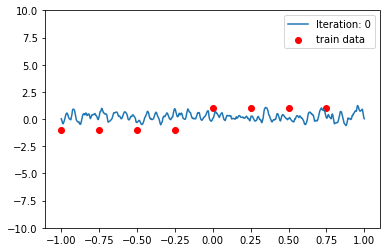

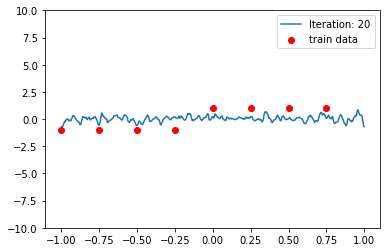

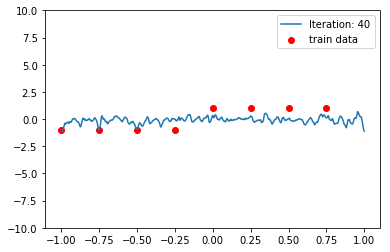

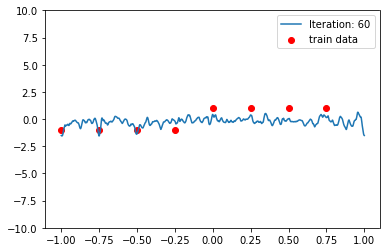

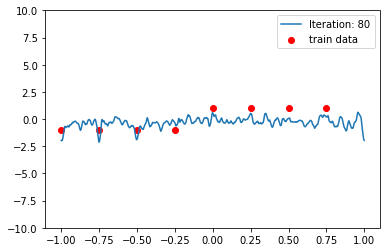

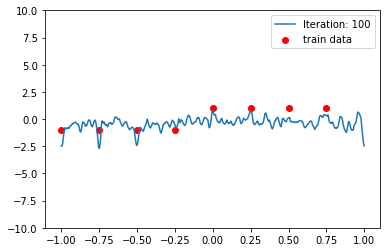

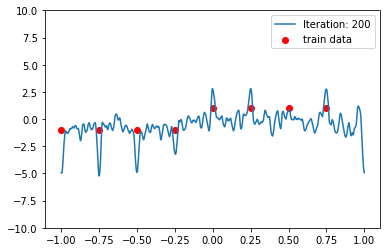

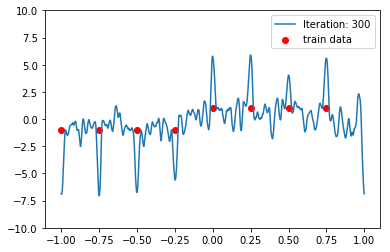

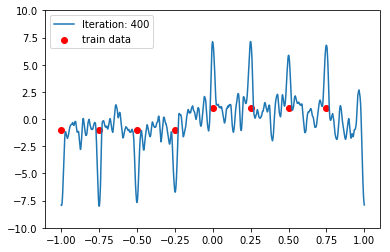

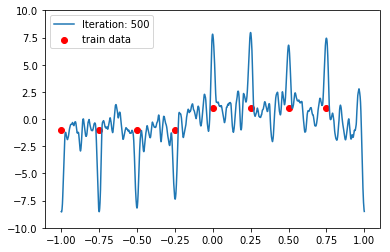

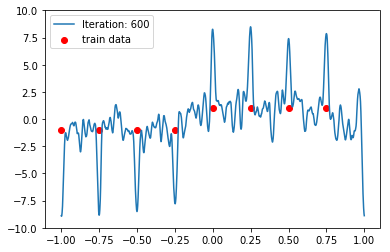

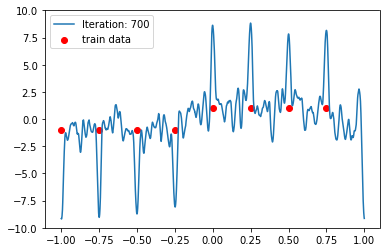

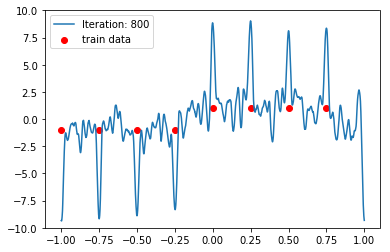

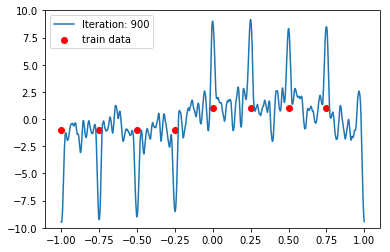

In [38]:
#plt.plot(x_train, y_train_ogi.flatten(),  color = "blue", linewidth=0, marker="D", markersize=5, label = 'Train data', alpha = 0.75 )

for (idx, preds) in enumerate(preds_list_smaller):
    label = "Iteration: " + str(indices[idx])
    plt.scatter(x_train, y_train_ogi, label = 'train data', color = 'red')
    plt.plot(x_test, preds,'-', marker = 'x', markersize = 0, linewidth = 1.5, label = label)
    plt.ylim([-10,10])
    plt.legend()
    plt.show()

# Processing feats and plotting

In [31]:
feats_select = feat_list[80]

NameError: name 'feat_list' is not defined

In [ ]:
for i in range(5):
    feat_i = feats_select[:, i]
    label = "feature no: " + str(i)
    plt.plot(x_test, feat_i, label = label)
    plt.legend()
    plt.show()